# 分割前

device: cuda
[0] L_real_mix=0.1904 L_real_sem=97.8570 L_cf_s0=0.4949 L_cf_p0=0.4851 L_mono=0.0012 L_cos=0.1403 H_I=0.8321 L_env=0.0000 L_self=0.1126 L_rev=0.6797 mse_s=0.3788 mse_p=0.2617 mse=0.3203 rev_abs_mean=0.0908 rev_std=0.0779 self_mass=0.1426 Val_sem=99.3259
   [MON-TR] y_mean=0.6855 y_std=0.0031 y_min=0.6781 y_max=0.6902 corr=0.7262 m_real=0.6855 m_s0=0.6884 m_p0=0.6816 gap_s=-0.0029 gap_p=0.0040 ratio_s=1.0042 ratio_p=0.9942 env_sum=0.4322 I_sum=0.4256 self=0.1423 H_I=0.8311
   [MON-VA] y_mean=0.6856 y_std=0.0031 y_min=0.6782 y_max=0.6902 corr=0.7122 m_real=0.6856 m_s0=0.6884 m_p0=0.6817 gap_s=-0.0028 gap_p=0.0039 ratio_s=1.0041 ratio_p=0.9943 env_sum=0.4321 I_sum=0.4256 self=0.1423 H_I=0.8311
[200] L_real_mix=0.0235 L_real_sem=6.5013 L_cf_s0=0.0457 L_cf_p0=0.0000 L_mono=0.0000 L_cos=0.2509 H_I=0.8593 L_env=0.0000 L_self=0.1153 L_rev=0.0000 mse_s=2.2108 mse_p=1.9928 mse=2.1018 rev_abs_mean=1.0245 rev_std=0.0870 self_mass=0.1453 Val_sem=6.6095
   [MON-TR] y_mean=0.5406 y_std=0

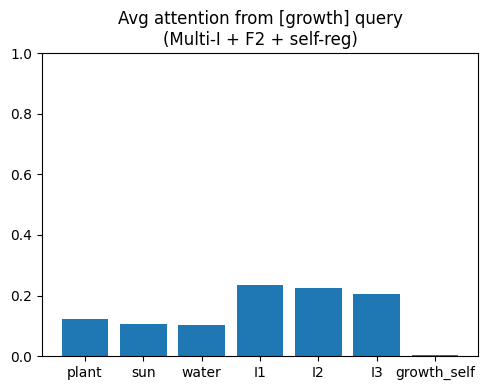

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- Collapse guards (minimal) ----
LAMBDA_SEM_MIN = 0.20   # semantic回帰の下限（αに依らず確保）
CF_HINGE_MARGIN = 1e-3  # 反事実 hinge のマージン
LOGSPACE_EPS = 1e-8     # log-space用

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1. データ生成（前回と同じ）
# -----------------------------
def generate_world_data(n):
    plant = torch.bernoulli(torch.full((n,), 0.7))
    sun   = torch.rand(n)
    water = torch.rand(n)

    base = 1.2*sun + 0.8*water
    base = torch.tanh(base * 2.0)
    noise = 0.05*torch.randn(n)
    growth = plant * (base + noise)
    growth = torch.clamp(growth, min=0.0)
    return plant, sun, water, growth

N = 5000
plant, sun, water, growth = generate_world_data(N)

perm = torch.randperm(N)
train_idx = perm[: int(0.8*N)]
val_idx   = perm[int(0.8*N):]

train_data = (
    plant[train_idx].to(device),
    sun[train_idx].to(device),
    water[train_idx].to(device),
    growth[train_idx].to(device),
)
val_data = (
    plant[val_idx].to(device),
    sun[val_idx].to(device),
    water[val_idx].to(device),
    growth[val_idx].to(device),
)

# -----------------------------
# 2. Multi-head Self-Attention
# -----------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None, need_weights=False):
        B, T, D = x.shape
        H, Dh = self.n_heads, self.d_head

        q = self.q_proj(x).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(x).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, Dh).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (Dh ** 0.5)

        if attn_mask is not None:
            if attn_mask.shape != scores.shape:
                raise ValueError(f"attn_mask shape {attn_mask.shape} must match scores {scores.shape}")
            scores = attn_mask.to(dtype=scores.dtype, device=scores.device).add_(scores)

        attn = torch.softmax(scores, dim=-1)           # (B,H,T,T)
        out = torch.matmul(attn, v)                    # (B,H,T,Dh)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)

        if need_weights:
            return out, attn
        return out, None

# -----------------------------
# 3. Multi-I 世界モデル (F2 用拡張)
#    トークン列: [plant, sun, water, I1, I2, I3, growth]
# -----------------------------
class MultiIWorldModel(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        self.d_model = d_model

        # 外界トークン
        self.embed_in = nn.Linear(1, d_model)

        # 3つの I を作る MLP
        self.I_mlp = nn.Sequential(
            nn.Linear(3, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3 * d_model),  # I1,I2,I3 をまとめて出す
        )

        # growth クエリトークン
        self.growth_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        self.attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

        # 意味ブランチ用 head（従来の growth token から）
        self.head_sem = nn.Linear(d_model, 1)
        # 統計ブランチ用 head（env 平均から）
        self.head_stat = nn.Linear(d_model, 1)
        # 逆向き head（growth token から env を推定）
        self.head_reverse = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3),
        )

    def forward(self, plant, sun, water,
                return_attn=False, return_both=False):
        B = plant.shape[0]

        p = self.embed_in(plant.view(B, 1, 1))
        s = self.embed_in(sun.view(B, 1, 1))
        w = self.embed_in(water.view(B, 1, 1))

        env = torch.stack([plant, sun, water], dim=-1)      # (B,3)
        I_all = self.I_mlp(env)                             # (B,3D)
        I_all = I_all.view(B, 3, self.d_model)              # (B,3,D)
        I1, I2, I3 = I_all[:, 0:1, :], I_all[:, 1:2, :], I_all[:, 2:3, :]

        g = self.growth_token.expand(B, -1, -1)             # (B,1,D)

        # [plant, sun, water, I1, I2, I3, growth]
        x = torch.cat([p, s, w, I1, I2, I3, g], dim=1)      # (B,7,D)

        # Attention mask (下三角 + I 限定参照):
        #   - env 同士は時間方向の下三角（未来禁止）
        #   - I1-3 は env(plant,sun,water) のみ参照可
        #   - growth は過去/現在のみ参照可（下三角）
        T = x.size(1)
        base = torch.zeros((T, T), device=x.device, dtype=x.dtype)
        upper = torch.triu(torch.ones((T, T), device=x.device), diagonal=1).bool()
        base = base.masked_fill(upper, float("-inf"))
        base[3:6, :] = float("-inf")
        base[3:6, 0:3] = 0.0

        attn_mask = base.unsqueeze(0).unsqueeze(0).expand(B, self.attn.n_heads, T, T).clone()

        x_out, attn = self.attn(x, attn_mask=attn_mask, need_weights=True)       # attn:(B,H,7,7)

        # semantic / meaning ブランチ
        growth_sem_rep  = x_out[:, 6, :]                    # growth token
        growth_sem_raw  = self.head_sem(growth_sem_rep).squeeze(-1)
        growth_sem_pred = F.softplus(growth_sem_raw) + 1e-6

        # statistical ブランチ
        env_reps  = x_out[:, 0:3, :]                        # plant,sun,water
        env_mean  = env_reps.mean(dim=1)                    # (B,D)
        growth_stat_raw  = self.head_stat(env_mean).squeeze(-1)
        growth_stat_pred = F.softplus(growth_stat_raw)

        if return_both:
            return growth_stat_pred, growth_sem_pred, attn, (I1, I2, I3)

        if return_attn:
            return growth_sem_pred, attn, (I1, I2, I3)

        # デフォルトは semantic 出力
        return growth_sem_pred

    def reverse_from_growth(self, batch_size, device=None):
        """
        growth トークンのみを残し、他トークンをゼロ埋めした入力から
        env (plant, sun, water) を逆推定するヘッド。
        """
        if device is None:
            device = self.growth_token.device

        g = self.growth_token.expand(batch_size, -1, -1).to(device=device)
        zeros_env = torch.zeros(batch_size, 6, self.d_model, device=device, dtype=g.dtype)
        x_rev = torch.cat([zeros_env, g], dim=1)

        x_rev_out, _ = self.attn(x_rev, need_weights=False)
        growth_rev_rep = x_rev_out[:, 6, :]
        reverse_raw = self.head_reverse(growth_rev_rep)
        return reverse_raw

class FStatWrapper(nn.Module):
    """
    main_model の EMA 版（teacher）
    出力にはスケール制御を入れる。
    """
    def __init__(self, model, tau=0.02, scale=2.0):
        super().__init__()
        self.teacher = MultiIWorldModel(d_model=model.d_model,
                                        n_heads=model.attn.n_heads).to(device)
        self.teacher.load_state_dict(model.state_dict())   # 初期は同じ
        self.tau = tau
        self.scale = scale

    @torch.no_grad()
    def ema_update(self, model):
        for p_teacher, p_main in zip(self.teacher.parameters(), model.parameters()):
            p_teacher.data = (1 - self.tau) * p_teacher.data + self.tau * p_main.data

    def forward(self, plant, sun, water):
        raw = self.teacher(plant, sun, water)
        y = torch.tanh(raw) * self.scale
        y = F.softplus(y)
        return y

# -----------------------------
# 4. loss 関数群
# -----------------------------
def loss_real_with_attn_F2(model, data, alpha):
    """
    F2: y = (1-alpha) * y_stat + alpha * y_sem で予測
    """
    p, s, w, y = data
    y_stat, y_sem, attn, I_triplet = model(p, s, w, return_both=True)
    y_pred = (1.0 - alpha) * y_stat + alpha * y_sem
    mse = F.mse_loss(y_pred, y)
    return mse, attn, I_triplet

def loss_counterfactual_sun0(model, data):
    p, s, w, _ = data
    s0 = torch.zeros_like(s)
    pred = model(p, s0, w)
    return (pred ** 2).mean()

def loss_counterfactual_plant0(model, data):
    p, s, w, _ = data
    p0 = torch.zeros_like(p)
    pred = model(p0, s, w)
    return (pred ** 2).mean()

def loss_monotonic_sun(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)

    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    return torch.relu(y1 - y2).mean()

def cosine_divergence_I(I_triplet):
    I1, I2, I3 = I_triplet
    def cos(a, b):
        a_flat = a.view(a.size(0), -1)
        b_flat = b.view(b.size(0), -1)
        return F.cosine_similarity(a_flat, b_flat, dim=-1)  # (B,)
    c12 = cos(I1, I2)
    c13 = cos(I1, I3)
    c23 = cos(I2, I3)
    return (c12**2 + c13**2 + c23**2).mean()

def entropy_I_attention(attn):
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    probs_I = growth_row[:, 3:6]          # I1,I2,I3

    eps = 1e-8
    log_p = torch.log(probs_I + eps)
    ent = -(probs_I * log_p).sum(dim=-1)  # (B,)
    return ent.mean()

def env_attention_penalty(attn, alpha=0.3):
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    env_sum = growth_row[:, 0:3].sum(dim=-1)
    penalty = torch.relu(alpha - env_sum)
    return penalty.mean()

def cf_hinge_loss(y, margin=1e-3):
    # loss = E[ relu(|y|-m)^2 ]
    return (torch.relu(torch.abs(y) - margin) ** 2).mean()

def loss_real_sem_log(model, data, eps=LOGSPACE_EPS):
    p, s, w, y = data
    _, y_sem, _, _ = model(p, s, w, return_both=True)
    return F.mse_loss(torch.log(y_sem + eps), torch.log(y + eps))


# === ここから self 関連のヘルパー ===

def self_attention_mass_from_attn(attn):
    """
    growth クエリが growth_self へ向ける注意の平均を返す。
    attn: (B,H,7,7)
    """
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    self_mass = growth_row[:, 6]          # (B,)
    return self_mass.mean()

def fstat_loss(fstat, data, base_loss_weight=0.1, meaning_weight=0.05):
    p, s, w, y = data
    y_pred = fstat(plant=p, sun=s, water=w)
    L_basic = (y_pred ** 2).mean()

    # weak causal / monotonic constraints
    y_s0 = fstat(p, torch.zeros_like(s), w)
    y_p0 = fstat(torch.zeros_like(p), s, w)
    L_cf = (y_s0.mean() + y_p0.mean())

    plant = torch.ones(64, device=device)
    water = torch.rand(64, device=device)
    sun1  = torch.rand(64, device=device)
    sun2  = sun1 + torch.rand(64, device=device) * (1.0 - sun1)
    y1 = fstat(plant, sun1, water)
    y2 = fstat(plant, sun2, water)
    L_mono = torch.relu(y1 - y2).mean()

    return (
        base_loss_weight * L_basic
        + meaning_weight * (L_cf + L_mono)
    )

# =========================================
# semantic ブランチ専用の因果・単調性制約
# =========================================

def loss_counterfactual_sun0_sem(model, data):
    """
    semantic ブランチにだけ sun=0 反事実制約を課す。
    F2 の混合出力ではなく、y_sem 単独にペナルティ。
    """
    p, s, w, _ = data
    s0 = torch.zeros_like(s)

    # F2 用 forward: return_both=True で (y_stat, y_sem, attn, I_triplet)
    y_stat, y_sem, _, _ = model(p, s0, w, return_both=True)

    # 「sun=0 なら成長してはいけない」は semantic 側にだけ要求
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_counterfactual_plant0_sem(model, data):
    """
    semantic ブランチにだけ plant=0 反事実制約を課す。
    """
    p, s, w, _ = data
    p0 = torch.zeros_like(p)

    y_stat, y_sem, _, _ = model(p0, s, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_monotonic_sun_sem(model, device, n_pairs=64):
    """
    semantic ブランチにだけ sun 単調性制約を課す。
    plant=1, water ランダム、sun1 <= sun2 なのに y_sem(sun1) > y_sem(sun2)
    になっている部分を罰する。
    """
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)  # sun2 >= sun1

    y_stat1, y_sem1, _, _ = model(plant, sun1, water, return_both=True)
    y_stat2, y_sem2, _, _ = model(plant, sun2, water, return_both=True)

    viol = torch.relu(y_sem1 - y_sem2).mean()
    return viol


import copy
import math

# =============================
# ε 計算用ヘルパー
# =============================

@torch.no_grad()
def dC(model_f, model_g, data):
    p, s, w, _ = data
    y_f = model_f(p, s, w)
    y_g = model_g(p, s, w)
    return (y_f - y_g).abs().mean().item()

@torch.no_grad()
def cf_violation(model, data):
    p, s, w, _ = data
    y_s0 = model(p, torch.zeros_like(s), w)
    y_p0 = model(torch.zeros_like(p), s, w)
    return (y_s0.mean() + y_p0.mean()).item()

@torch.no_grad()
def mono_violation(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    viol = torch.relu(y1 - y2).mean()
    return viol.item()

@torch.no_grad()
def attention_distribution_with_self(model, data):
    """
    growth クエリ行の 7 要素全体を分布化して返す:
    [plant, sun, water, I1, I2, I3, growth_self]
    """
    p, s, w, _ = data
    y_pred, attn, _ = model(p, s, w, return_attn=True)  # (B,H,7,7)

    attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
    growth_row = attn_mean[6]                 # (7,)

    dist7 = torch.clamp(growth_row, min=1e-8)
    dist7 = dist7 / dist7.sum()
    return dist7.cpu()

def KL_divergence(p, q):
    eps = 1e-8
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    return float((p * (p.log() - q.log())).sum().item())

@torch.no_grad()
def dM(model_f, model_g, data, device,
       w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
       sym_att=True):
    """
    意味圏の距離 d_M(F(f),F(g)):
      d_cf, d_mono, d_att( env+I ), d_self( self_mass の差 )
    """

    # 1. 反事実違反度の差
    CF_f = cf_violation(model_f, data)
    CF_g = cf_violation(model_g, data)
    d_cf = abs(CF_f - CF_g)

    # 2. 単調性違反度の差
    MONO_f = mono_violation(model_f, device=device, n_pairs=128)
    MONO_g = mono_violation(model_g, device=device, n_pairs=128)
    d_mono = abs(MONO_f - MONO_g)

    # 3. Attention 分布 + self_mass
    dist_f = attention_distribution_with_self(model_f, data)
    dist_g = attention_distribution_with_self(model_g, data)

    # env+I の 6次元で KL
    p = dist_f[:6]
    q = dist_g[:6]
    p = p / p.sum()
    q = q / q.sum()

    if sym_att:
        d_att = KL_divergence(p, q) + KL_divergence(q, p)
    else:
        d_att = KL_divergence(p, q)

    # self_mass の差
    self_f = float(dist_f[6].item())
    self_g = float(dist_g[6].item())
    d_self = abs(self_f - self_g)

    dM_val = w_cf * d_cf + w_mono * d_mono + w_att * d_att + w_self * d_self

    return {
        "d_cf": d_cf,
        "d_mono": d_mono,
        "d_att": d_att,
        "d_self": d_self,
        "self_f": self_f,
        "self_g": self_g,
        "dM": dM_val,
    }

@torch.no_grad()
def epsilon_between_models(model_f, model_g, data, device,
                           w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
                           sym_att=True):
    dC_val = dC(model_f, model_g, data)
    dM_dict = dM(model_f, model_g, data, device,
                 w_cf=w_cf, w_mono=w_mono, w_att=w_att, w_self=w_self,
                 sym_att=sym_att)
    eps = dM_dict["dM"] - dC_val
    out = {
        "dC": dC_val,
        **dM_dict,
        "epsilon": eps,
    }
    return out

# =============================
# ε -> α (gate) 変換ヘルパー
# =============================
def epsilon_to_alpha(epsilon, k=5.0):
    import math
    eps_clipped = max(min(epsilon, 1.0), -1.0)
    return 1.0 / (1.0 + math.exp(-k * eps_clipped))

# =============================
# 監視ログ用ヘルパー（学習には使わない）
# =============================
@torch.no_grad()
def pearson_corr(a, b, eps=1e-8):
    """
    a,b: (B,)  torch tensor
    """
    a = a.view(-1)
    b = b.view(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std(unbiased=False) * b0.std(unbiased=False) + eps)
    return (a0 * b0).mean() / denom

@torch.no_grad()
def semantic_health_metrics(model, data, device):
    """
    semantic ブランチの健全性をまとめて返す（ログ専用）
    - mean/std
    - corr(y_sem, y_true)
    - CF gap / ratio
    - attention: env_sum / I_sum / self_mass / H_I
    """
    p, s, w, y = data

    # y_sem (real)
    _, y_sem, attn, _ = model(p, s, w, return_both=True)
    y_sem = y_sem.detach()
    y_mean = float(y_sem.mean().item())
    y_std  = float(y_sem.std(unbiased=False).item())
    y_min  = float(y_sem.min().item())
    y_max  = float(y_sem.max().item())
    corr   = float(pearson_corr(y_sem, y).item())

    # counterfactual means (semantic only)
    s0 = torch.zeros_like(s)
    p0 = torch.zeros_like(p)
    _, y_sem_s0, _, _ = model(p, s0, w, return_both=True)
    _, y_sem_p0, _, _ = model(p0, s, w, return_both=True)
    m_real = float(y_sem.mean().item())
    m_s0   = float(y_sem_s0.mean().item())
    m_p0   = float(y_sem_p0.mean().item())

    gap_s = m_real - m_s0
    gap_p = m_real - m_p0
    ratio_s = m_s0 / (m_real + 1e-8)
    ratio_p = m_p0 / (m_real + 1e-8)
    # attention summary
    attn_mean = attn.mean(dim=1).mean(dim=0)   # (7,7)
    g_row = attn_mean[6]                       # (7,)
    env_sum  = float(g_row[0:3].sum().item())
    I_sum    = float(g_row[3:6].sum().item())
    self_m   = float(g_row[6].item())
    H_I_val  = float(entropy_I_attention(attn).item())

    return {
        "y_mean": y_mean, "y_std": y_std, "y_min": y_min, "y_max": y_max,
        "corr": corr,
        "m_real": m_real, "m_s0": m_s0, "m_p0": m_p0,
        "gap_s": gap_s, "gap_p": gap_p,
        "ratio_s": ratio_s, "ratio_p": ratio_p,
        "env_sum": env_sum, "I_sum": I_sum, "self_m": self_m,
        "H_I": H_I_val,
    }

# -----------------------------
# 5. 学習ループ（F2 + L_self）
# -----------------------------
model = MultiIWorldModel(d_model=32, n_heads=4).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
fstat = FStatWrapper(model, tau=0.02, scale=2.0)

λ_cf_base   = 1.0
λ_mono_base = 0.5
λ_cos_base  = 0.1
λ_ent_base  = 0.05
λ_env_base  = 0.5
λ_real_base = 1.0
λ_self      = 1.0   # self-loop 正則化の重み（αとは独立）
λ_sem       = 0.1  # ★ semantic ブランチ用の弱い MSE
λ_reverse   = 0.01  # growth→env 逆向き head への負の学習率（小さめ）

self_target = 0.03  # growth_self への注意の望ましい上限（要調整）

prev_state = None
alpha = 0.5

for epoch in range(2001):
    model.train()
    opt.zero_grad()

    # α から λ_eff を計算
    λ_cf_eff   = λ_cf_base   * (0.5 + 0.5 * alpha)
    λ_mono_eff = λ_mono_base * (0.5 + 0.5 * alpha)
    λ_cos_eff  = λ_cos_base  * (0.5 + 0.5 * alpha)
    λ_ent_eff  = λ_ent_base  * (0.5 + 0.5 * alpha)
    λ_env_eff  = λ_env_base  * (0.5 + 0.5 * alpha)
    λ_real_eff = λ_real_base * (1.5 - 0.5 * alpha)

        # -----------------------------------------
    # F2 バージョンの実データ損失（stat+sem の混合）
    # -----------------------------------------
    L_real_mix, attn, I_triplet = loss_real_with_attn_F2(model, train_data, alpha)

    # NEW: semantic ブランチ単独のデータフィット（弱い責任）
    # alpha=1.0 で y_pred = y_sem になることを利用
    L_real_sem = loss_real_sem_log(model, train_data)

    # 反事実・単調性・I 構造（semantic ブランチにのみ課す）
    L_cf_s = loss_counterfactual_sun0_sem(model, train_data)
    L_cf_p = loss_counterfactual_plant0_sem(model, train_data)
    L_mono = loss_monotonic_sun_sem(model, device, n_pairs=128)

    L_cos = cosine_divergence_I(I_triplet)
    H_I   = entropy_I_attention(attn)
    L_env = env_attention_penalty(attn, alpha=0.3)

    # growth token のみを残した入力から env を再構成する逆向き head。
    # 介入データ (do(sun=0), do(plant=0)) をターゲットにしつつ、
    # その精度を下げるように負の重みで学習。
    p, s, w = train_data[:3]
    # --- reverse head: growth から env(do) を再構成しようとする能力を「一定以上なら抑制」する（A案） ---
    reverse_pred = model.reverse_from_growth(batch_size=p.size(0), device=device)

    # 介入ターゲット
    env_do_s = torch.stack([p, torch.zeros_like(s), w], dim=-1)
    env_do_p = torch.stack([torch.zeros_like(p), s, w], dim=-1)

    # 監視用：各介入ターゲットへの MSE（reduction="mean"）
    mse_s = F.mse_loss(reverse_pred, env_do_s)
    mse_p = F.mse_loss(reverse_pred, env_do_p)
    mse = 0.5 * (mse_s + mse_p)

    # A案：MSE が margin 未満のときだけ「もっと外せ（= mse を増やせ）」という圧をかける
    # mse が margin を超えたら 0 になり、発散で稼げない
    rev_margin = 1.0  # まずは 0.5, 1.0, 2.0 で試すのがおすすめ
    L_reverse = torch.relu(rev_margin - mse)

    # 監視用：reverse_pred の発散検知
    rev_abs_mean = reverse_pred.abs().mean()
    rev_std = reverse_pred.std()

    # self-loop 正則化
    self_mass = self_attention_mass_from_attn(attn)
    L_self = torch.relu(self_mass - self_target)

    λ_sem_eff = max(LAMBDA_SEM_MIN, λ_sem * alpha)

    # 全体 loss
    loss = (
        λ_real_eff * L_real_mix         # F2 混合出力の MSE
        + λ_sem_eff  * L_real_sem       # ★ semantic 用の弱い MSE
        + λ_cf_eff   * (L_cf_s + L_cf_p)
        + λ_mono_eff * L_mono
        + λ_cos_eff  * L_cos
        - λ_ent_eff  * H_I
        + λ_env_eff  * L_env
        + λ_self * L_self
        + λ_reverse * L_reverse
    )

    loss.backward()
    opt.step()

    # main の更新後に EMA 更新
    fstat.ema_update(model)

    # F_stat の loss（軽い意味制約）
    L_fstat = fstat_loss(fstat, train_data,
                         base_loss_weight=0.1, meaning_weight=0.05)

    # 200エポックごとに ε & α 更新
    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            val_L_sem = loss_real_sem_log(model, val_data)
            # 監視（train/val）
            mon_tr  = semantic_health_metrics(model, train_data, device)
            mon_val = semantic_health_metrics(model, val_data, device)


        print(
            f"[{epoch}] "
            f"L_real_mix={L_real_mix.item():.4f} "   # F2 混合の MSE
            f"L_real_sem={L_real_sem.item():.4f} "   # semantic 単独の MSE
            f"L_cf_s0={L_cf_s.item():.4f} L_cf_p0={L_cf_p.item():.4f} "
            f"L_mono={L_mono.item():.4f} "
            f"L_cos={L_cos.item():.4f} "
            f"H_I={H_I.item():.4f} "
            f"L_env={L_env.item():.4f} "
            f"L_self={L_self.item():.4f} "
            f"L_rev={L_reverse.item():.4f} "
            f"mse_s={mse_s.item():.4f} mse_p={mse_p.item():.4f} mse={mse.item():.4f} "
            f"rev_abs_mean={rev_abs_mean.item():.4f} rev_std={rev_std.item():.4f} "
            f"self_mass={self_mass.item():.4f} "
            f"Val_sem={val_L_sem.item():.4f}"
        )

        # ---- 追加：semantic 崩壊監視ログ（学習には未使用）----
        print(
            f"   [MON-TR] y_mean={mon_tr['y_mean']:.4f} y_std={mon_tr['y_std']:.4f} "
            f"y_min={mon_tr['y_min']:.4f} y_max={mon_tr['y_max']:.4f} "
            f"corr={mon_tr['corr']:.4f} "
            f"m_real={mon_tr['m_real']:.4f} m_s0={mon_tr['m_s0']:.4f} m_p0={mon_tr['m_p0']:.4f} "
            f"gap_s={mon_tr['gap_s']:.4f} gap_p={mon_tr['gap_p']:.4f} "
            f"ratio_s={mon_tr['ratio_s']:.4f} ratio_p={mon_tr['ratio_p']:.4f} "
            f"env_sum={mon_tr['env_sum']:.4f} I_sum={mon_tr['I_sum']:.4f} self={mon_tr['self_m']:.4f} "
            f"H_I={mon_tr['H_I']:.4f}"
        )
        print(
            f"   [MON-VA] y_mean={mon_val['y_mean']:.4f} y_std={mon_val['y_std']:.4f} "
            f"y_min={mon_val['y_min']:.4f} y_max={mon_val['y_max']:.4f} "
            f"corr={mon_val['corr']:.4f} "
            f"m_real={mon_val['m_real']:.4f} m_s0={mon_val['m_s0']:.4f} m_p0={mon_val['m_p0']:.4f} "
            f"gap_s={mon_val['gap_s']:.4f} gap_p={mon_val['gap_p']:.4f} "
            f"ratio_s={mon_val['ratio_s']:.4f} ratio_p={mon_val['ratio_p']:.4f} "
            f"env_sum={mon_val['env_sum']:.4f} I_sum={mon_val['I_sum']:.4f} self={mon_val['self_m']:.4f} "
            f"H_I={mon_val['H_I']:.4f}"
        )


        if prev_state is not None:
            prev_model = MultiIWorldModel(d_model=32, n_heads=4).to(device)
            prev_model.load_state_dict(prev_state)
            prev_model.eval()

            eps_info = epsilon_between_models(
                model_f=model,
                model_g=prev_model,
                data=train_data,
                device=device,
                w_cf=1.0,
                w_mono=1.0,
                w_att=1.0,
                w_self=1.0,
                sym_att=True,
            )

            epsilon_val = eps_info["epsilon"]
            alpha = epsilon_to_alpha(epsilon_val, k=5.0)

            print(
                f"   dC={eps_info['dC']:.6f} "
                f"d_cf={eps_info['d_cf']:.6f} "
                f"d_mono={eps_info['d_mono']:.6f} "
                f"d_att={eps_info['d_att']:.6f} "
                f"d_self={eps_info['d_self']:.6f} "
                f"self_f={eps_info['self_f']:.4f} "
                f"self_g={eps_info['self_g']:.4f} "
                f"epsilon={epsilon_val:.6f} "
                f"alpha={alpha:.3f}"
            )

        prev_state = copy.deepcopy(model.state_dict())

# -----------------------------
# 6. 反事実チェック & attention 可視化
# -----------------------------
model.eval()
p_tr, s_tr, w_tr, y_tr = train_data

with torch.no_grad():
    # ここでは意味ブランチ（alpha=1）の出力で見る
    _, y_sem, _, _ = model(p_tr, s_tr, w_tr, return_both=True)
    y_real = y_sem
    y_s0   = model(p_tr, torch.zeros_like(s_tr), w_tr)
    y_p0   = model(torch.zeros_like(p_tr), s_tr, w_tr)

print("\n=== 反事実チェック (Multi-I + F2 + self-reg) ===")
print("mean growth (real data) : ", y_real.mean().item())
print("mean growth (sun=0)     : ", y_s0.mean().item())
print("mean growth (plant=0)   : ", y_p0.mean().item())

# attention 平均
with torch.no_grad():
    _, attn, _ = model(p_tr, s_tr, w_tr, return_attn=True)

attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
growth_row = attn_mean[6]                 # (7,)
labels = ["plant", "sun", "water", "I1", "I2", "I3", "growth_self"]

print("\nAvg attention from [growth] query (Multi-I + F2 + self-reg):")
for name, val in zip(labels, growth_row.tolist()):
    print(f"{name:>12}: {val:.4f}")

plt.figure(figsize=(5,4))
plt.bar(labels, growth_row.cpu())
plt.ylim(0,1.0)
plt.title("Avg attention from [growth] query\n(Multi-I + F2 + self-reg)")
plt.tight_layout()
plt.show()

In [ ]:
%%writefile config.py
# config.py
import torch

# ---- Collapse guards (minimal) ----
LAMBDA_SEM_MIN = 0.20   # semantic回帰の下限（αに依らず確保）
CF_HINGE_MARGIN = 1e-3  # 反事実 hinge のマージン
LOGSPACE_EPS = 1e-8     # log-space用

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Training hyperparams ----
N = 5000
TRAIN_RATIO = 0.8
EPOCHS = 2001
LR = 1e-3

D_MODEL = 32
N_HEADS = 4

# loss weights
LAMBDA = dict(
    cf_base=1.0,
    mono_base=0.5,
    cos_base=0.1,
    ent_base=0.05,
    env_base=0.5,
    real_base=1.0,
    self_=1.0,
    sem=0.1,
    reverse=0.01,
)

SELF_TARGET = 0.03

# EMA teacher
EMA_TAU = 0.02
FSTAT_SCALE = 2.0

# reverse head
REV_MARGIN = 1.0

# epsilon->alpha
ALPHA_K = 5.0

# logging
LOG_EVERY = 200


Writing config.py


In [ ]:
%%writefile data.py
# data.py
import torch

def generate_world_data(n: int):
    plant = torch.bernoulli(torch.full((n,), 0.7))
    sun   = torch.rand(n)
    water = torch.rand(n)

    base = 1.2 * sun + 0.8 * water
    base = torch.tanh(base * 2.0)
    noise = 0.05 * torch.randn(n)
    growth = plant * (base + noise)
    growth = torch.clamp(growth, min=0.0)
    return plant, sun, water, growth

def make_split(n: int, train_ratio: float = 0.8, seed: int | None = None):
    if seed is not None:
        g = torch.Generator().manual_seed(seed)
        perm = torch.randperm(n, generator=g)
    else:
        perm = torch.randperm(n)

    n_tr = int(train_ratio * n)
    train_idx = perm[:n_tr]
    val_idx = perm[n_tr:]
    return train_idx, val_idx

def pack_data(plant, sun, water, growth, idx, device: str):
    return (
        plant[idx].to(device),
        sun[idx].to(device),
        water[idx].to(device),
        growth[idx].to(device),
    )


Writing data.py


In [ ]:
%%writefile model.py
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None, need_weights=False):
        B, T, D = x.shape
        H, Dh = self.n_heads, self.d_head

        q = self.q_proj(x).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(x).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, Dh).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (Dh ** 0.5)

        if attn_mask is not None:
            if attn_mask.shape != scores.shape:
                raise ValueError(f"attn_mask shape {attn_mask.shape} must match scores {scores.shape}")
            scores = attn_mask.to(dtype=scores.dtype, device=scores.device).add_(scores)

        attn = torch.softmax(scores, dim=-1)           # (B,H,T,T)
        out = torch.matmul(attn, v)                    # (B,H,T,Dh)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)

        if need_weights:
            return out, attn
        return out, None


class MultiIWorldModel(nn.Module):
    """
    トークン列: [plant, sun, water, I1, I2, I3, growth]
    """
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        self.d_model = d_model

        self.embed_in = nn.Linear(1, d_model)

        self.I_mlp = nn.Sequential(
            nn.Linear(3, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3 * d_model),
        )

        self.growth_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        self.attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

        self.head_sem = nn.Linear(d_model, 1)
        self.head_stat = nn.Linear(d_model, 1)
        self.head_reverse = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3),
        )

    def forward(self, plant, sun, water, return_attn=False, return_both=False):
        B = plant.shape[0]

        p = self.embed_in(plant.view(B, 1, 1))
        s = self.embed_in(sun.view(B, 1, 1))
        w = self.embed_in(water.view(B, 1, 1))

        env = torch.stack([plant, sun, water], dim=-1)  # (B,3)
        I_all = self.I_mlp(env).view(B, 3, self.d_model)
        I1, I2, I3 = I_all[:, 0:1, :], I_all[:, 1:2, :], I_all[:, 2:3, :]

        g = self.growth_token.expand(B, -1, -1)
        x = torch.cat([p, s, w, I1, I2, I3, g], dim=1)  # (B,7,D)

        # mask
        T = x.size(1)
        base = torch.zeros((T, T), device=x.device, dtype=x.dtype)
        upper = torch.triu(torch.ones((T, T), device=x.device), diagonal=1).bool()
        base = base.masked_fill(upper, float("-inf"))
        base[3:6, :] = float("-inf")
        base[3:6, 0:3] = 0.0
        attn_mask = base.unsqueeze(0).unsqueeze(0).expand(B, self.attn.n_heads, T, T).clone()

        x_out, attn = self.attn(x, attn_mask=attn_mask, need_weights=True)

        # semantic
        growth_sem_rep = x_out[:, 6, :]
        growth_sem_raw = self.head_sem(growth_sem_rep).squeeze(-1)
        growth_sem_pred = F.softplus(growth_sem_raw) + 1e-6

        # statistical
        env_reps = x_out[:, 0:3, :]
        env_mean = env_reps.mean(dim=1)
        growth_stat_raw = self.head_stat(env_mean).squeeze(-1)
        growth_stat_pred = F.softplus(growth_stat_raw)

        if return_both:
            return growth_stat_pred, growth_sem_pred, attn, (I1, I2, I3)
        if return_attn:
            return growth_sem_pred, attn, (I1, I2, I3)
        return growth_sem_pred

    def reverse_from_growth(self, batch_size, device=None):
        if device is None:
            device = self.growth_token.device

        g = self.growth_token.expand(batch_size, -1, -1).to(device=device)
        zeros_env = torch.zeros(batch_size, 6, self.d_model, device=device, dtype=g.dtype)
        x_rev = torch.cat([zeros_env, g], dim=1)

        x_rev_out, _ = self.attn(x_rev, need_weights=False)
        growth_rev_rep = x_rev_out[:, 6, :]
        reverse_raw = self.head_reverse(growth_rev_rep)
        return reverse_raw


class FStatWrapper(nn.Module):
    """
    main_model の EMA 版（teacher）
    出力にスケール制御を入れる。
    """
    def __init__(self, model: MultiIWorldModel, device: str, tau=0.02, scale=2.0):
        super().__init__()
        self.teacher = MultiIWorldModel(d_model=model.d_model, n_heads=model.attn.n_heads).to(device)
        self.teacher.load_state_dict(model.state_dict())
        self.tau = tau
        self.scale = scale

    @torch.no_grad()
    def ema_update(self, model: MultiIWorldModel):
        for p_teacher, p_main in zip(self.teacher.parameters(), model.parameters()):
            p_teacher.data = (1 - self.tau) * p_teacher.data + self.tau * p_main.data

    def forward(self, plant, sun, water):
        raw = self.teacher(plant, sun, water)
        y = torch.tanh(raw) * self.scale
        y = F.softplus(y)
        return y


Writing model.py


In [ ]:
%%writefile losses.py
# losses.py
import torch
import torch.nn.functional as F
from config import CF_HINGE_MARGIN, LOGSPACE_EPS

def loss_real_with_attn_F2(model, data, alpha: float):
    p, s, w, y = data
    y_stat, y_sem, attn, I_triplet = model(p, s, w, return_both=True)
    y_pred = (1.0 - alpha) * y_stat + alpha * y_sem
    mse = F.mse_loss(y_pred, y)
    return mse, attn, I_triplet

def cf_hinge_loss(y, margin=1e-3):
    return (torch.relu(torch.abs(y) - margin) ** 2).mean()

def loss_real_sem_log(model, data, eps=LOGSPACE_EPS):
    p, s, w, y = data
    _, y_sem, _, _ = model(p, s, w, return_both=True)
    return F.mse_loss(torch.log(y_sem + eps), torch.log(y + eps))

def loss_counterfactual_sun0_sem(model, data):
    p, s, w, _ = data
    s0 = torch.zeros_like(s)
    _, y_sem, _, _ = model(p, s0, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_counterfactual_plant0_sem(model, data):
    p, s, w, _ = data
    p0 = torch.zeros_like(p)
    _, y_sem, _, _ = model(p0, s, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_monotonic_sun_sem(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    _, y_sem1, _, _ = model(plant, sun1, water, return_both=True)
    _, y_sem2, _, _ = model(plant, sun2, water, return_both=True)
    return torch.relu(y_sem1 - y_sem2).mean()

def cosine_divergence_I(I_triplet):
    I1, I2, I3 = I_triplet
    def cos(a, b):
        a_flat = a.view(a.size(0), -1)
        b_flat = b.view(b.size(0), -1)
        return F.cosine_similarity(a_flat, b_flat, dim=-1)
    c12 = cos(I1, I2)
    c13 = cos(I1, I3)
    c23 = cos(I2, I3)
    return (c12**2 + c13**2 + c23**2).mean()

def entropy_I_attention(attn):
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    probs_I = growth_row[:, 3:6]
    eps = 1e-8
    log_p = torch.log(probs_I + eps)
    ent = -(probs_I * log_p).sum(dim=-1)
    return ent.mean()

def env_attention_penalty(attn, alpha=0.3):
    attn_mean = attn.mean(dim=1)
    growth_row = attn_mean[:, 6, :]
    env_sum = growth_row[:, 0:3].sum(dim=-1)
    penalty = torch.relu(alpha - env_sum)
    return penalty.mean()

def self_attention_mass_from_attn(attn):
    attn_mean = attn.mean(dim=1)
    growth_row = attn_mean[:, 6, :]
    self_mass = growth_row[:, 6]
    return self_mass.mean()

def fstat_loss(fstat, data, device, base_loss_weight=0.1, meaning_weight=0.05):
    p, s, w, _ = data
    y_pred = fstat(plant=p, sun=s, water=w)
    L_basic = (y_pred ** 2).mean()

    y_s0 = fstat(p, torch.zeros_like(s), w)
    y_p0 = fstat(torch.zeros_like(p), s, w)
    L_cf = (y_s0.mean() + y_p0.mean())

    plant = torch.ones(64, device=device)
    water = torch.rand(64, device=device)
    sun1  = torch.rand(64, device=device)
    sun2  = sun1 + torch.rand(64, device=device) * (1.0 - sun1)
    y1 = fstat(plant, sun1, water)
    y2 = fstat(plant, sun2, water)
    L_mono = torch.relu(y1 - y2).mean()

    return base_loss_weight * L_basic + meaning_weight * (L_cf + L_mono)


Writing losses.py


In [ ]:
%%writefile metrics.py
# metrics.py
import torch
import torch.nn.functional as F
from losses import entropy_I_attention

@torch.no_grad()
def pearson_corr(a, b, eps=1e-8):
    a = a.view(-1)
    b = b.view(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std(unbiased=False) * b0.std(unbiased=False) + eps)
    return (a0 * b0).mean() / denom

@torch.no_grad()
def attention_distribution_with_self(model, data):
    p, s, w, _ = data
    _, attn, _ = model(p, s, w, return_attn=True)
    attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
    growth_row = attn_mean[6]                 # (7,)
    dist7 = torch.clamp(growth_row, min=1e-8)
    dist7 = dist7 / dist7.sum()
    return dist7.cpu()

def KL_divergence(p, q):
    eps = 1e-8
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    return float((p * (p.log() - q.log())).sum().item())

@torch.no_grad()
def dC(model_f, model_g, data):
    p, s, w, _ = data
    y_f = model_f(p, s, w)
    y_g = model_g(p, s, w)
    return (y_f - y_g).abs().mean().item()

@torch.no_grad()
def cf_violation(model, data):
    p, s, w, _ = data
    y_s0 = model(p, torch.zeros_like(s), w)
    y_p0 = model(torch.zeros_like(p), s, w)
    return (y_s0.mean() + y_p0.mean()).item()

@torch.no_grad()
def mono_violation(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    return torch.relu(y1 - y2).mean().item()

@torch.no_grad()
def dM(model_f, model_g, data, device,
       w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
       sym_att=True):

    CF_f = cf_violation(model_f, data)
    CF_g = cf_violation(model_g, data)
    d_cf = abs(CF_f - CF_g)

    MONO_f = mono_violation(model_f, device=device, n_pairs=128)
    MONO_g = mono_violation(model_g, device=device, n_pairs=128)
    d_mono = abs(MONO_f - MONO_g)

    dist_f = attention_distribution_with_self(model_f, data)
    dist_g = attention_distribution_with_self(model_g, data)

    p = dist_f[:6]; q = dist_g[:6]
    p = p / p.sum(); q = q / q.sum()

    if sym_att:
        d_att = KL_divergence(p, q) + KL_divergence(q, p)
    else:
        d_att = KL_divergence(p, q)

    self_f = float(dist_f[6].item())
    self_g = float(dist_g[6].item())
    d_self = abs(self_f - self_g)

    dM_val = w_cf * d_cf + w_mono * d_mono + w_att * d_att + w_self * d_self
    return {"d_cf": d_cf, "d_mono": d_mono, "d_att": d_att, "d_self": d_self,
            "self_f": self_f, "self_g": self_g, "dM": dM_val}

@torch.no_grad()
def epsilon_between_models(model_f, model_g, data, device,
                           w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
                           sym_att=True):
    dC_val = dC(model_f, model_g, data)
    dM_dict = dM(model_f, model_g, data, device,
                 w_cf=w_cf, w_mono=w_mono, w_att=w_att, w_self=w_self,
                 sym_att=sym_att)
    eps = dM_dict["dM"] - dC_val
    return {"dC": dC_val, **dM_dict, "epsilon": eps}

def epsilon_to_alpha(epsilon, k=5.0):
    import math
    eps_clipped = max(min(epsilon, 1.0), -1.0)
    return 1.0 / (1.0 + math.exp(-k * eps_clipped))

@torch.no_grad()
def semantic_health_metrics(model, data, device):
    p, s, w, y = data

    _, y_sem, attn, _ = model(p, s, w, return_both=True)
    y_sem = y_sem.detach()
    y_mean = float(y_sem.mean().item())
    y_std  = float(y_sem.std(unbiased=False).item())
    y_min  = float(y_sem.min().item())
    y_max  = float(y_sem.max().item())
    corr   = float(pearson_corr(y_sem, y).item())

    s0 = torch.zeros_like(s)
    p0 = torch.zeros_like(p)
    _, y_sem_s0, _, _ = model(p, s0, w, return_both=True)
    _, y_sem_p0, _, _ = model(p0, s, w, return_both=True)

    m_real = float(y_sem.mean().item())
    m_s0   = float(y_sem_s0.mean().item())
    m_p0   = float(y_sem_p0.mean().item())

    gap_s = m_real - m_s0
    gap_p = m_real - m_p0
    ratio_s = m_s0 / (m_real + 1e-8)
    ratio_p = m_p0 / (m_real + 1e-8)

    attn_mean = attn.mean(dim=1).mean(dim=0)
    g_row = attn_mean[6]
    env_sum  = float(g_row[0:3].sum().item())
    I_sum    = float(g_row[3:6].sum().item())
    self_m   = float(g_row[6].item())
    H_I_val  = float(entropy_I_attention(attn).item())

    return dict(
        y_mean=y_mean, y_std=y_std, y_min=y_min, y_max=y_max,
        corr=corr,
        m_real=m_real, m_s0=m_s0, m_p0=m_p0,
        gap_s=gap_s, gap_p=gap_p,
        ratio_s=ratio_s, ratio_p=ratio_p,
        env_sum=env_sum, I_sum=I_sum, self_m=self_m,
        H_I=H_I_val,
    )


Writing metrics.py


In [ ]:
%%writefile train.py
# train.py
import copy
import torch
import torch.nn.functional as F

import config as C
from data import generate_world_data, make_split, pack_data
from model import MultiIWorldModel, FStatWrapper
from losses import (
    loss_real_with_attn_F2, loss_real_sem_log,
    loss_counterfactual_sun0_sem, loss_counterfactual_plant0_sem,
    loss_monotonic_sun_sem,
    cosine_divergence_I, entropy_I_attention, env_attention_penalty,
    self_attention_mass_from_attn, fstat_loss,
)
from metrics import semantic_health_metrics, epsilon_between_models, epsilon_to_alpha

def main():
    print("device:", C.device)

    plant, sun, water, growth = generate_world_data(C.N)
    train_idx, val_idx = make_split(C.N, C.TRAIN_RATIO)
    train_data = pack_data(plant, sun, water, growth, train_idx, C.device)
    val_data   = pack_data(plant, sun, water, growth, val_idx, C.device)

    model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
    opt = torch.optim.Adam(model.parameters(), lr=C.LR)
    fstat = FStatWrapper(model, device=C.device, tau=C.EMA_TAU, scale=C.FSTAT_SCALE)

    prev_state = None
    alpha = 0.5

    for epoch in range(C.EPOCHS):
        model.train()
        opt.zero_grad()

        # α から λ_eff
        λ_cf_eff   = C.LAMBDA["cf_base"]   * (0.5 + 0.5 * alpha)
        λ_mono_eff = C.LAMBDA["mono_base"] * (0.5 + 0.5 * alpha)
        λ_cos_eff  = C.LAMBDA["cos_base"]  * (0.5 + 0.5 * alpha)
        λ_ent_eff  = C.LAMBDA["ent_base"]  * (0.5 + 0.5 * alpha)
        λ_env_eff  = C.LAMBDA["env_base"]  * (0.5 + 0.5 * alpha)
        λ_real_eff = C.LAMBDA["real_base"] * (1.5 - 0.5 * alpha)

        # real (F2 mix)
        L_real_mix, attn, I_triplet = loss_real_with_attn_F2(model, train_data, alpha)

        # semantic weak fit (log-MSE)
        L_real_sem = loss_real_sem_log(model, train_data)

        # constraints (semantic only)
        L_cf_s = loss_counterfactual_sun0_sem(model, train_data)
        L_cf_p = loss_counterfactual_plant0_sem(model, train_data)
        L_mono = loss_monotonic_sun_sem(model, C.device, n_pairs=128)

        L_cos = cosine_divergence_I(I_triplet)
        H_I   = entropy_I_attention(attn)
        L_env = env_attention_penalty(attn, alpha=0.3)

        # reverse head (A案: margin below -> push worse)
        p, s, w = train_data[:3]
        reverse_pred = model.reverse_from_growth(batch_size=p.size(0), device=C.device)
        env_do_s = torch.stack([p, torch.zeros_like(s), w], dim=-1)
        env_do_p = torch.stack([torch.zeros_like(p), s, w], dim=-1)
        mse_s = F.mse_loss(reverse_pred, env_do_s)
        mse_p = F.mse_loss(reverse_pred, env_do_p)
        mse = 0.5 * (mse_s + mse_p)
        L_reverse = torch.relu(C.REV_MARGIN - mse)

        rev_abs_mean = reverse_pred.abs().mean()
        rev_std = reverse_pred.std()

        # self-loop regularization
        self_mass = self_attention_mass_from_attn(attn)
        L_self = torch.relu(self_mass - C.SELF_TARGET)

        λ_sem_eff = max(C.LAMBDA_SEM_MIN, C.LAMBDA["sem"] * alpha)

        loss = (
            λ_real_eff * L_real_mix
            + λ_sem_eff * L_real_sem
            + λ_cf_eff   * (L_cf_s + L_cf_p)
            + λ_mono_eff * L_mono
            + λ_cos_eff  * L_cos
            - λ_ent_eff  * H_I
            + λ_env_eff  * L_env
            + C.LAMBDA["self_"] * L_self
            + C.LAMBDA["reverse"] * L_reverse
        )

        loss.backward()
        opt.step()

        fstat.ema_update(model)
        _ = fstat_loss(fstat, train_data, device=C.device, base_loss_weight=0.1, meaning_weight=0.05)

        if epoch % C.LOG_EVERY == 0:
            model.eval()
            with torch.no_grad():
                val_L_sem = loss_real_sem_log(model, val_data)
                mon_tr  = semantic_health_metrics(model, train_data, C.device)
                mon_val = semantic_health_metrics(model, val_data, C.device)

            print(
                f"[{epoch}] "
                f"L_real_mix={L_real_mix.item():.4f} "
                f"L_real_sem={L_real_sem.item():.4f} "
                f"L_cf_s0={L_cf_s.item():.4f} L_cf_p0={L_cf_p.item():.4f} "
                f"L_mono={L_mono.item():.4f} "
                f"L_cos={L_cos.item():.4f} "
                f"H_I={H_I.item():.4f} "
                f"L_env={L_env.item():.4f} "
                f"L_self={L_self.item():.4f} "
                f"L_rev={L_reverse.item():.4f} "
                f"mse_s={mse_s.item():.4f} mse_p={mse_p.item():.4f} mse={mse.item():.4f} "
                f"rev_abs_mean={rev_abs_mean.item():.4f} rev_std={rev_std.item():.4f} "
                f"self_mass={self_mass.item():.4f} "
                f"Val_sem={val_L_sem.item():.4f}"
            )

            print(
                f"   [MON-TR] y_mean={mon_tr['y_mean']:.4f} y_std={mon_tr['y_std']:.4f} "
                f"y_min={mon_tr['y_min']:.4f} y_max={mon_tr['y_max']:.4f} "
                f"corr={mon_tr['corr']:.4f} "
                f"m_real={mon_tr['m_real']:.4f} m_s0={mon_tr['m_s0']:.4f} m_p0={mon_tr['m_p0']:.4f} "
                f"gap_s={mon_tr['gap_s']:.4f} gap_p={mon_tr['gap_p']:.4f} "
                f"ratio_s={mon_tr['ratio_s']:.4f} ratio_p={mon_tr['ratio_p']:.4f} "
                f"env_sum={mon_tr['env_sum']:.4f} I_sum={mon_tr['I_sum']:.4f} self={mon_tr['self_m']:.4f} "
                f"H_I={mon_tr['H_I']:.4f}"
            )
            print(
                f"   [MON-VA] y_mean={mon_val['y_mean']:.4f} y_std={mon_val['y_std']:.4f} "
                f"y_min={mon_val['y_min']:.4f} y_max={mon_val['y_max']:.4f} "
                f"corr={mon_val['corr']:.4f} "
                f"m_real={mon_val['m_real']:.4f} m_s0={mon_val['m_s0']:.4f} m_p0={mon_val['m_p0']:.4f} "
                f"gap_s={mon_val['gap_s']:.4f} gap_p={mon_val['gap_p']:.4f} "
                f"ratio_s={mon_val['ratio_s']:.4f} ratio_p={mon_val['ratio_p']:.4f} "
                f"env_sum={mon_val['env_sum']:.4f} I_sum={mon_val['I_sum']:.4f} self={mon_val['self_m']:.4f} "
                f"H_I={mon_val['H_I']:.4f}"
            )

            if prev_state is not None:
                prev_model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
                prev_model.load_state_dict(prev_state)
                prev_model.eval()

                eps_info = epsilon_between_models(
                    model_f=model, model_g=prev_model, data=train_data, device=C.device,
                    w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0, sym_att=True,
                )
                epsilon_val = eps_info["epsilon"]
                alpha = epsilon_to_alpha(epsilon_val, k=C.ALPHA_K)

                print(
                    f"   dC={eps_info['dC']:.6f} "
                    f"d_cf={eps_info['d_cf']:.6f} "
                    f"d_mono={eps_info['d_mono']:.6f} "
                    f"d_att={eps_info['d_att']:.6f} "
                    f"d_self={eps_info['d_self']:.6f} "
                    f"self_f={eps_info['self_f']:.4f} "
                    f"self_g={eps_info['self_g']:.4f} "
                    f"epsilon={epsilon_val:.6f} "
                    f"alpha={alpha:.3f}"
                )

            prev_state = copy.deepcopy(model.state_dict())

    # 便利：最後に重み保存したいなら
    torch.save(model.state_dict(), "model_last.pt")

if __name__ == "__main__":
    main()


Writing train.py


In [ ]:
%%writefile eval_viz.py
# eval_viz.py
import torch
import matplotlib.pyplot as plt

import config as C
from data import generate_world_data, make_split, pack_data
from model import MultiIWorldModel

def main():
    plant, sun, water, growth = generate_world_data(C.N)
    train_idx, _ = make_split(C.N, C.TRAIN_RATIO)
    train_data = pack_data(plant, sun, water, growth, train_idx, C.device)

    model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
    model.load_state_dict(torch.load("model_last.pt", map_location=C.device))
    model.eval()

    p_tr, s_tr, w_tr, _ = train_data

    with torch.no_grad():
        _, y_sem, _, _ = model(p_tr, s_tr, w_tr, return_both=True)
        y_real = y_sem
        y_s0 = model(p_tr, torch.zeros_like(s_tr), w_tr)
        y_p0 = model(torch.zeros_like(p_tr), s_tr, w_tr)

    print("\n=== 反事実チェック (Multi-I + F2 + self-reg) ===")
    print("mean growth (real data) : ", y_real.mean().item())
    print("mean growth (sun=0)     : ", y_s0.mean().item())
    print("mean growth (plant=0)   : ", y_p0.mean().item())

    with torch.no_grad():
        _, attn, _ = model(p_tr, s_tr, w_tr, return_attn=True)

    attn_mean = attn.mean(dim=1).mean(dim=0)
    growth_row = attn_mean[6]
    labels = ["plant", "sun", "water", "I1", "I2", "I3", "growth_self"]

    print("\nAvg attention from [growth] query:")
    for name, val in zip(labels, growth_row.tolist()):
        print(f"{name:>12}: {val:.4f}")

    plt.figure(figsize=(5,4))
    plt.bar(labels, growth_row.detach().cpu())
    plt.ylim(0, 1.0)
    plt.title("Avg attention from [growth] query")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Writing eval_viz.py


# 分割後

In [ ]:
!python train.py

device: cuda
[LR] table not found: runs/run1/lr_mult_by_epoch.csv (disable)
[LR] disabled
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/islands/island_epoch00000.pt
[0] L_real_mix=0.1900 L_real_sem=95.6371 L_cf_s0=0.4403 L_cf_p0=0.4392 L_mono=0.0002 L_cos=0.0743 H_I=0.8293 L_env=0.0000 L_self=0.1108 L_rev=0.6394 mse_s=0.3764 mse_p=0.3448 mse=0.3606 rev_abs_mean=0.1338 rev_std=0.1153 self_mass=0.1408 Val_sem=99.1419
   [MON-TR] y_mean=0.6498 y_std=0.0010 y_min=0.6473 y_max=0.6524 corr=-0.3051 m_real=0.6498 m_s0=0.6505 m_p0=0.6500 gap_s=-0.0008 gap_p=-0.0002 ratio_s=1.0012 ratio_p=1.0003 env_sum=0.4369 I_sum=0.4227 self=0.1404 H_I=0.8283
   [MON-VA] y_mean=0.6498 y_std=0.0011 y_min=0.6472 y_max=0.6523 corr=-0.3130 m_real=0.6498 m_s0=0.6506 m_p0=0.6500 gap_s=-0.0008 gap_p=-0.0002 ratio_s=1.0012 ratio_p=1.0003 env_sum=0.4369 I_sum=0.4227 self=0.1404 H_I=0.8283
[LR] epoch=200 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/islands/island_epoch00200.pt
[200] L_real

In [ ]:
!python eval_viz.py


=== Branch summary (y_stat / y_sem / y_mix) ===
alpha(eval)=0.500
mean stat=0.6521  sem=0.6393  mix=0.6457
corr stat=0.9723  sem=0.9798  mix=0.9858
CF sun0  stat=0.5594 sem=0.0518 mix=0.3056
CF plant0 stat=0.0514 sem=0.0000 mix=0.0257
contrib stat=0.505 sem=0.495
Saved figure to: branch_contrib.png

=== 反事実チェック (Multi-I + F2 + self-reg) ===
mean growth (real data) :  0.6392765045166016
mean growth (sun=0)     :  0.051848605275154114
mean growth (plant=0)   :  1.0000188694903045e-06

Avg attention from [growth] query:
       plant: 0.1098
         sun: 0.1049
       water: 0.1031
          I1: 0.2523
          I2: 0.2093
          I3: 0.2137
 growth_self: 0.0069

Saved figure to: attn_bar.png


In [ ]:
!python island_viz.py --runs_dir runs --pt_glob "islands/island_epoch*.pt" --use_attn

Saved:
 - runs/island_summary.csv
 - runs/island_dwell.csv
 - runs/island_count.png
 - runs/island_dwell_hist.png
 - runs/islands_epochXXXXX.png (per snapshot)


In [ ]:
!python island_eps.py

saved: runs/island_eps_summary.csv


In [ ]:
# !python island_eps_plot.py

In [ ]:
# !python island_dm_plot.py

In [ ]:
# display(Image("runs/island_eps_timeseries.png"))
# display(Image("runs/island_dM_components_timeseries.png"))

In [ ]:
!python island_profile.py

saved: runs/island_profile.csv
saved: runs/island_delta_sun_timeseries.png
saved: runs/island_delta_plant_timeseries.png
saved: runs/island_y_mix_mean_timeseries.png
saved: runs/island_attn_mass_0_2_timeseries.png
saved: runs/island_attn_mass_3_5_timeseries.png
saved: runs/island_attn_mass_6_timeseries.png


In [ ]:
# !python plot_alpha.py

In [ ]:
!python island_env_error.py --runs_dir runs --pattern "islands/island_epoch*.pt" --k 2 --use_attn 1

saved: runs/island_env_error.csv
saved plots to: runs/island_env_error_plots


In [ ]:
# from IPython.display import Image, display
# display(Image("runs/alpha.png"))
# display(Image("runs/epsilon.png"))
# display(Image("runs/dM_dC.png"))
# display(Image("runs/dM_components.png"))
# display(Image("branch_contrib.png"))

In [ ]:
# from IPython.display import Image, display
# display(Image("attn_bar.png"))

# 島の可視化

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
env_err = pd.read_csv("/content/runs/island_env_error.csv")
profile = pd.read_csv("/content/runs/island_profile.csv")


In [ ]:
# def plot_island_decision_scatter(df, epoch, x, y):
#     d = df[df["epoch"] == epoch]

#     plt.figure(figsize=(6, 5))
#     for isl in sorted(d["island"].unique()):
#         dd = d[d["island"] == isl]
#         plt.scatter(
#             dd[x],
#             dd[y],
#             label=f"island_{isl}",
#             s=80,
#             alpha=0.8
#         )

#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title(f"Island decision space (epoch={epoch})")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [ ]:
# plot_island_decision_scatter(
#     env_err,
#     epoch=2000,
#     x="sun_mean",
#     y="err_abs_mean"
# )


In [ ]:
# plot_island_decision_scatter(
#     env_err,
#     epoch=2000,
#     x="err_abs_mean",
#     y="err_signed_mean"
# )


In [ ]:
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier, export_text

# # CSV 読み込み
# df = pd.read_csv("/content/runs/island_env_error.csv")

# # epoch を固定
# df_e = df[df["epoch"] == 2000]

# # 特徴量：plant_mean, err_abs_mean
# X = df_e[["plant_mean", "err_abs_mean"]]

# # ラベル：island
# y = df_e["island"]

# # 決定木（浅く）
# clf = DecisionTreeClassifier(
#     max_depth=2,
#     min_samples_leaf=1,
#     random_state=0
# )

# clf.fit(X, y)

# # if–then 形式で表示
# print(export_text(clf, feature_names=list(X.columns)))


In [ ]:
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier, export_text

# # CSV 読み込み
# df = pd.read_csv("/content/island_env_error.csv")

# # epoch を固定
# df_e = df[df["epoch"] == 2000]

# # 特徴量：plant_mean, err_abs_mean
# X = df.iloc[:,6:]

# # ラベル：island
# y = df["island"]

# # 決定木（浅く）
# clf = DecisionTreeClassifier(
#     max_depth=4,
#     min_samples_leaf=4,
#     random_state=0
# )

# clf.fit(X, y)

# # if–then 形式で表示
# print(export_text(clf, feature_names=list(X.columns)))


In [ ]:
!python island_dt_by_epoch.py

saved: island_dt_by_epoch_err_abs_mean.csv
    epoch  threshold  left_class  ...  accuracy  val_island0  val_island1
0       0   0.469310           0  ...       1.0     0.267538     0.671083
1     200   0.207788           0  ...       1.0     0.154649     0.260928
2     400   0.135505           1  ...       1.0     0.156438     0.114571
3     600   0.106796           1  ...       1.0     0.209163     0.004430
4     800   0.137209           0  ...       1.0     0.111543     0.162874
5    1000   0.093956           0  ...       1.0     0.082802     0.105110
6    1200   0.062859           1  ...       1.0     0.069385     0.056334
7    1400   0.053987           1  ...       1.0     0.066263     0.041711
8    1600   0.050121           1  ...       1.0     0.065642     0.034601
9    1800   0.046854           1  ...       1.0     0.063894     0.029815
10   2000   0.043839           1  ...       1.0     0.060946     0.026731

[11 rows x 7 columns]
saved: island_dt_threshold_timeseries.png
save

In [ ]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pathlib import Path

# # =========================
# # Config
# # =========================
# BASE = Path(".")  # 適宜変更（例: Path("/mnt/data")）
# PATH_ENV_ERROR = BASE / "/content/runs/island_env_error.csv"
# PATH_PROFILE   = BASE / "/content/runs/island_profile.csv"
# PATH_DT        = BASE / "/content/island_dt_by_epoch_err_abs_mean.csv"

# OUT_DIR = BASE / "stepA_threshold_sources"
# OUT_DIR.mkdir(exist_ok=True)

# # =========================
# # Load
# # =========================
# env = pd.read_csv(PATH_ENV_ERROR)
# prof = pd.read_csv(PATH_PROFILE)
# dt = pd.read_csv(PATH_DT)

# # dt: epochごとの threshold（= stump境界）と island別の値
# dt = dt[["epoch","threshold","val_island0","val_island1","accuracy"]].copy()
# dt["mid_err"] = (dt["val_island0"] + dt["val_island1"]) / 2
# dt["err_gap"] = dt["val_island0"] - dt["val_island1"]

# # =========================
# # Profile を epoch×island → epoch wide（i0/i1）に変換
# # =========================
# key_cols = ["epoch","island","n"]
# feature_cols = [c for c in prof.columns if c not in key_cols]

# wide0 = prof[prof["island"]==0].set_index("epoch")[["n"]+feature_cols].add_suffix("_i0")
# wide1 = prof[prof["island"]==1].set_index("epoch")[["n"]+feature_cols].add_suffix("_i1")

# wide = wide0.join(wide1, how="inner")
# wide["n_total"] = wide["n_i0"] + wide["n_i1"]
# wide["n_ratio_i0"] = wide["n_i0"] / wide["n_total"]
# wide["n_ratio_i1"] = wide["n_i1"] / wide["n_total"]

# # 差分（island0 - island1）を作る：更新源候補として「分離に効く軸」になりやすい
# def add_diff(col):
#     if f"{col}_i0" in wide.columns and f"{col}_i1" in wide.columns:
#         wide[f"{col}_diff_i0_minus_i1"] = wide[f"{col}_i0"] - wide[f"{col}_i1"]

# selected_for_diff = [
#     "alpha_used_mean",
#     "alpha_used_std",
#     "y_true_mean","y_mix_mean",
#     "delta_sun_mean","delta_plant_mean","ratio_mean",
#     "attn_mass_0_2","attn_mass_3_5","attn_mass_6",
#     "err_abs_mean","err_abs_p90","err_signed_mean",
# ]
# for col in selected_for_diff:
#     add_diff(col)

# # =========================
# # Merge（epoch単位）
# # =========================
# df = dt.set_index("epoch").join(wide, how="inner").reset_index()

# # =========================
# # Candidate ranking（threshold との相関）
# # ただし「err_abs_mean系」は threshold の直接材料なので除外して
# # “より上流の候補” を見る
# # =========================
# exclude_patterns = [
#     r"^val_island", r"^mid_err$", r"^threshold$",
#     r"err_abs_mean", r"err_abs_p90", r"err_signed_mean", r"err_gap"
# ]
# def is_excluded(col):
#     return any(re.search(pat, col) for pat in exclude_patterns)

# cand_cols = [c for c in df.columns if c not in ["epoch","accuracy"] and not is_excluded(c)]
# cand_cols = [c for c in cand_cols if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() > 1]

# rows = []
# for c in cand_cols:
#     corr = np.corrcoef(df[c].astype(float), df["threshold"])[0,1]
#     corr_mid = np.corrcoef(df[c].astype(float), df["mid_err"])[0,1]
#     rows.append((c, corr, corr_mid, df[c].nunique()))

# rank = (pd.DataFrame(rows, columns=["feature","corr_with_threshold","corr_with_mid_err","n_unique"])
#           .sort_values(by="corr_with_threshold", key=lambda s: s.abs(), ascending=False))

# # Save tables
# rank.to_csv(OUT_DIR / "threshold_candidate_correlations.csv", index=False)
# df.to_csv(OUT_DIR / "threshold_with_candidates_wide.csv", index=False)

# # =========================
# # Plots
# # =========================
# # threshold が mid_err と一致するか
# plt.figure()
# plt.plot(df["epoch"], df["threshold"], marker="o", label="threshold")
# plt.plot(df["epoch"], df["mid_err"], marker="o", label="mid_err=(err0+err1)/2")
# plt.xlabel("epoch"); plt.title("Threshold equals midpoint of island errors")
# plt.legend(); plt.tight_layout()
# plt.savefig(OUT_DIR / "threshold_equals_mid_err.png", dpi=150)
# plt.close()

# # top候補を数本プロット
# top = rank.head(6)["feature"].tolist()
# for feat in top:
#     plt.figure()
#     plt.plot(df["epoch"], df["threshold"], marker="o", label="threshold")
#     plt.plot(df["epoch"], df[feat], marker="o", label=feat)
#     plt.xlabel("epoch")
#     plt.title(f"Threshold vs candidate: {feat}")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"threshold_vs_{feat}.png", dpi=150)
#     plt.close()

# print("Saved outputs to:", OUT_DIR)
# print(rank.head(10).to_string(index=False))


In [ ]:
# import numpy as np
# import pandas as pd
# from pathlib import Path

# from sklearn.model_selection import GroupKFold, cross_val_predict
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import r2_score, mean_absolute_error
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance

# import matplotlib.pyplot as plt

# # =========================
# # Config
# # =========================
# BASE = Path(".")  # 必要なら Path("/mnt/data") に変更
# PATH_ENV_ERROR = BASE / "/content/runs/island_env_error.csv"
# PATH_PROFILE   = BASE / "/content/runs/island_profile.csv"

# OUT_DIR = BASE / "stepB_island_error_explain"
# OUT_DIR.mkdir(exist_ok=True)

# TARGETS = ["err_abs_mean", "err_abs_p90", "err_signed_mean"]  # 目的変数候補
# RANDOM_STATE = 0

# # =========================
# # Load & merge (epoch×island)
# # =========================
# env = pd.read_csv(PATH_ENV_ERROR)
# prof = pd.read_csv(PATH_PROFILE)

# # env_error と profile の共通キーは epoch,island,n（nは両方にある前提）
# # もし列名が違う場合はここを調整
# key = ["epoch", "island", "n"]
# df = env.merge(prof, on=key, how="inner", suffixes=("", "_prof"))

# # =========================
# # Feature engineering (Step Bの肝)
# # - “島ID”をそのまま入れる版 / 入れない版を比較できるように
# # - env分布は islandに強く効きやすいので、明示的に使う
# # =========================
# # islandをカテゴリとして持たせる（モデルが「島＝ラベル」依存になりすぎないか比較する用）
# df["island_cat"] = df["island"].astype(str)

# # plantが0かどうか（あなたの仮説の中心）
# df["plant_is_zero"] = (df["plant_mean"] == 0.0).astype(int)

# # env強度の粗い要約（任意だが効きやすい）
# df["sun_minus_water_mean"] = df["sun_mean"] - df["water_mean"]
# df["sun_plus_water_mean"]  = df["sun_mean"] + df["water_mean"]

# # profile側（もし存在するなら）を候補に
# # 例: y_mix_mean, delta_* , attn_mass_* 等は既に入っている想定

# # =========================
# # Define feature sets
# # =========================
# # 1) “島ラベルなし”で説明（= 本当に更新源が env/attn/出力統計にあるか）
# FEATURES_NO_ISLAND = [
#     # env分布（既に island_env_error.csv にある）
#     "plant_mean", "plant_std",
#     "sun_mean", "sun_std",
#     "water_mean", "water_std",
#     # env派生
#     "plant_is_zero", "sun_minus_water_mean", "sun_plus_water_mean",
#     # profile（存在する列だけ使うので後でフィルタする）
#     "y_mix_mean", "y_mix_std",
#     "y_stat_mean", "y_sem_mean",
#     "delta_sun_mean", "delta_plant_mean", "delta_ratio_sun_over_plant",
#     "attn_mass_0_2", "attn_mass_3_5", "attn_mass_6",
# ]

# # 2) “島ラベルあり”で説明（= どこまで島IDだけで説明できてしまうかの比較）
# FEATURES_WITH_ISLAND = FEATURES_NO_ISLAND + ["island_cat"]

# # 実際に存在する列だけ残す（頑健化）
# def keep_existing(cols):
#     return [c for c in cols if c in df.columns]

# FEATURES_NO_ISLAND = keep_existing(FEATURES_NO_ISLAND)
# FEATURES_WITH_ISLAND = keep_existing(FEATURES_WITH_ISLAND)

# # =========================
# # Preprocessors
# # =========================
# def make_preprocess(feature_cols):
#     cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
#     num_cols = [c for c in feature_cols if c not in cat_cols]

#     pre = ColumnTransformer(
#         transformers=[
#             ("num", Pipeline([
#                 ("imputer", SimpleImputer(strategy="median")),
#                 ("scaler", StandardScaler()),
#             ]), num_cols),
#             ("cat", Pipeline([
#                 ("imputer", SimpleImputer(strategy="most_frequent")),
#                 ("onehot", OneHotEncoder(handle_unknown="ignore")),
#             ]), cat_cols),
#         ],
#         remainder="drop"
#     )
#     return pre, num_cols, cat_cols

# # =========================
# # Models
# # =========================
# MODELS = {
#     "ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
#     "rf": RandomForestRegressor(
#         n_estimators=500,
#         random_state=RANDOM_STATE,
#         min_samples_leaf=1,
#         n_jobs=-1
#     ),
# }

# # GroupKFold: epochごとに分けて汎化を見る（=「あるepochで学んで別epochを当てる」）
# groups = df["epoch"].values
# gkf = GroupKFold(n_splits=min(5, df["epoch"].nunique()))

# # =========================
# # Utility: permutation importance with fitted pipeline
# # =========================
# def get_feature_names(preprocess, num_cols, cat_cols):
#     # ColumnTransformer の後の特徴名（one-hot含む）
#     names = []
#     # num
#     names += num_cols
#     # cat
#     if len(cat_cols) > 0:
#         ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
#         cat_names = list(ohe.get_feature_names_out(cat_cols))
#         names += cat_names
#     return names

# # =========================
# # Run Step B
# # =========================
# all_results = []

# for target in TARGETS:
#     if target not in df.columns:
#         print(f"[skip] target not found: {target}")
#         continue

#     for feat_name, feat_cols in [
#         ("no_island", FEATURES_NO_ISLAND),
#         ("with_island", FEATURES_WITH_ISLAND),
#     ]:
#         X = df[feat_cols].copy()
#         y = df[target].astype(float).values

#         preprocess, num_cols, cat_cols = make_preprocess(feat_cols)

#         for model_name, model in MODELS.items():
#             pipe = Pipeline([("pre", preprocess), ("model", model)])

#             # out-of-fold prediction (epoch group split)
#             y_pred = cross_val_predict(pipe, X, y, cv=gkf, groups=groups)

#             r2 = r2_score(y, y_pred)
#             mae = mean_absolute_error(y, y_pred)

#             all_results.append({
#                 "target": target,
#                 "feature_set": feat_name,
#                 "model": model_name,
#                 "r2_oof": r2,
#                 "mae_oof": mae,
#                 "n_rows": len(df),
#                 "n_epochs": df["epoch"].nunique(),
#                 "n_features_raw": len(feat_cols),
#             })

#             # fit on full data for permutation importance (参考：過学習の可能性はある)
#             pipe.fit(X, y)

#             # permutation importance（epochを無視するので "手がかり" として見る）
#             # small dataでも動くように repeats少なめ
#             try:
#                 perm = permutation_importance(
#                     pipe, X, y,
#                     n_repeats=50,
#                     random_state=RANDOM_STATE,
#                     n_jobs=-1,
#                     scoring="neg_mean_absolute_error"
#                 )

#                 # feature names after preprocessing
#                 feat_names = get_feature_names(pipe.named_steps["pre"], num_cols, cat_cols)

#                 imp = pd.DataFrame({
#                     "feature": feat_names,
#                     "importance_mean": perm.importances_mean,
#                     "importance_std": perm.importances_std,
#                 }).sort_values("importance_mean", ascending=False)

#                 imp_path = OUT_DIR / f"perm_importance__{target}__{feat_name}__{model_name}.csv"
#                 imp.to_csv(imp_path, index=False)
#             except Exception as e:
#                 print(f"[warn] permutation importance failed: {target}/{feat_name}/{model_name}: {e}")

#             # Plot: predicted vs actual (OOF)
#             plt.figure()
#             plt.scatter(y, y_pred)
#             plt.xlabel(f"actual {target}")
#             plt.ylabel(f"predicted {target} (OOF)")
#             plt.title(f"{target} | {feat_name} | {model_name} | R2={r2:.3f} MAE={mae:.4f}")
#             plt.tight_layout()
#             plt.savefig(OUT_DIR / f"pred_vs_actual__{target}__{feat_name}__{model_name}.png", dpi=150)
#             plt.close()

# # Summary table
# res = pd.DataFrame(all_results).sort_values(["target", "r2_oof"], ascending=[True, False])
# res.to_csv(OUT_DIR / "stepB_model_summary.csv", index=False)

# print("Saved outputs to:", OUT_DIR)
# print(res.to_string(index=False))


In [ ]:
# !python stepC_threshold_update.py

In [ ]:
# import pandas as pd
# import numpy as np

# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.linear_model import Ridge

# # ==============
# # Load
# # ==============
# dt = pd.read_csv("/content/island_dt_by_epoch_err_abs_mean.csv")     # epoch, threshold, (maybe threshold_diff)
# prof = pd.read_csv("/content/island_profile.csv")                   # epoch,island, ..., attn_mass_6, ...
# env = pd.read_csv("/content/island_env_error.csv")                  # epoch,island, ..., err_abs_mean, ...

# # ==============
# # Build per-epoch features we need
# # ==============
# # attn_mass_6 for island0 (from profile)
# # NOTE: column name may be "attn_mass_6" or similar; adjust if your CSV differs.
# attn6 = prof.loc[prof["island"] == 0, ["epoch", "attn_mass_6"]].copy()
# attn6 = attn6.rename(columns={"attn_mass_6": "attn_mass_6_island0"})

# # err_abs_mean for each island
# err0 = env.loc[env["island"] == 0, ["epoch", "err_abs_mean"]].rename(columns={"err_abs_mean": "err_abs_mean_0"})
# err1 = env.loc[env["island"] == 1, ["epoch", "err_abs_mean"]].rename(columns={"err_abs_mean": "err_abs_mean_1"})

# # merge to per-epoch table
# df = dt.merge(attn6, on="epoch", how="inner").merge(err0, on="epoch", how="inner").merge(err1, on="epoch", how="inner")

# # ensure sorted by epoch
# df = df.sort_values("epoch").reset_index(drop=True)

# # if threshold_diff not present, compute it
# if "threshold_diff" not in df.columns:
#     df["threshold_diff"] = df["threshold"].diff()

# # compute deltas for explanatory vars
# df["err_abs_mean_diff_0_minus_1"] = df["err_abs_mean_0"] - df["err_abs_mean_1"]
# df["delta_err_abs_mean_diff_0_minus_1"] = df["err_abs_mean_diff_0_minus_1"].diff()
# df["delta_attn_mass_6_island0"] = df["attn_mass_6_island0"].diff()

# # We predict threshold_diff at time t (i.e., between epochs)
# # So we drop the first row (diff is NaN)
# df2 = df.dropna(subset=["threshold_diff", "delta_err_abs_mean_diff_0_minus_1", "delta_attn_mass_6_island0"]).copy()

# # ==============
# # Model A: 2-var linear (Ridge for stability)
# # ==============
# X_A = df2[["delta_attn_mass_6_island0", "delta_err_abs_mean_diff_0_minus_1"]].values
# y = df2["threshold_diff"].values

# # ==============
# # Model B: hinge on attn delta + linear on err delta
# # hinge(x) = max(0, -(x + 0.03))  # only activates when x <= -0.03
# # ==============
# hinge = np.maximum(0.0, -(df2["delta_attn_mass_6_island0"].values + 0.03))
# X_B = np.column_stack([hinge, df2["delta_err_abs_mean_diff_0_minus_1"].values])

# def loo_eval(X, y, model):
#     loo = LeaveOneOut()
#     preds = np.zeros_like(y, dtype=float)
#     for tr, te in loo.split(X):
#         model.fit(X[tr], y[tr])
#         preds[te] = model.predict(X[te])
#     return {
#         "r2_loo": r2_score(y, preds),
#         "mae_loo": mean_absolute_error(y, preds),
#         "preds": preds
#     }

# ridge = Ridge(alpha=1.0)

# resA = loo_eval(X_A, y, ridge)
# resB = loo_eval(X_B, y, ridge)

# print("Model A (2-var linear):", {k: v for k, v in resA.items() if k != "preds"})
# print("Model B (hinge+linear):", {k: v for k, v in resB.items() if k != "preds"})

# # Fit on all data to get coefficients (interpretation)
# ridge.fit(X_A, y)
# print("\n[Model A coefficients]")
# print("intercept:", ridge.intercept_)
# print("beta_delta_attn6_island0:", ridge.coef_[0])
# print("beta_delta_errdiff:", ridge.coef_[1])

# ridge.fit(X_B, y)
# print("\n[Model B coefficients]")
# print("intercept:", ridge.intercept_)
# print("beta_hinge_attn6:", ridge.coef_[0])
# print("beta_delta_errdiff:", ridge.coef_[1])

# # save the dataset used (for transparency)
# df2.to_csv("stepA_state_eq_dataset.csv", index=False)
# print("\nSaved: stepA_state_eq_dataset.csv")


In [ ]:
# import numpy as np
# import pandas as pd

# from sklearn.model_selection import LeaveOneOut
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, r2_score

# CSV_PATH = "/content/stepA_state_eq_dataset.csv"

# # -----------------------------
# # 0) Load + sanity
# # -----------------------------
# df = pd.read_csv(CSV_PATH)

# # 必須列の候補名（あなたのデータに合わせて吸収）
# # ※ 以前の木ルールに合わせて、attn6島0 と errdiff を想定
# cand_cols = {
#     "epoch": ["epoch"],
#     "threshold": ["threshold", "dt_threshold", "threshold_value"],
#     "threshold_diff": ["threshold_diff", "delta_threshold", "dt_threshold_diff"],
#     "delta_attn6_island0": ["delta_attn_mass_6_island0", "delta_attn6_island0", "delta_attn_mass6_island0"],
#     "delta_errdiff": ["delta_err_abs_mean_diff_0_minus_1", "delta_errdiff", "delta_err_abs_mean_diff"],
# }

# def pick_col(df, keys):
#     for k in keys:
#         if k in df.columns:
#             return k
#     return None

# col_epoch = pick_col(df, cand_cols["epoch"])
# col_thr   = pick_col(df, cand_cols["threshold"])
# col_dthr  = pick_col(df, cand_cols["threshold_diff"])
# col_attn  = pick_col(df, cand_cols["delta_attn6_island0"])
# col_errd  = pick_col(df, cand_cols["delta_errdiff"])

# missing = [("epoch",col_epoch),("threshold_diff",col_dthr),("delta_attn6_island0",col_attn),("delta_errdiff",col_errd)]
# missing = [name for name,val in missing if val is None]
# if missing:
#     raise ValueError(f"Missing required columns: {missing}\nAvailable columns: {list(df.columns)}")

# # epochで並べておく（時系列を扱うので必須）
# df = df.sort_values(col_epoch).reset_index(drop=True)

# # -----------------------------
# # 1) threshold_prev の生成
# # -----------------------------
# # すでに threshold_prev 列があるならそれを使う。なければ threshold から作る。
# if "threshold_prev" not in df.columns:
#     if col_thr is None:
#         raise ValueError(
#             "threshold_prev が無く、かつ threshold 列も見つかりません。\n"
#             "stepA_state_eq_dataset.csv に threshold か threshold_prev を入れてください。"
#         )
#     df["threshold_prev"] = df[col_thr].shift(1)

# # 先頭行は prev が NaN になるので落とす（状態方程式の定義域外）
# df_model = df.dropna(subset=["threshold_prev", col_dthr, col_attn, col_errd]).copy()

# # -----------------------------
# # 2) 特徴量セット作成
# # -----------------------------
# # 2-1) 最小：prev threshold を追加した線形（Ridge）
# # Δthr = a + b*thr_prev + c*Δattn6 + d*Δerrdiff
# df_model["x_thr_prev"] = df_model["threshold_prev"]
# df_model["x_attn"]     = df_model[col_attn]
# df_model["x_errd"]     = df_model[col_errd]

# # 2-2) 相互作用：ゲートとして thr_prev を使う
# # Δthr = ... + e*(thr_prev*Δerrdiff) + f*(thr_prev*Δattn6)
# df_model["x_thr_prev_x_errd"] = df_model["x_thr_prev"] * df_model["x_errd"]
# df_model["x_thr_prev_x_attn"] = df_model["x_thr_prev"] * df_model["x_attn"]

# # 2-3) ヒンジ：thr_prev がある閾値以上/以下で反応が変わる（状態モードの簡易表現）
# # ここでは分位点（中央値）をゲートにする
# thr_gate = float(df_model["x_thr_prev"].median())
# df_model["x_hinge_thr_prev"] = np.maximum(0.0, df_model["x_thr_prev"] - thr_gate)

# y = df_model[col_dthr].values

# # -----------------------------
# # 3) LOO 評価関数
# # -----------------------------
# def loo_eval(X, y, alpha=1.0, name="model"):
#     loo = LeaveOneOut()
#     preds = np.zeros_like(y, dtype=float)

#     # 小標本なので「標準化 + Ridge」を基本にする（係数の解釈も可能）
#     pipe = Pipeline([
#         ("scaler", StandardScaler()),
#         ("ridge", Ridge(alpha=alpha, random_state=0))
#     ])

#     for tr, te in loo.split(X):
#         pipe.fit(X[tr], y[tr])
#         preds[te] = pipe.predict(X[te])

#     mae = mean_absolute_error(y, preds)
#     r2  = r2_score(y, preds)
#     return {
#         "name": name,
#         "n": len(y),
#         "n_features": X.shape[1],
#         "thr_gate(median)": thr_gate,
#         "alpha": alpha,
#         "r2_loo": float(r2),
#         "mae_loo": float(mae),
#         "y_pred": preds,
#     }

# # -----------------------------
# # 4) 3モデルを比較
# # -----------------------------
# X_A = df_model[["x_thr_prev","x_attn","x_errd"]].values
# resA = loo_eval(X_A, y, alpha=1.0, name="A: linear + thr_prev")

# X_B = df_model[["x_thr_prev","x_attn","x_errd","x_thr_prev_x_errd","x_thr_prev_x_attn"]].values
# resB = loo_eval(X_B, y, alpha=1.0, name="B: + interactions (state-gated)")

# X_C = df_model[["x_thr_prev","x_attn","x_errd","x_hinge_thr_prev"]].values
# resC = loo_eval(X_C, y, alpha=1.0, name="C: + hinge(thr_prev)")

# summary = pd.DataFrame([
#     {k:v for k,v in resA.items() if k not in ["y_pred"]},
#     {k:v for k,v in resB.items() if k not in ["y_pred"]},
#     {k:v for k,v in resC.items() if k not in ["y_pred"]},
# ]).sort_values("r2_loo", ascending=False)

# print(summary.to_string(index=False))

# # -----------------------------
# # 5) 係数（全データでfitして係数を見る）
# # -----------------------------
# def fit_and_print_coefs(X, y, feat_names, alpha=1.0, title=""):
#     pipe = Pipeline([
#         ("scaler", StandardScaler()),
#         ("ridge", Ridge(alpha=alpha, random_state=0))
#     ])
#     pipe.fit(X, y)
#     coefs = pipe.named_steps["ridge"].coef_
#     intercept = pipe.named_steps["ridge"].intercept_
#     print(f"\n[{title}]")
#     print("intercept:", float(intercept))
#     for n,c in zip(feat_names, coefs):
#         print(f"beta_{n}: {float(c)}")

# fit_and_print_coefs(X_A, y, ["thr_prev","d_attn6","d_errdiff"], alpha=1.0, title="A coefs")
# fit_and_print_coefs(X_B, y, ["thr_prev","d_attn6","d_errdiff","thr_prev*d_errdiff","thr_prev*d_attn6"], alpha=1.0, title="B coefs")
# fit_and_print_coefs(X_C, y, ["thr_prev","d_attn6","d_errdiff","hinge(thr_prev)"], alpha=1.0, title="C coefs")

# # -----------------------------
# # 6) 出力保存（診断用）
# # -----------------------------
# out = df_model[[col_epoch, col_dthr, "threshold_prev", col_attn, col_errd]].copy()
# out["pred_A"] = resA["y_pred"]
# out["pred_B"] = resB["y_pred"]
# out["pred_C"] = resC["y_pred"]
# out.to_csv("stepA_cond_on_prev_threshold_results.csv", index=False)
# print("\nSaved: stepA_cond_on_prev_threshold_results.csv")


In [ ]:
# Step D-1: threshold update event extraction
# - reads epoch-wise threshold CSV
# - computes threshold_diff
# - extracts "event epochs" where |diff| > eps
# - saves CSVs and a quick plot

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== Config ======
THR_CSV = "/content/island_dt_by_epoch_err_abs_mean.csv"  # <-- thresholdの時系列CSV
EPS = 0.01  # "動いた"と見なす閾値（必要なら 0.005 / 0.02 に変えて感度を見る）

OUT_ALL = "threshold_timeseries_with_events.csv"
OUT_EVENTS = "threshold_update_events.csv"
OUT_PNG = "threshold_update_events.png"

# ====== Load ======
if not os.path.exists(THR_CSV):
    raise FileNotFoundError(
        f"'{THR_CSV}' が見つかりません。\n"
        f"現在の作業ディレクトリ: {os.getcwd()}\n"
        f"ls: {os.listdir('.')}\n"
        f"→ もしファイル名が違うなら THR_CSV を正しい名前に変更してください。"
    )

df = pd.read_csv(THR_CSV)

# ====== Column checks ======
required_cols = ["epoch", "threshold"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(
        f"{THR_CSV} に必要列 {required_cols} がありません。missing={missing}\n"
        f"columns={list(df.columns)}\n"
        f"→ 列名に合わせて required_cols / 下の参照列を調整してください。"
    )

# ====== Compute diffs ======
df = df.copy()
df = df.sort_values("epoch").reset_index(drop=True)

df["threshold_prev"] = df["threshold"].shift(1)
df["threshold_diff"] = df["threshold"] - df["threshold_prev"]
df["abs_threshold_diff"] = df["threshold_diff"].abs()

# 最初の行は prev がないので diff = NaN になる
df["is_event"] = df["abs_threshold_diff"] > EPS
df["event_sign"] = np.sign(df["threshold_diff"]).fillna(0).astype(int)  # -1/0/+1

# ====== Save ======
df.to_csv(OUT_ALL, index=False)

events = df[df["is_event"]].copy()
events.to_csv(OUT_EVENTS, index=False)

print(f"[OK] loaded: {THR_CSV} (n={len(df)})")
print(f"[OK] EPS={EPS}")
print(f"[OK] events: {len(events)} epochs -> saved: {OUT_EVENTS}")
if len(events) > 0:
    print("\n[Event epochs]")
    display(events[["epoch", "threshold_prev", "threshold", "threshold_diff", "abs_threshold_diff", "event_sign"]])
else:
    print("イベントが0件です。EPSを下げてください（例: 0.005）。")

# ====== Plot ======
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["threshold_diff"], marker="o")
if len(events) > 0:
    plt.scatter(events["epoch"], events["threshold_diff"], s=80)  # イベント点
plt.axhline(0.0)
plt.axhline(EPS, linestyle="--")
plt.axhline(-EPS, linestyle="--")
plt.title(f"threshold_diff timeseries (event if |diff| > {EPS})")
plt.xlabel("epoch")
plt.ylabel("threshold_diff")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.close()

print(f"[OK] saved plot: {OUT_PNG}")
print(f"[OK] saved all-with-flags: {OUT_ALL}")


[OK] loaded: /content/island_dt_by_epoch_err_abs_mean.csv (n=11)
[OK] EPS=0.01
[OK] events: 6 epochs -> saved: threshold_update_events.csv

[Event epochs]


,epoch,threshold_prev,threshold,threshold_diff,abs_threshold_diff,event_sign
1,200,0.469310,0.207788,-0.261522,0.261522,-1
2,400,0.207788,0.135505,-0.072283,0.072283,-1
3,600,0.135505,0.106796,-0.028708,0.028708,-1
4,800,0.106796,0.137209,0.030412,0.030412,1
5,1000,0.137209,0.093956,-0.043253,0.043253,-1
6,1200,0.093956,0.062859,-0.031097,0.031097,-1


[OK] saved plot: threshold_update_events.png
[OK] saved all-with-flags: threshold_timeseries_with_events.csv


# 島の可視化2

[saved] stepE_modes/stepE_threshold_modes.csv
[saved] stepE_modes/stepE_threshold_mode_segments.csv
[saved] stepE_modes/stepE_threshold_modes.png

[mode segments]
   mode_id  epoch_start  epoch_end  n_points  threshold_level  threshold_min  \
0        0            0          0         1         0.469310       0.469310   
1        1          200        200         1         0.207788       0.207788   
2        2          400        400         1         0.135505       0.135505   
3        3          600        600         1         0.106796       0.106796   
4        4          800        800         1         0.137209       0.137209   
5        5         1000       1000         1         0.093956       0.093956   
6        6         1200       2000         5         0.050121       0.043839   

   threshold_max  
0       0.469310  
1       0.207788  
2       0.135505  
3       0.106796  
4       0.137209  
5       0.093956  
6       0.062859  


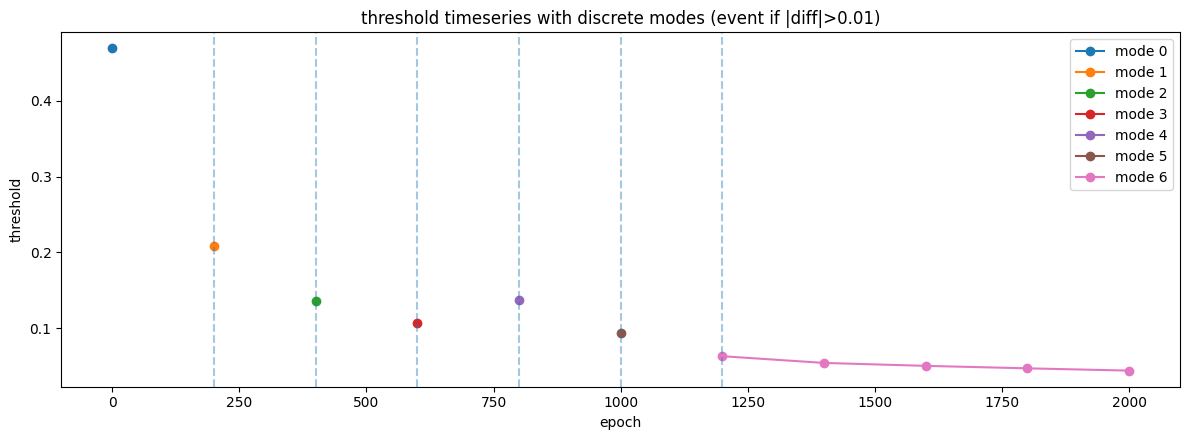

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========
# Config
# =========
EPS_EVENT = 0.01  # |threshold_diff| > EPS_EVENT をイベントとみなす（これまでの基準に合わせる）
IN_TIMESERIES = "/content/threshold_timeseries_with_events.csv"   # あれば優先
IN_EVENTS = "/content/threshold_update_events.csv"                # なければこちらから復元を試みる
OUT_DIR = "stepE_modes"
os.makedirs(OUT_DIR, exist_ok=True)

def build_timeseries_from_events(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    threshold_update_events.csv だけから threshold の時系列を（可能な範囲で）復元する。
    ※ epoch=0 の threshold が events_df に無い場合、threshold_prev から推定する。
    """
    ev = events_df.sort_values("epoch").reset_index(drop=True).copy()

    # epoch=0が無い前提で、最初の行の threshold_prev を epoch=0のthreshold とみなす
    # （あなたの貼り付けでは epoch=200 の threshold_prev が epoch=0 の threshold になっている）
    first_prev = float(ev.loc[0, "threshold_prev"])
    first_epoch = int(ev.loc[0, "epoch"])
    # 0->first_epoch までの点は、観測が無いので epoch=0 と event_epoch だけ持つ最小復元にする
    rows = []
    rows.append({"epoch": 0, "threshold": first_prev})
    for _, r in ev.iterrows():
        rows.append({"epoch": int(r["epoch"]), "threshold": float(r["threshold"])})
    ts = pd.DataFrame(rows).drop_duplicates("epoch").sort_values("epoch").reset_index(drop=True)

    # diffなどを計算
    ts["threshold_prev"] = ts["threshold"].shift(1)
    ts["threshold_diff"] = ts["threshold"] - ts["threshold_prev"]
    ts["abs_threshold_diff"] = ts["threshold_diff"].abs()
    ts["is_event"] = ts["abs_threshold_diff"] > EPS_EVENT
    ts["event_sign"] = np.sign(ts["threshold_diff"]).fillna(0).astype(int)
    return ts

def discretize_modes_by_events(ts: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    is_event（またはEPS基準）で区切って mode を付与する。
    mode_id: 0,1,2,...（イベントが起きるたびに+1）
    """
    df = ts.sort_values("epoch").reset_index(drop=True).copy()

    # is_event が無い場合は diffから作る
    if "threshold_diff" not in df.columns:
        df["threshold_prev"] = df["threshold"].shift(1)
        df["threshold_diff"] = df["threshold"] - df["threshold_prev"]
    if "abs_threshold_diff" not in df.columns:
        df["abs_threshold_diff"] = df["threshold_diff"].abs()
    if "is_event" not in df.columns:
        df["is_event"] = df["abs_threshold_diff"] > EPS_EVENT

    # mode付与（イベント行で mode が切り替わる）
    mode_id = []
    cur = 0
    for i, is_ev in enumerate(df["is_event"].fillna(False).tolist()):
        # i=0は前が無いのでイベント扱いしない
        if i != 0 and bool(is_ev):
            cur += 1
        mode_id.append(cur)
    df["mode_id"] = mode_id

    # mode区間サマリ
    seg = (df.groupby("mode_id")
             .agg(epoch_start=("epoch", "min"),
                  epoch_end=("epoch", "max"),
                  n_points=("epoch", "count"),
                  threshold_level=("threshold", "median"),
                  threshold_min=("threshold", "min"),
                  threshold_max=("threshold", "max"))
             .reset_index())

    return df, seg

# =========
# Load
# =========
if os.path.exists(IN_TIMESERIES):
    ts = pd.read_csv(IN_TIMESERIES)
    # 想定カラム名に寄せる（念のため）
    if "threshold" not in ts.columns and "threshold_value" in ts.columns:
        ts = ts.rename(columns={"threshold_value": "threshold"})
else:
    if not os.path.exists(IN_EVENTS):
        raise FileNotFoundError(f"Neither {IN_TIMESERIES} nor {IN_EVENTS} found.")
    events = pd.read_csv(IN_EVENTS)
    ts = build_timeseries_from_events(events)

# threshold列が無い場合は落とす
if "threshold" not in ts.columns:
    raise ValueError("timeseries CSV must contain 'threshold' column.")

# =========
# Discretize
# =========
ts_mode, mode_segments = discretize_modes_by_events(ts)

# =========
# Save CSV
# =========
out_ts = os.path.join(OUT_DIR, "stepE_threshold_modes.csv")
out_seg = os.path.join(OUT_DIR, "stepE_threshold_mode_segments.csv")
ts_mode.to_csv(out_ts, index=False)
mode_segments.to_csv(out_seg, index=False)
print("[saved]", out_ts)
print("[saved]", out_seg)

# =========
# Plot
# =========
plt.figure(figsize=(12, 4.5))
for m, g in ts_mode.groupby("mode_id"):
    plt.plot(g["epoch"], g["threshold"], marker="o", label=f"mode {m}")

# イベント箇所に縦線（あるなら）
ev_epochs = ts_mode.loc[ts_mode["is_event"].fillna(False), "epoch"].tolist()
for e in ev_epochs:
    plt.axvline(e, linestyle="--", alpha=0.4)

plt.title(f"threshold timeseries with discrete modes (event if |diff|>{EPS_EVENT})")
plt.xlabel("epoch")
plt.ylabel("threshold")
plt.legend()
plt.tight_layout()

out_png = os.path.join(OUT_DIR, "stepE_threshold_modes.png")
plt.savefig(out_png, dpi=150)
print("[saved]", out_png)

# =========
# Quick view
# =========
print("\n[mode segments]")
print(mode_segments)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === inputs ===
ENV_PATH = "/content/island_env_error.csv"
PROF_PATH = "/content/island_profile.csv"
EVENTS_PATH = "/content/threshold_update_events.csv"
THR_TS_PATH = "/content/threshold_timeseries_with_events.csv"  # あれば使う

OUTDIR = "/content/stepE_event_prepost"
os.makedirs(OUTDIR, exist_ok=True)

# === load ===
env = pd.read_csv(ENV_PATH)
prof = pd.read_csv(PROF_PATH)
events = pd.read_csv(EVENTS_PATH)

def pivot_wide(df, value_cols, prefix=""):
    """epoch×island -> epoch行 + (feature_island0, feature_island1, feature_diff_0_minus_1)"""
    wide = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    wide.columns = [f"{prefix}{col}_island{isl}" for col, isl in wide.columns]
    wide = wide.reset_index()

    for col in value_cols:
        c0 = f"{prefix}{col}_island0"
        c1 = f"{prefix}{col}_island1"
        if c0 in wide.columns and c1 in wide.columns:
            wide[f"{prefix}{col}_diff_0_minus_1"] = wide[c0] - wide[c1]
    return wide

env_value_cols = [c for c in env.columns if c not in ["epoch", "island", "n"]]
prof_value_cols = [c for c in prof.columns if c not in ["epoch", "island", "n"]]

env_w = pivot_wide(env, env_value_cols, prefix="env__")
prof_w = pivot_wide(prof, prof_value_cols, prefix="prof__")

feat = env_w.merge(prof_w, on="epoch", how="inner")

# threshold 時系列があるなら結合（任意）
if os.path.exists(THR_TS_PATH):
    thr_ts = pd.read_csv(THR_TS_PATH)
    cols = [c for c in ["epoch", "threshold", "threshold_prev", "threshold_diff", "is_event"] if c in thr_ts.columns]
    feat = feat.merge(thr_ts[cols], on="epoch", how="left")

epoch_list = sorted(feat["epoch"].dropna().unique().tolist())

def prev_epoch(e):
    idx = np.searchsorted(epoch_list, e) - 1
    return epoch_list[idx] if idx >= 0 else None

# numeric columns excluding epoch / bool
num_cols = []
for c in feat.columns:
    if c == "epoch":
        continue
    if pd.api.types.is_bool_dtype(feat[c]):
        continue
    if pd.api.types.is_numeric_dtype(feat[c]):
        num_cols.append(c)

# feature-wise std for z-score
std = feat[num_cols].std(numeric_only=True).replace(0, np.nan)

diff_rows = []
for _, ev in events.iterrows():
    e = int(ev["epoch"])
    pre = prev_epoch(e)
    if pre is None:
        continue

    pre_row = feat.loc[feat["epoch"] == pre, num_cols].iloc[0]
    post_row = feat.loc[feat["epoch"] == e, num_cols].iloc[0]

    diff = post_row - pre_row
    z = diff / std

    tmp = pd.DataFrame({
        "event_epoch": e,
        "pre_epoch": pre,
        "feature": diff.index,
        "pre": pre_row.values,
        "post": post_row.values,
        "diff": diff.values,
        "zscore": z.values
    })
    diff_rows.append(tmp)

diff_long = pd.concat(diff_rows, ignore_index=True)
diff_long["abs_z"] = diff_long["zscore"].abs()

# save long
diff_long.to_csv(f"{OUTDIR}/event_prepost_diff_long.csv", index=False)

# top-k per event
topk = 10
tops = []
for e in sorted(diff_long["event_epoch"].unique()):
    sub = diff_long[diff_long["event_epoch"] == e].sort_values("abs_z", ascending=False).head(topk).copy()
    sub["rank"] = np.arange(1, len(sub) + 1)
    tops.append(sub)
top_long = pd.concat(tops, ignore_index=True)
top_long.to_csv(f"{OUTDIR}/event_prepost_top10_by_absz.csv", index=False)

# per-event plot
for e in sorted(diff_long["event_epoch"].unique()):
    sub = diff_long[diff_long["event_epoch"] == e].sort_values("abs_z", ascending=False).head(12)
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(sub)), sub["zscore"].values)
    plt.xticks(range(len(sub)), sub["feature"].values, rotation=75, ha="right", fontsize=8)
    plt.axhline(0, linewidth=1)
    plt.title(f"Event @ epoch={e}: top changes (z-score) post-pre")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/event_{e}_top_changes_zscore.png", dpi=160)
    plt.close()

# aggregate ranking across events
agg = (
    diff_long.groupby("feature")
    .agg(
        mean_abs_z=("abs_z", "mean"),
        mean_z=("zscore", "mean"),
        max_abs_z=("abs_z", "max"),
        n_events=("event_epoch", "nunique"),
    )
    .reset_index()
    .sort_values("mean_abs_z", ascending=False)
)
agg.to_csv(f"{OUTDIR}/event_prepost_feature_aggregate.csv", index=False)

print("Saved to:", OUTDIR)
print("\nTop features by mean |z| (across events):")
print(agg.head(20).to_string(index=False))


Saved to: /content/stepE_event_prepost

Top features by mean |z| (across events):
                                 feature  mean_abs_z    mean_z  max_abs_z  n_events
             env__err_signed_max_island0    1.481332 -0.386945   2.547687         6
                prof__y_sem_mean_island0    1.401290  0.207980   3.529927         6
             env__err_signed_p90_island0    1.389740  0.428230   2.958300         6
               prof__y_stat_mean_island0    1.349467  0.039905   3.928684         6
         env__err_abs_max_diff_0_minus_1    1.251848  0.306023   2.574751         6
     prof__delta_sun_mean_diff_0_minus_1    1.216631  0.342041   2.066854         6
         env__err_abs_p90_diff_0_minus_1    1.210084  0.298184   2.539583         6
            prof__delta_sun_mean_island0    1.168654  0.389683   2.214835         6
         env__err_abs_p75_diff_0_minus_1    1.133507  0.383141   2.251097         6
               prof__y_stat_mean_island1    1.127115 -0.085782   3.417731     

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, accuracy_score

# === load ===
feat = pd.read_csv("/content/event_prepost_diff_long.csv")  # 使わない
events = pd.read_csv("/content/threshold_update_events.csv")
state = pd.read_csv("/content/threshold_timeseries_with_events.csv")

env = pd.read_csv("/content/island_env_error.csv")
prof = pd.read_csv("/content/island_profile.csv")

# === build wide state ===
def pivot(df, value_cols, prefix):
    w = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    w.columns = [f"{prefix}{c}_island{isl}" for c, isl in w.columns]
    w = w.reset_index()
    for c in value_cols:
        c0 = f"{prefix}{c}_island0"
        c1 = f"{prefix}{c}_island1"
        if c0 in w and c1 in w:
            w[f"{prefix}{c}_diff"] = w[c0] - w[c1]
    return w

env_cols = [c for c in env.columns if c not in ["epoch", "island", "n"]]
prof_cols = [c for c in prof.columns if c not in ["epoch", "island", "n"]]

env_w = pivot(env, env_cols, "env__")
prof_w = pivot(prof, prof_cols, "prof__")

X = env_w.merge(prof_w, on="epoch")

# === label: event at next epoch ===
X["is_event_next"] = X["epoch"].shift(-1).isin(events["epoch"]).astype(int)

# drop last (no next)
X = X.iloc[:-1]

# === features / target ===
y = X["is_event_next"].values
X_feat = X.drop(columns=["epoch", "is_event_next"])

# standardize
X_feat = (X_feat - X_feat.mean()) / (X_feat.std() + 1e-6)
X_feat = X_feat.fillna(0.0)

# === LOO logistic regression ===
loo = LeaveOneOut()
probs = []
preds = []
ys = []

for train, test in loo.split(X_feat):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_feat.iloc[train], y[train])
    p = clf.predict_proba(X_feat.iloc[test])[:, 1][0]
    probs.append(p)
    preds.append(int(p > 0.5))
    ys.append(y[test][0])

print("LOO Accuracy:", accuracy_score(ys, preds))
print("LOO ROC-AUC :", roc_auc_score(ys, probs))


FileNotFoundError: [Errno 2] No such file or directory: '/content/event_prepost_diff_long.csv'

In [ ]:
# 最後に学習したモデルの重みを確認する（どの変数が重要か）
importance = pd.DataFrame({
    "feature": X_feat.columns,
    "coef": clf.coef_[0]
}).sort_values(by="coef", ascending=False)

print(importance.head(10)) # 正の影響が強い変数

NameError: name 'X_feat' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# =========================
# 0) Load
# =========================
thr = pd.read_csv("/content/threshold_timeseries_with_events.csv")
env = pd.read_csv("/content/island_env_error.csv")
prof = pd.read_csv("/content/island_profile.csv")

# 必要列チェック（足りなければCSV生成側と揃えてね）
assert "epoch" in thr.columns
assert "is_event" in thr.columns  # True/False or 0/1
if thr["is_event"].dtype != np.int64 and thr["is_event"].dtype != np.float64:
    # True/False -> 0/1
    thr["is_event"] = thr["is_event"].astype(int)

# =========================
# 1) epoch×island → epoch単位に wide 化（island0/island1 + 差分）
# =========================
def make_wide(df, value_cols, prefix):
    wide = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    wide.columns = [f"{prefix}{col}_island{isl}" for col, isl in wide.columns]
    wide = wide.reset_index()

    # 差分(0-1)も作る（「島間の非対称」が効くことが多いので）
    for col in value_cols:
        c0 = f"{prefix}{col}_island0"
        c1 = f"{prefix}{col}_island1"
        if c0 in wide.columns and c1 in wide.columns:
            wide[f"{prefix}{col}_diff_0_minus_1"] = wide[c0] - wide[c1]
    return wide

env_cols = [c for c in env.columns if c not in ["epoch","island","n"]]
prof_cols = [c for c in prof.columns if c not in ["epoch","island","n"]]

env_w  = make_wide(env,  env_cols,  prefix="env__")
prof_w = make_wide(prof, prof_cols, prefix="prof__")

feat = env_w.merge(prof_w, on="epoch", how="inner")

# =========================
# 2) 「イベント直前の状態」だけで予測するデータセットを作る
#    y(t)=is_event(t) を、X(t-)=features(epoch_prev) で当てる
# =========================
epochs = sorted(feat["epoch"].unique().tolist())
epoch_to_prev = {epochs[i]: (epochs[i-1] if i > 0 else None) for i in range(len(epochs))}

rows = []
for _, r in thr.iterrows():
    e = int(r["epoch"])
    if e not in epoch_to_prev:
        continue
    pre = epoch_to_prev[e]
    if pre is None:
        continue  # epoch=0 は直前がないので除外
    # Xは "pre epoch" の特徴
    pre_row = feat.loc[feat["epoch"] == pre]
    if len(pre_row) != 1:
        continue
    x = pre_row.drop(columns=["epoch"]).iloc[0].to_dict()
    rows.append({
        "event_epoch": e,
        "pre_epoch": pre,
        "y_event": int(r["is_event"]),
        **{f"Xprev__{k}": v for k, v in x.items()}
    })

ds = pd.DataFrame(rows)

# 学習に使う特徴量
X_cols = [c for c in ds.columns if c.startswith("Xprev__")]
X = ds[X_cols].copy()
y = ds["y_event"].values

# 欠損のある列は落とす（または補完しても良い）
ok_cols = [c for c in X_cols if X[c].isna().sum() == 0]
X = X[ok_cols]

print("dataset:", ds.shape, "X:", X.shape, "y_event rate:", y.mean())

# =========================
# 3) LOOで評価（L1ロジスティック：解釈向き）
# =========================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=1.0,
        max_iter=10000,
        class_weight="balanced",
        random_state=0,
    ))
])

loo = LeaveOneOut()
proba = np.zeros(len(ds))
pred  = np.zeros(len(ds), dtype=int)

# 係数の安定性を見るため、各foldの係数も保存
coef_list = []

for tr_idx, te_idx in loo.split(X):
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr = y[tr_idx]
    pipe.fit(Xtr, ytr)
    proba[te_idx[0]] = pipe.predict_proba(Xte)[0,1]
    pred[te_idx[0]] = int(proba[te_idx[0]] >= 0.5)

    # fold係数
    clf = pipe.named_steps["clf"]
    coef_list.append(clf.coef_[0])

acc = accuracy_score(y, pred)

# ROC-AUCは「両クラスが存在する」ことが必要
auc = roc_auc_score(y, proba) if len(np.unique(y)) == 2 else np.nan

print("LOO Accuracy:", acc)
print("LOO ROC-AUC :", auc)

# 予測結果保存
out_pred = ds[["event_epoch","pre_epoch","y_event"]].copy()
out_pred["p_event"] = proba
out_pred["y_pred"]  = pred
out_pred.to_csv("stepA_event_linear_loo_preds.csv", index=False)

# =========================
# 4) “効いてる軸”を係数で出す
#    - 全データでfitした係数
#    - LOO係数の平均＆分散（安定性）
# =========================
pipe.fit(X, y)
coef_full = pipe.named_steps["clf"].coef_[0]

coef_arr = np.vstack(coef_list)
coef_mean = coef_arr.mean(axis=0)
coef_std  = coef_arr.std(axis=0)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef_full": coef_full,
    "coef_loo_mean": coef_mean,
    "coef_loo_std": coef_std,
    "abs_coef_loo_mean": np.abs(coef_mean),
})
coef_df = coef_df.sort_values("abs_coef_loo_mean", ascending=False)
coef_df.to_csv("stepA_event_linear_coeffs.csv", index=False)

print("\nTop axes (by |coef_loo_mean|):")
print(coef_df.head(20)[["feature","coef_loo_mean","coef_loo_std"]])

# =========================
# 5) 可視化（上位だけ）
# =========================
topk = min(20, len(coef_df))
sub = coef_df.head(topk).iloc[::-1]  # 反転して見やすく

plt.figure(figsize=(10, 6))
plt.barh(range(len(sub)), sub["coef_loo_mean"].values)
plt.yticks(range(len(sub)), sub["feature"].values, fontsize=8)
plt.axvline(0, linewidth=1)
plt.title("Event (mode transition) predictors: LOO-mean coefficients (LogReg L1)")
plt.tight_layout()
plt.savefig("stepA_event_linear_coeffs.png", dpi=160)
plt.close()

print("\nSaved:",
      "stepA_event_linear_loo_preds.csv, stepA_event_linear_coeffs.csv, stepA_event_linear_coeffs.png")


dataset: (10, 192) X: (10, 189) y_event rate: 0.6
LOO Accuracy: 0.8
LOO ROC-AUC : 0.9583333333333334

Top axes (by |coef_loo_mean|):
                                     feature  coef_loo_mean  coef_loo_std
179  Xprev__prof__attn_mean_0_diff_0_minus_1      -0.804540      0.252375
143         Xprev__prof__attn_mean_1_island0       0.720365      0.432913
151         Xprev__prof__attn_mean_5_island0      -0.299842      0.401536
142         Xprev__prof__attn_mean_0_island1       0.105640      0.316919
18        Xprev__env__err_signed_max_island0       0.078742      0.236225
145         Xprev__prof__attn_mean_2_island0       0.029539      0.088618
34        Xprev__env__err_signed_std_island0       0.019145      0.057434
180  Xprev__prof__attn_mean_1_diff_0_minus_1       0.014717      0.044150
181  Xprev__prof__attn_mean_2_diff_0_minus_1       0.006077      0.018230
5            Xprev__env__err_abs_min_island1       0.000000      0.000000
1            Xprev__env__err_abs_max_island1       0.

In [ ]:
!python stepF_sign_event_linear.py

Saved outputs to: stepF_sign_event_linear
Binary event model: see stepF_event_binary_metrics.txt / coeffs.csv / png
Sign model (events only): see stepF_event_sign_metrics.txt / coeffs.csv / png (if trained)


In [ ]:
!python stepG_feature_stability.py

[done] outputs saved to: stepG_outputs


# 状態系列クラスタの確認

In [ ]:
# stepH_state_trajectory_cluster.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

WINDOW = 2  # 前後 epoch
N_CLUSTERS = 3

# load
thr = pd.read_csv("threshold_timeseries_with_events.csv")
env = pd.read_csv("island_env_error.csv")
prof = pd.read_csv("island_profile.csv")

# merge minimal state
# Merge env and prof first (they both have 'island' column)
df_merged_island = env.merge(prof, on=["epoch", "island"], how="inner")

# Now merge with thr (which is epoch-level and doesn't have 'island')
# The 'threshold' will be broadcasted to both islands for each epoch
df = thr.merge(df_merged_island, on="epoch", how="inner")

# pick island-aggregated features
def state_vector(epoch):
    row0 = df[(df.epoch == epoch) & (df.island == 0)].iloc[0]
    row1 = df[(df.epoch == epoch) & (df.island == 1)].iloc[0]
    return np.array([
        row0["threshold"],
        row0["env__err_abs_mean_island0"], row1["env__err_abs_mean_island0"],
        row0["prof__attn_mass_6_island0"], row1["prof__attn_mass_6_island0"],
    ])

# extract event-centered trajectories
events = thr[thr["is_event"] == True]["epoch"].unique()
trajectories = []

for t in events:
    seq = []
    for dt in range(-WINDOW, WINDOW + 1):
        ep = t + dt
        if ep in df["epoch"].values:
            seq.append(state_vector(ep))
    if len(seq) == 2 * WINDOW + 1:
        trajectories.append(np.concatenate(seq))

X = np.vstack(trajectories)
X = StandardScaler().fit_transform(X)


FileNotFoundError: [Errno 2] No such file or directory: 'threshold_timeseries_with_events.csv'

In [ ]:
# clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=0)
labels = kmeans.fit_predict(X)

print("silhouette:", silhouette_score(X, labels))

# visualize
from sklearn.decomposition import PCA
Z = PCA(2).fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10")
plt.title("State-trajectory clusters")
plt.show()


NameError: name 'X' is not defined

# ε-event embedding

In [ ]:
!python step2_epsilon_event_embedding.py

[ok] saved to: step2_epsilon_event_embedding
[ok] events: 6 | emb_dim=6
[ok] files:
 - epsilon_event_embeddings.csv
 - epsilon_event_features_pre_only.csv
 - epsilon_event_features_pre_plus_delta.csv
 - epsilon_event_embedding_meta.json


In [ ]:
!python step_state_series_cluster_B.py --window 5 --stride 1 --k 3

[ok] saved to: stepB_state_series_clustering
  epochs in state table: 11
  trajectories: 6  dim: 1005
  chosen k: 3


In [ ]:
!python stepH_semantic_cluster_alignment.py

Traceback (most recent call last):
  File "/content/stepH_semantic_cluster_alignment.py", line 195, in <module>
    main()
  File "/content/stepH_semantic_cluster_alignment.py", line 89, in main
    traj, assign, X = load_run(r)
                      ^^^^^^^^^^^
  File "/content/stepH_semantic_cluster_alignment.py", line 43, in load_run
    traj = pd.read_csv(path_for(run, "traj"))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                

In [ ]:
!python step_label_lr_proposal.py

Traceback (most recent call last):
  File "/content/step_label_lr_proposal.py", line 90, in <module>
    main()
  File "/content/step_label_lr_proposal.py", line 35, in main
    aligned = pd.read_csv(ALIGNED_PATH)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
   

In [ ]:
!python stepLR_cluster_eventrate.py --run_dir runs_for_analysis/run1 --mode conservative

# 学習からファイル出しまでの一括化

In [ ]:
!RUN_ID=test1 python train.py

device: cuda
[RUN] RUN_ID=test1
[RUN] RUN_DIR=runs/test1
[LR] table not found: runs/test1/lr_mult_by_epoch.csv (disable)
[LR] disabled (no valid lr table)
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/test1/islands/island_epoch00000.pt
[0] L_real_mix=0.2048 L_real_sem=100.6313 L_cf_s0=0.6337 L_cf_p0=0.6364 L_mono=0.0000 L_cos=0.0559 H_I=0.8286 L_env=0.0000 L_self=0.1115 L_rev=0.6706 mse_s=0.3648 mse_p=0.2940 mse=0.3294 rev_abs_mean=0.0811 rev_std=0.0724 self_mass=0.1415 Val_sem=92.1372
   [MON-TR] y_mean=0.7802 y_std=0.0040 y_min=0.7705 y_max=0.7873 corr=0.7122 m_real=0.7802 m_s0=0.7749 m_p0=0.7762 gap_s=0.0052 gap_p=0.0039 ratio_s=0.9933 ratio_p=0.9950 env_sum=0.4349 I_sum=0.4235 self=0.1416 H_I=0.8291
   [MON-VA] y_mean=0.7802 y_std=0.0039 y_min=0.7706 y_max=0.7870 corr=0.7050 m_real=0.7802 m_s0=0.7751 m_p0=0.7761 gap_s=0.0051 gap_p=0.0041 ratio_s=0.9935 ratio_p=0.9948 env_sum=0.4349 I_sum=0.4235 self=0.1416 H_I=0.8291
[LR] epoch=200 mult=1.0000 lr=0.001
   [ISLA

In [ ]:
!RUN_ID=test1 python stepLR_cluster_eventrate.py --min_points 3

[saved]
 - runs/test1/lr_mult_by_cluster.csv
 - runs/test1/lr_mult_by_epoch.csv

[preview lr_mult_by_cluster]
 cluster_label  n_points  n_events  event_rate  lr_mult  guarded
             1         1         1        1.00    1.000     True
             2         1         1        1.00    1.000     True
             0         8         2        0.25    1.025    False


In [ ]:
!RUN_ID=test1 python train.py

device: cuda
[RUN] RUN_ID=test1
[RUN] RUN_DIR=runs/test1
[LR] using lr schedule table: runs/test1/lr_mult_by_epoch.csv
[LR] table preview (head):
epoch
0      1.000
200    1.025
400    1.000
600    1.025
800    1.000
[LR] table preview (tail):
epoch
1200    1.025
1400    1.025
1600    1.025
1800    1.025
2000    1.025
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/test1/islands/island_epoch00000.pt
[0] L_real_mix=0.1867 L_real_sem=95.0556 L_cf_s0=0.5381 L_cf_p0=0.5312 L_mono=0.0000 L_cos=0.1362 H_I=0.8309 L_env=0.0000 L_self=0.1124 L_rev=0.7735 mse_s=0.2629 mse_p=0.1901 mse=0.2265 rev_abs_mean=0.0795 rev_std=0.0506 self_mass=0.1424 Val_sem=93.4916
   [MON-TR] y_mean=0.7148 y_std=0.0063 y_min=0.6980 y_max=0.7270 corr=0.8696 m_real=0.7148 m_s0=0.7107 m_p0=0.7071 gap_s=0.0041 gap_p=0.0077 ratio_s=0.9942 ratio_p=0.9892 env_sum=0.4333 I_sum=0.4246 self=0.1420 H_I=0.8302
   [MON-VA] y_mean=0.7150 y_std=0.0063 y_min=0.6987 y_max=0.7267 corr=0.8623 m_real=0.7150 m_s0=0.7108

In [ ]:
!python island_min_stats.py --run_dir runs/test1 --epochs 200 400 600 1400 1600


=== island min stats (selected epochs) ===
 epoch  alpha_used  stat_mean  stat_std  corr_stat_y  sem_mean  sem_std  corr_sem_y  mix_mean  mix_std  corr_mix_y  delta_sun0_mean  delta_sun0_abs_mean  delta_plant0_mean  delta_plant0_abs_mean  attn_entropy                                            attn_mean_vec  attn_self_mass_proxy  corr_Ienv_plant  corr_Ienv_sun  corr_Ienv_water  corr_plant_vs_sunI  corr_plant_vs_waterI  corr_sun_vs_plantI  corr_water_vs_plantI
   200    0.500000   0.798978  0.307853     0.966367  0.531822 0.419320    0.885792  0.665400 0.358585    0.932734         0.254076             0.254076           0.493572               0.493572      1.925331 [0.1152, 0.1208, 0.1199, 0.1863, 0.1826, 0.1336, 0.1416]              0.141616         0.891767       0.385423         0.856323            0.126225              0.164253            0.152698              0.385521
   400    0.988243   3.500586  0.675910     0.966224  0.555174 0.419392    0.921236  0.589803 0.421793    0.923425

# 島の分析

explained_variance_ratio (PC1,PC2): [0.82976717 0.11601112]
[epoch 400] corr(PC1, plant/sun/water)=+0.999, +0.055, -0.040
[epoch 400] corr(PC2, plant/sun/water)=+0.230, -0.315, -0.913


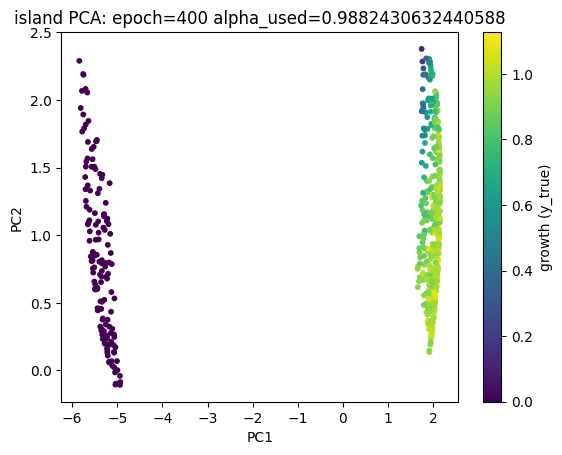

[epoch 1600] corr(PC1, plant/sun/water)=+0.996, +0.097, -0.038
[epoch 1600] corr(PC2, plant/sun/water)=-0.050, -0.481, -0.848


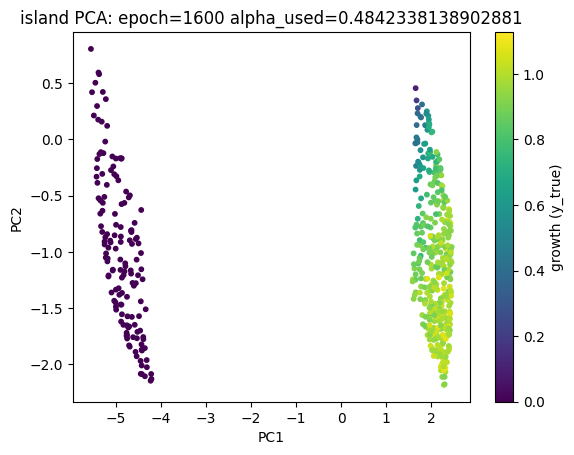

In [5]:
# pca_island_compare.py (or notebook cell)

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

def load_island(pt_path: str):
    pt_path = Path(pt_path)
    d = torch.load(pt_path, map_location="cpu")
    # 必須っぽいキー
    I = d["I"]            # (n,3,D) 期待
    env = d.get("env")    # (n,3) plant,sun,water
    y = d.get("y_true")   # (n,)
    attn = d.get("attn")  # (n,7) growth row attention
    alpha_used = d.get("alpha_used", None)
    epoch = d.get("epoch", None)

    I = I.detach().float()
    if I.ndim == 3:
        X = I.reshape(I.shape[0], -1)  # (n, 3*D)
    elif I.ndim == 2:
        X = I
    else:
        raise ValueError(f"Unexpected I shape: {tuple(I.shape)}")

    out = {
        "path": str(pt_path),
        "epoch": int(epoch) if epoch is not None else None,
        "alpha_used": float(alpha_used) if alpha_used is not None else None,
        "X": X.numpy(),
        "env": env.detach().float().numpy() if env is not None else None,
        "y": y.detach().float().numpy() if y is not None else None,
        "attn": attn.detach().float().numpy() if attn is not None else None,
    }
    return out

def fit_pca_2d(X_all: np.ndarray):
    # sklearn があればそれを使う（なければ SVD で代替）
    try:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, random_state=0)
        Z = pca.fit_transform(X_all)
        return pca, Z
    except Exception as e:
        # SVD 版 PCA（中心化のみ）
        Xc = X_all - X_all.mean(axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        Z = U[:, :2] * S[:2]
        class _PCA:
            explained_variance_ratio_ = (S[:2]**2) / (S**2).sum()
            components_ = Vt[:2]
        return _PCA(), Z

def plot_epoch(Z, info, idx_slice):
    Zi = Z[idx_slice]
    y = info["y"]
    env = info["env"]

    plt.figure()
    if y is not None:
        plt.scatter(Zi[:,0], Zi[:,1], c=y, s=10)
        plt.colorbar(label="growth (y_true)")
    else:
        plt.scatter(Zi[:,0], Zi[:,1], s=10)

    title = f"island PCA: epoch={info['epoch']} alpha_used={info['alpha_used']}"
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # 参考として env の相関を軽く出す（表示だけ）
    if env is not None:
        plant, sun, water = env[:,0], env[:,1], env[:,2]
        # PC と env の相関（符号は任意なので強さだけ見る）
        corr = lambda a,b: float(np.corrcoef(a,b)[0,1])
        pc1, pc2 = Zi[:,0], Zi[:,1]
        print(f"[epoch {info['epoch']}] corr(PC1, plant/sun/water)="
              f"{corr(pc1,plant):+.3f}, {corr(pc1,sun):+.3f}, {corr(pc1,water):+.3f}")
        print(f"[epoch {info['epoch']}] corr(PC2, plant/sun/water)="
              f"{corr(pc2,plant):+.3f}, {corr(pc2,sun):+.3f}, {corr(pc2,water):+.3f}")

    plt.show()

# ---- ここをあなたのパスに合わせて変更 ----
pt_400  = "runs/test1/islands/island_epoch00400.pt"
pt_1600 = "runs/test1/islands/island_epoch01600.pt"

a = load_island(pt_400)
b = load_island(pt_1600)

# PCA は「2 epoch を結合して同一基底」で比較する
Xa, Xb = a["X"], b["X"]
X_all = np.vstack([Xa, Xb])

pca, Z_all = fit_pca_2d(X_all)
Za = Z_all[:len(Xa)]
Zb = Z_all[len(Xa):]

print("explained_variance_ratio (PC1,PC2):",
      getattr(pca, "explained_variance_ratio_", None))

# それぞれ別図で表示（サブプロット無し）
plot_epoch(Za, a, slice(0, len(Xa)))
plot_epoch(Zb, b, slice(0, len(Xb)))


explained_variance_ratio (PC1,PC2): [0.82976717 0.11601112]
[epoch 400] corr(PC1, plant/sun/water)=+0.999, +0.055, -0.040
[epoch 400] corr(PC2, plant/sun/water)=+0.230, -0.315, -0.913
[epoch 1600] corr(PC1, plant/sun/water)=+0.996, +0.097, -0.038
[epoch 1600] corr(PC2, plant/sun/water)=-0.050, -0.481, -0.848


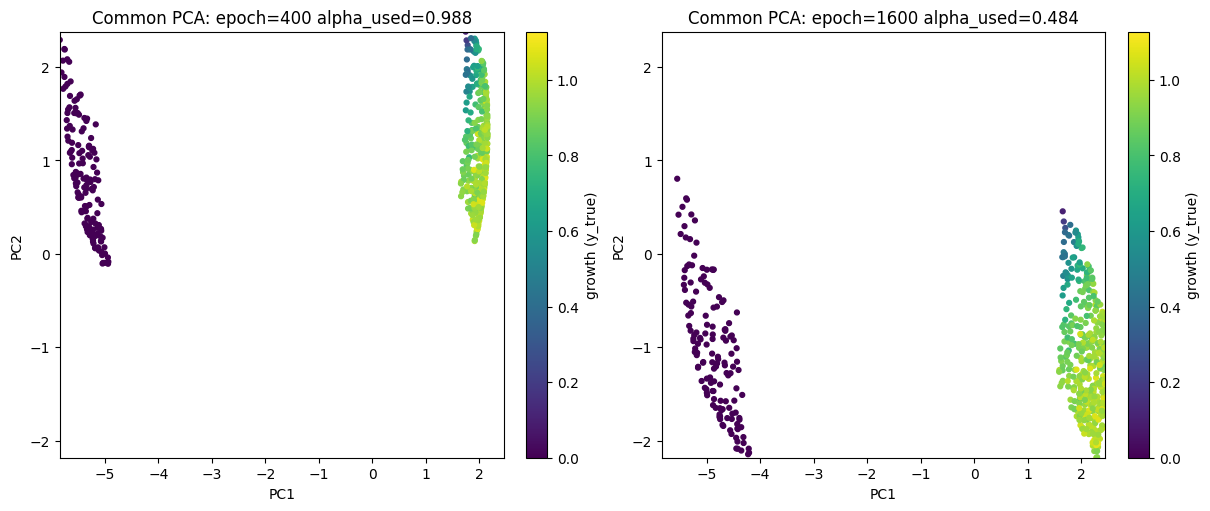

In [6]:
# common_pca_island.py
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_island(pt_path: str):
    d = torch.load(pt_path, map_location="cpu")
    # I: (n,3,D) か (n,3,D?) の想定。最終的に (n, 3*D) に潰す
    I = d["I"]
    if isinstance(I, torch.Tensor):
        I = I.detach().cpu()
    else:
        I = torch.tensor(I)

    if I.dim() == 3:
        n, k, D = I.shape
        X = I.reshape(n, k * D)
    elif I.dim() == 2:
        # すでに (n, F) ならそのまま
        X = I
    else:
        raise ValueError(f"Unexpected I shape: {tuple(I.shape)}")

    env = d["env"]  # (n,3) plant/sun/water
    if isinstance(env, torch.Tensor):
        env = env.detach().cpu().numpy()
    else:
        env = np.asarray(env)

    y = d["y_true"]
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    else:
        y = np.asarray(y)

    epoch = int(d.get("epoch", -1))
    alpha_used = float(d.get("alpha_used", float("nan")))
    return epoch, alpha_used, X.numpy(), env, y

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std() * b0.std()) + 1e-12
    return float((a0 * b0).mean() / denom)

def main():
    run_dir = Path("runs/test1/islands")
    p400  = run_dir / "island_epoch00400.pt"
    p1600 = run_dir / "island_epoch01600.pt"

    e1, a1, X1, env1, y1 = load_island(str(p400))
    e2, a2, X2, env2, y2 = load_island(str(p1600))

    # ---- 共通PCA（concat-fit）----
    X_all = np.concatenate([X1, X2], axis=0)
    pca = PCA(n_components=2, random_state=0)
    Z_all = pca.fit_transform(X_all)

    Z1 = pca.transform(X1)
    Z2 = pca.transform(X2)

    print("explained_variance_ratio (PC1,PC2):", pca.explained_variance_ratio_)

    # env 相関（確認用）
    for (epoch, Z, env) in [(e1, Z1, env1), (e2, Z2, env2)]:
        plant, sun, water = env[:,0], env[:,1], env[:,2]
        print(f"[epoch {epoch}] corr(PC1, plant/sun/water)={corr(Z[:,0],plant):+.3f}, {corr(Z[:,0],sun):+.3f}, {corr(Z[:,0],water):+.3f}")
        print(f"[epoch {epoch}] corr(PC2, plant/sun/water)={corr(Z[:,1],plant):+.3f}, {corr(Z[:,1],sun):+.3f}, {corr(Z[:,1],water):+.3f}")

    # ---- 同一軸範囲で描画 ----
    x_min = min(Z1[:,0].min(), Z2[:,0].min())
    x_max = max(Z1[:,0].max(), Z2[:,0].max())
    y_min = min(Z1[:,1].min(), Z2[:,1].min())
    y_max = max(Z1[:,1].max(), Z2[:,1].max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    sc1 = axes[0].scatter(Z1[:,0], Z1[:,1], c=y1, s=12)
    axes[0].set_title(f"Common PCA: epoch={e1} alpha_used={a1:.3f}")
    axes[0].set_xlim(x_min, x_max); axes[0].set_ylim(y_min, y_max)
    axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
    fig.colorbar(sc1, ax=axes[0], label="growth (y_true)")

    sc2 = axes[1].scatter(Z2[:,0], Z2[:,1], c=y2, s=12)
    axes[1].set_title(f"Common PCA: epoch={e2} alpha_used={a2:.3f}")
    axes[1].set_xlim(x_min, x_max); axes[1].set_ylim(y_min, y_max)
    axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
    fig.colorbar(sc2, ax=axes[1], label="growth (y_true)")

    plt.show()

if __name__ == "__main__":
    main()


explained_variance_ratio: [0.82976717 0.11601112]


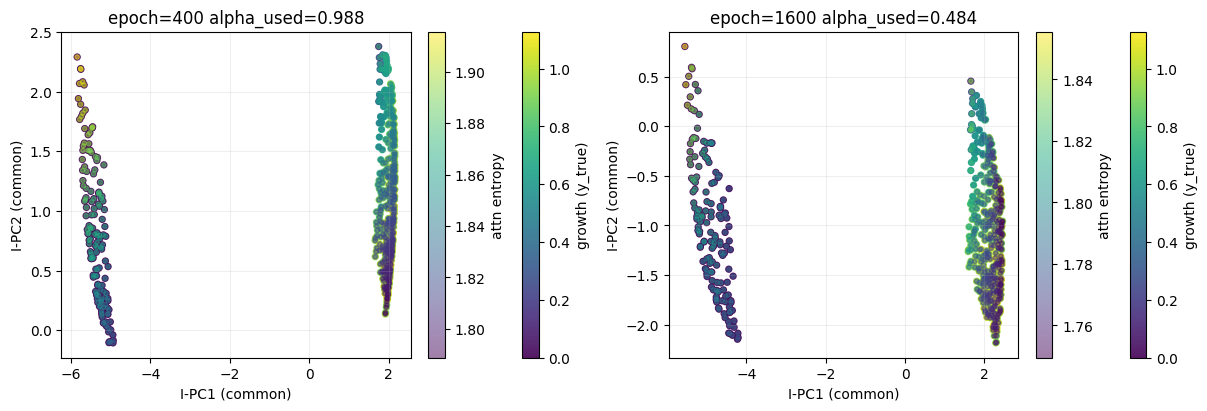

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

def soft_entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    p = p / p.sum(axis=-1, keepdims=True)
    return -(p * np.log(p)).sum(axis=-1)

def load_island(pt_path):
    d = torch.load(pt_path, map_location="cpu")
    # env: (n,3)  [plant,sun,water]
    env = d["env"].cpu().numpy()
    y = d["y_true"].cpu().numpy()
    I = d["I"].cpu().numpy()              # (n,3,D) or similar
    attn = d["attn_growth_row"].cpu().numpy()  # (n,7)
    alpha_used = float(d.get("alpha_used", np.nan))
    epoch = int(d.get("epoch", -1))
    # flatten I to (n, 3*D)
    I_flat = I.reshape(I.shape[0], -1)
    return epoch, alpha_used, env, y, I_flat, attn

# ---- paths ----
run_dir = Path("runs/test1/islands")
pt400 = run_dir / "island_epoch00400.pt"
pt1600 = run_dir / "island_epoch01600.pt"

e1, a1, env1, y1, I1, attn1 = load_island(pt400)
e2, a2, env2, y2, I2, attn2 = load_island(pt1600)

# ---- common PCA on I ----
X = np.vstack([I1, I2])
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

Z1 = Z[:len(I1)]
Z2 = Z[len(I1):]

print("explained_variance_ratio:", pca.explained_variance_ratio_)

def plot_overlay(ax, Z, env, y, attn, title):
    plant, sun, water = env[:,0], env[:,1], env[:,2]

    # attention features
    attn_self = attn[:, 6]
    attn_env_sum = attn[:, :3].sum(axis=1)
    ent = soft_entropy(attn)

    # base scatter: color by y_true
    sc = ax.scatter(Z[:,0], Z[:,1], c=y, s=18, alpha=0.9)
    plt.colorbar(sc, ax=ax, label="growth (y_true)")

    # overlay 1: marker size by attn_env_sum (envへの集中度)
    # scale a bit for visibility
    s = 20 + 120 * (attn_env_sum - attn_env_sum.min()) / (np.ptp(attn_env_sum) + 1e-9)
    ax.scatter(Z[:,0], Z[:,1], s=s, facecolors="none", linewidths=0.8, alpha=0.6)

    # overlay 2: edge color by attn_entropy（集中→低entropy / 分散→高entropy）
    # Matplotlibのedgecolorはscatter単体ではやや面倒なので、entropyを別レイヤで色付けする
    sc2 = ax.scatter(Z[:,0], Z[:,1], c=ent, s=10, alpha=0.5)
    plt.colorbar(sc2, ax=ax, label="attn entropy")

    ax.set_title(title)
    ax.set_xlabel("I-PC1 (common)")
    ax.set_ylabel("I-PC2 (common)")
    ax.grid(True, alpha=0.2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_overlay(axes[0], Z1, env1, y1, attn1, f"epoch={e1} alpha_used={a1:.3f}")
plot_overlay(axes[1], Z2, env2, y2, attn2, f"epoch={e2} alpha_used={a2:.3f}")
plt.show()

In [8]:
import pandas as pd

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    if a.std() < 1e-12 or b.std() < 1e-12:
        return np.nan
    return float(np.corrcoef(a, b)[0,1])

def attn_features(attn):
    feat = {}
    feat["attn_plant"] = attn[:,0]
    feat["attn_sun"]   = attn[:,1]
    feat["attn_water"] = attn[:,2]
    feat["attn_env_sum"] = attn[:,:3].sum(axis=1)
    feat["attn_self"]  = attn[:,6]
    feat["attn_entropy"] = soft_entropy(attn)
    return feat

def summarize(epoch, Z, env, y, attn):
    f = attn_features(attn)
    out = {"epoch": epoch}
    out["corr(PC1,y)"] = corr(Z[:,0], y)
    out["corr(PC2,y)"] = corr(Z[:,1], y)
    for k,v in f.items():
        out[f"corr(PC1,{k})"] = corr(Z[:,0], v)
        out[f"corr(PC2,{k})"] = corr(Z[:,1], v)
        out[f"corr(y,{k})"]   = corr(y, v)
    return out

rows = [
    summarize(e1, Z1, env1, y1, attn1),
    summarize(e2, Z2, env2, y2, attn2),
]
df = pd.DataFrame(rows)
print(df.T)


                                 0            1
epoch                   400.000000  1600.000000
corr(PC1,y)               0.956544     0.960758
corr(PC2,y)               0.053805    -0.232932
corr(PC1,attn_plant)     -0.971756     0.478226
corr(PC2,attn_plant)      0.002480     0.764344
corr(y,attn_plant)       -0.948208     0.347375
corr(PC1,attn_sun)       -0.445703    -0.610564
corr(PC2,attn_sun)        0.498291     0.504300
corr(y,attn_sun)         -0.560669    -0.682176
corr(PC1,attn_water)     -0.321581    -0.802032
corr(PC2,attn_water)      0.815564     0.071368
corr(y,attn_water)       -0.423631    -0.778654
corr(PC1,attn_env_sum)   -0.762617    -0.502573
corr(PC2,attn_env_sum)    0.448803     0.781511
corr(y,attn_env_sum)     -0.822801    -0.608443
corr(PC1,attn_self)      -0.779595    -0.814018
corr(PC2,attn_self)       0.440832     0.645442
corr(y,attn_self)        -0.838049    -0.855355
corr(PC1,attn_entropy)   -0.689601    -0.662028
corr(PC2,attn_entropy)    0.556087     0

In [9]:
import torch

RUN_DIR = "runs/test1/islands"
epoch = 400

pt = torch.load(f"{RUN_DIR}/island_epoch{epoch:05d}.pt", map_location="cpu")
print("keys:", sorted(pt.keys()))

# 形状も確認（Tensorだけ）
for k in ["attn", "attn_growth_row", "attn_growth_row", "I", "env", "y_true", "y_mix", "y_stat", "y_sem"]:
    if k in pt:
        v = pt[k]
        print(k, type(v), getattr(v, "shape", None))


keys: ['I', 'alpha_used', 'attn', 'attn_growth_row', 'env', 'epoch', 'growth', 'model_state', 'plant', 'sun', 'water', 'y_mix', 'y_plant0_mix', 'y_plant0_sem', 'y_plant0_stat', 'y_sem', 'y_stat', 'y_sun0_mix', 'y_sun0_sem', 'y_sun0_stat', 'y_true']
attn <class 'torch.Tensor'> torch.Size([512, 7])
attn_growth_row <class 'torch.Tensor'> torch.Size([512, 7])
attn_growth_row <class 'torch.Tensor'> torch.Size([512, 7])
I <class 'torch.Tensor'> torch.Size([512, 3, 32])
env <class 'torch.Tensor'> torch.Size([512, 3])
y_true <class 'torch.Tensor'> torch.Size([512])
y_mix <class 'torch.Tensor'> torch.Size([512])
y_stat <class 'torch.Tensor'> torch.Size([512])
y_sem <class 'torch.Tensor'> torch.Size([512])


In [10]:
import numpy as np
import torch
from sklearn.decomposition import PCA

RUN_ISLAND_DIR = "runs/test1/islands"
EPOCHS = [400, 1600]  # 必要なepochだけ

def load_I_and_attn(epoch):
    pt = torch.load(f"{RUN_ISLAND_DIR}/island_epoch{epoch:05d}.pt", map_location="cpu")

    # --- attention (n,7) ---
    if "attn" in pt:
        A = pt["attn"].numpy()
    elif "attn_growth_row" in pt:
        A = pt["attn_growth_row"].numpy()
    else:
        raise KeyError(f"no attn key. available keys: {sorted(pt.keys())}")

    # --- I (n,3,D) -> flatten (n, 3D) ---
    I = pt["I"].numpy()
    I_flat = I.reshape(I.shape[0], -1)

    # y (n,)
    y = pt["y_true"].numpy()

    return I_flat, A, y, pt

# --- load & concat ---
I_all, A_all = [], []
meta = []
for ep in EPOCHS:
    I_flat, A, y, pt = load_I_and_attn(ep)
    I_all.append(I_flat)
    A_all.append(A)
    meta.append((ep, I_flat.shape[0]))

I_all = np.concatenate(I_all, axis=0)  # (sum_n, 3D)
A_all = np.concatenate(A_all, axis=0)  # (sum_n, 7)

# --- common PCA ---
pca_I = PCA(n_components=2).fit(I_all)
pca_A = PCA(n_components=2).fit(A_all)

print("I explained_variance_ratio:", pca_I.explained_variance_ratio_)
print("A explained_variance_ratio:", pca_A.explained_variance_ratio_)

# --- per-epoch transform + corr ---
def corr(a,b):
    a = a.reshape(-1); b = b.reshape(-1)
    a = a - a.mean(); b = b - b.mean()
    return float((a*b).mean() / (a.std()+1e-9) / (b.std()+1e-9))

offset = 0
rows = []
for ep, n in meta:
    I_flat, A, y, _ = load_I_and_attn(ep)
    I_pc = pca_I.transform(I_flat)  # (n,2)
    A_pc = pca_A.transform(A)       # (n,2)

    rows.append({
        "epoch": ep,
        "corr(attn_PC1, I_PC1)": corr(A_pc[:,0], I_pc[:,0]),
        "corr(attn_PC1, I_PC2)": corr(A_pc[:,0], I_pc[:,1]),
        "corr(attn_PC2, I_PC1)": corr(A_pc[:,1], I_pc[:,0]),
        "corr(attn_PC2, I_PC2)": corr(A_pc[:,1], I_pc[:,1]),
    })

import pandas as pd
df = pd.DataFrame(rows).set_index("epoch")
print(df)


I explained_variance_ratio: [0.82976717 0.11601112]
A explained_variance_ratio: [0.87053716 0.06965988]
       corr(attn_PC1, I_PC1)  corr(attn_PC1, I_PC2)  corr(attn_PC2, I_PC1)  \
epoch                                                                        
400                 0.602854              -0.636095               0.773076   
1600               -0.898406               0.033315              -0.179596   

       corr(attn_PC2, I_PC2)  
epoch                         
400                -0.352901  
1600               -0.398791  


In [11]:
# attn_common_pca_and_loadings.py
from pathlib import Path
import torch
import numpy as np
from sklearn.decomposition import PCA

# ---- 7次元 attention の各次元ラベル（あなたのコードの意味に合わせて調整OK）----
# attn は「growth query 行（head平均）」で、列は 7トークンへの注意。
# 例: [plant, sun, water, (他の内部/補助トークン...), self/growth ...] のような並び。
# ※正確な並びは model 側のトークン順に依存します。
ATTN_LABELS = ["plant","sun","water","I1","I2","I3","growth(self)"]

def load_attn(pt_path: str, key: str = "attn"):
    d = torch.load(pt_path, map_location="cpu")
    if key not in d:
        raise KeyError(f"'{key}' not found. available keys: {sorted(list(d.keys()))}")

    A = d[key]  # (n,7)
    if not isinstance(A, torch.Tensor):
        A = torch.tensor(A)
    A = A.detach().cpu().numpy()

    epoch = int(d.get("epoch", -1))
    alpha_used = float(d.get("alpha_used", float("nan")))
    return epoch, alpha_used, A

def print_loadings(pca_obj: PCA, labels):
    # components_: (n_components, n_features)
    comps = pca_obj.components_
    for pc in range(comps.shape[0]):
        v = comps[pc]
        order = np.argsort(-np.abs(v))
        print(f"\n=== attn PC{pc+1} loadings (sorted by |loading|) ===")
        for j in order:
            lab = labels[j] if j < len(labels) else f"dim{j}"
            print(f"{lab:>8s}: {v[j]:+.4f}")
        print(f"  (sum abs) {np.abs(v).sum():.4f} / (L2) {np.linalg.norm(v):.4f}")


run_dir = Path("runs/test1/islands")
p400  = run_dir / "island_epoch00400.pt"
p1600 = run_dir / "island_epoch01600.pt"

e1, a1, A1 = load_attn(str(p400), key="attn")   # or "attn_growth_row" でも同じはず
e2, a2, A2 = load_attn(str(p1600), key="attn")

# ---- 共通PCA（concat-fit）----
A_all = np.concatenate([A1, A2], axis=0)  # (2n,7)
pca_attn = PCA(n_components=2, random_state=0)
pca_attn.fit(A_all)

print("A explained_variance_ratio:", pca_attn.explained_variance_ratio_)
print_loadings(pca_attn, ATTN_LABELS)

# ついでに各epochのPC座標も取れる（後で I_PC と相関を見るのに使う）
Z1 = pca_attn.transform(A1)
Z2 = pca_attn.transform(A2)
print(f"\n[epoch {e1}] attn_PC mean:", Z1.mean(axis=0))
print(f"[epoch {e2}] attn_PC mean:", Z2.mean(axis=0))




A explained_variance_ratio: [0.87053716 0.06965988]

=== attn PC1 loadings (sorted by |loading|) ===
      I1: +0.6306
      I3: -0.5917
      I2: -0.3882
growth(self): +0.3125
   water: +0.0428
   plant: -0.0344
     sun: +0.0283
  (sum abs) 2.0285 / (L2) 1.0000

=== attn PC2 loadings (sorted by |loading|) ===
      I3: +0.6349
      I2: -0.6204
      I1: +0.3277
growth(self): -0.2463
     sun: -0.1324
   water: +0.1319
   plant: -0.0952
  (sum abs) 2.1887 / (L2) 1.0000

[epoch 400] attn_PC mean: [ 0.09678227 -0.00551518]
[epoch 1600] attn_PC mean: [-0.09678246  0.00551534]


In [12]:
import numpy as np
import torch
from pathlib import Path

RUN_DIR = Path("runs/test1/islands")
EPOCHS = [400, 1600]

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std() * b0.std()) + 1e-12
    return float((a0 * b0).mean() / denom)

def load_pt(epoch):
    pt = torch.load(RUN_DIR / f"island_epoch{epoch:05d}.pt", map_location="cpu")
    A = pt["attn"].detach().cpu().numpy()          # (n,7)
    env = pt["env"].detach().cpu().numpy()         # (n,3) plant,sun,water
    y = pt["y_true"].detach().cpu().numpy()        # (n,)
    return A, env, y

for ep in EPOCHS:
    A, env, y = load_pt(ep)
    plant, sun, water = env[:,0], env[:,1], env[:,2]

    print(f"\n=== epoch {ep} tok-wise corr ===")
    for k in range(7):
        print(
            f"tok{k}: corr(plant)={corr(A[:,k],plant):+.3f} "
            f"corr(sun)={corr(A[:,k],sun):+.3f} "
            f"corr(water)={corr(A[:,k],water):+.3f} "
            f"corr(y)={corr(A[:,k],y):+.3f} "
            f"mean={A[:,k].mean():.4f}"
        )

    # self は理屈上 tok6
    print("sanity: self(tok6) mean =", A[:,6].mean())
    print("sanity: row sum (should be ~1) mean =", A.sum(axis=1).mean())



=== epoch 400 tok-wise corr ===
tok0: corr(plant)=-0.967 corr(sun)=-0.099 corr(water)=-0.169 corr(y)=-0.948 mean=0.1102
tok1: corr(plant)=-0.412 corr(sun)=-0.813 corr(water)=-0.310 corr(y)=-0.561 mean=0.1113
tok2: corr(plant)=-0.313 corr(sun)=-0.111 corr(water)=-0.898 corr(y)=-0.424 mean=0.1111
tok3: corr(plant)=+0.677 corr(sun)=+0.243 corr(water)=+0.648 corr(y)=+0.760 mean=0.3052
tok4: corr(plant)=+0.542 corr(sun)=+0.815 corr(water)=-0.072 corr(y)=+0.630 mean=0.1792
tok5: corr(plant)=+0.392 corr(sun)=-0.631 corr(water)=-0.643 corr(y)=+0.181 mean=0.0970
tok6: corr(plant)=-0.768 corr(sun)=-0.254 corr(water)=-0.542 corr(y)=-0.838 mean=0.0861
sanity: self(tok6) mean = 0.08605675
sanity: row sum (should be ~1) mean = 1.0

=== epoch 1600 tok-wise corr ===
tok0: corr(plant)=+0.531 corr(sun)=-0.581 corr(water)=-0.567 corr(y)=+0.347 mean=0.1141
tok1: corr(plant)=-0.610 corr(sun)=+0.037 corr(water)=-0.523 corr(y)=-0.682 mean=0.1067
tok2: corr(plant)=-0.759 corr(sun)=-0.576 corr(water)=+0.337 c

In [13]:
def assign_env_tokens(A, env):
    # A: (n,7), env: (n,3) plant,sun,water
    names = ["plant","sun","water"]
    corr_mat = np.zeros((7,3))
    for k in range(7):
        for j in range(3):
            corr_mat[k,j] = abs(corr(A[:,k], env[:,j]))

    # tok6 は self なので除外したいならここで0にする
    corr_mat[6,:] = 0.0

    assigned = {}
    used_tok = set()
    used_env = set()

    # greedy: 最も強いペアから埋める
    for _ in range(3):
        best = None
        for k in range(7):
            if k in used_tok:
                continue
            for j in range(3):
                if j in used_env:
                    continue
                v = corr_mat[k,j]
                if (best is None) or (v > best[0]):
                    best = (v, k, j)
        v, k, j = best
        assigned[names[j]] = k
        used_tok.add(k)
        used_env.add(j)

    return assigned, corr_mat

for ep in EPOCHS:
    A, env, y = load_pt(ep)
    assigned, corr_mat = assign_env_tokens(A, env)
    print(f"\n[epoch {ep}] env-token assignment:", assigned)



[epoch 400] env-token assignment: {'plant': 0, 'water': 2, 'sun': 4}

[epoch 1600] env-token assignment: {'plant': 5, 'sun': 4, 'water': 0}


In [14]:
# attn_common_pca_loadings_and_corr.py
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# ===== 確定：model.py のトークン順 =====
ATTN_LABELS = ["plant", "sun", "water", "I1", "I2", "I3", "self(growth)"]

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std() * b0.std()) + 1e-12
    return float((a0 * b0).mean() / denom)

def load_pt(pt_path: str):
    d = torch.load(pt_path, map_location="cpu")

    # attn: (n,7)  growth query 行（head平均）
    A = d["attn"]
    if not isinstance(A, torch.Tensor):
        A = torch.tensor(A)
    A = A.detach().cpu().numpy()  # (n,7)

    # env
    env = d["env"]
    if not isinstance(env, torch.Tensor):
        env = torch.tensor(env)
    env = env.detach().cpu().numpy()  # (n,3)
    plant, sun, water = env[:, 0], env[:, 1], env[:, 2]

    # y
    y = d["y_true"]
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y)
    y = y.detach().cpu().numpy()  # (n,)

    # I: (n,3,D)
    I = d["I"]
    if not isinstance(I, torch.Tensor):
        I = torch.tensor(I)
    I = I.detach().cpu().numpy()  # (n,3,D) or (n,F)

    if I.ndim == 3:
        # I1/I2/I3 の「強さ」(L2 norm) をスカラー特徴として使う（安全）
        I1 = np.linalg.norm(I[:, 0, :], axis=1)
        I2 = np.linalg.norm(I[:, 1, :], axis=1)
        I3 = np.linalg.norm(I[:, 2, :], axis=1)
    elif I.ndim == 2:
        # もし既に潰れてるなら、とりあえず前半/中/後半などに分けるのは危険なので NaN にしておく
        I1 = np.full((I.shape[0],), np.nan)
        I2 = np.full((I.shape[0],), np.nan)
        I3 = np.full((I.shape[0],), np.nan)
    else:
        raise ValueError(f"Unexpected I shape: {I.shape}")

    epoch = int(d.get("epoch", -1))
    alpha_used = float(d.get("alpha_used", float("nan")))
    return epoch, alpha_used, A, plant, sun, water, I1, I2, I3, y

def print_loadings(pca_obj: PCA, labels, topk=7):
    comps = pca_obj.components_  # (n_components, n_features)
    for pc in range(comps.shape[0]):
        v = comps[pc]
        order = np.argsort(-np.abs(v))
        print(f"\n=== attn PC{pc+1} loadings (sorted by |loading|) ===")
        for j in order[:topk]:
            lab = labels[j] if j < len(labels) else f"dim{j}"
            print(f"{lab:>12s}: {v[j]:+.4f}")
        print(f"  (sum abs) {np.abs(v).sum():.4f} / (L2) {np.linalg.norm(v):.4f}")

def main():
    RUN_DIR = Path("runs/test1/islands")

    # 見たいepochだけ並べる（増やしてOK）
    EPOCHS = [400, 1600]

    items = []
    A_all = []
    for ep in EPOCHS:
        pt_path = RUN_DIR / f"island_epoch{ep:05d}.pt"
        epoch, alpha_used, A, plant, sun, water, I1, I2, I3, y = load_pt(str(pt_path))
        items.append({
            "epoch": epoch,
            "alpha_used": alpha_used,
            "A": A,
            "plant": plant, "sun": sun, "water": water,
            "I1": I1, "I2": I2, "I3": I3,
            "y": y,
        })
        A_all.append(A)

    # ---- 共通PCA（concat-fit）----
    A_all = np.concatenate(A_all, axis=0)  # (sum_n, 7)
    pca_attn = PCA(n_components=2, random_state=0)
    pca_attn.fit(A_all)

    print("A explained_variance_ratio:", pca_attn.explained_variance_ratio_)
    print_loadings(pca_attn, ATTN_LABELS)

    # ---- 相関表（PC1/PC2 × 目標変数）----
    rows = []
    for it in items:
        Z = pca_attn.transform(it["A"])  # (n,2)
        PC1, PC2 = Z[:, 0], Z[:, 1]

        # self は「self(growth) への注意」＝ attn[:, 6]
        attn_self = it["A"][:, 6]

        row = {
            "epoch": it["epoch"],
            "alpha_used": it["alpha_used"],
            "mean(attn_PC1)": float(PC1.mean()),
            "mean(attn_PC2)": float(PC2.mean()),
            "corr(attn_PC1, y)": corr(PC1, it["y"]),
            "corr(attn_PC2, y)": corr(PC2, it["y"]),
            "corr(attn_PC1, plant)": corr(PC1, it["plant"]),
            "corr(attn_PC1, sun)": corr(PC1, it["sun"]),
            "corr(attn_PC1, water)": corr(PC1, it["water"]),
            "corr(attn_PC2, plant)": corr(PC2, it["plant"]),
            "corr(attn_PC2, sun)": corr(PC2, it["sun"]),
            "corr(attn_PC2, water)": corr(PC2, it["water"]),
            "corr(attn_PC1, I1_norm)": corr(PC1, it["I1"]),
            "corr(attn_PC1, I2_norm)": corr(PC1, it["I2"]),
            "corr(attn_PC1, I3_norm)": corr(PC1, it["I3"]),
            "corr(attn_PC2, I1_norm)": corr(PC2, it["I1"]),
            "corr(attn_PC2, I2_norm)": corr(PC2, it["I2"]),
            "corr(attn_PC2, I3_norm)": corr(PC2, it["I3"]),
            "mean(attn_self)": float(attn_self.mean()),
            "corr(attn_self, y)": corr(attn_self, it["y"]),
        }
        rows.append(row)

    df = pd.DataFrame(rows).set_index("epoch")
    pd.set_option("display.max_columns", 200)
    print("\n=== attn PCA × corr table ===")
    print(df)

if __name__ == "__main__":
    main()


A explained_variance_ratio: [0.87053716 0.06965988]

=== attn PC1 loadings (sorted by |loading|) ===
          I1: +0.6306
          I3: -0.5917
          I2: -0.3882
self(growth): +0.3125
       water: +0.0428
       plant: -0.0344
         sun: +0.0283
  (sum abs) 2.0285 / (L2) 1.0000

=== attn PC2 loadings (sorted by |loading|) ===
          I3: +0.6349
          I2: -0.6204
          I1: +0.3277
self(growth): -0.2463
         sun: -0.1324
       water: +0.1319
       plant: -0.0952
  (sum abs) 2.1887 / (L2) 1.0000

=== attn PCA × corr table ===
       alpha_used  mean(attn_PC1)  mean(attn_PC2)  corr(attn_PC1, y)  \
epoch                                                                  
400      0.988243        0.096782       -0.005515           0.684176   
1600     0.484234       -0.096782        0.005515          -0.863679   

       corr(attn_PC2, y)  corr(attn_PC1, plant)  corr(attn_PC1, sun)  \
epoch                                                                  
400         

In [15]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA

RUN_DIR = Path("runs/test1")
ISLAND_DIR = RUN_DIR / "islands"
ALPHA_LOG = RUN_DIR / "alpha_log.csv"

# model.py より token順は確定：
# [plant, sun, water, I1, I2, I3, growth]
ATTN_LABELS = ["plant","sun","water","I1","I2","I3","self(growth)"]
IDX = {k:i for i,k in enumerate(ATTN_LABELS)}

def list_island_pts(island_dir: Path):
    pts = []
    for p in island_dir.glob("island_epoch*.pt"):
        m = re.search(r"epoch(\d+)\.pt$", p.name)
        if m:
            pts.append((int(m.group(1)), p))
    return sorted(pts, key=lambda x: x[0])

def load_attn_pt(pt_path: Path, key: str = "attn"):
    d = torch.load(pt_path, map_location="cpu")
    if key not in d:
        raise KeyError(f"'{key}' not found in {pt_path.name}. keys={sorted(list(d.keys()))}")
    A = d[key]
    if not isinstance(A, torch.Tensor):
        A = torch.tensor(A)
    A = A.detach().cpu().numpy()  # (n,7)
    epoch = int(d.get("epoch", -1))
    alpha_used = float(d.get("alpha_used", np.nan))
    return epoch, alpha_used, A

def anchor_pca_sign(pca: PCA, Z: np.ndarray, anchor_feature_index: int, pc_index: int = 0):
    """
    PCの符号を、指定 feature の loading が正になるように揃える。
    pc_index: 0=>PC1, 1=>PC2
    """
    if pca.components_[pc_index, anchor_feature_index] < 0:
        pca.components_[pc_index, :] *= -1
        Z[:, pc_index] *= -1
    return pca, Z

# ---- 1) island を集める ----
pts = list_island_pts(ISLAND_DIR)
if len(pts) == 0:
    raise RuntimeError(f"No island pt files found in {ISLAND_DIR}")

epochs = []
alpha_used_by_ep = {}
A_by_ep = {}

for ep, path in pts:
    ep2, a_used, A = load_attn_pt(path, key="attn")
    assert ep == ep2
    epochs.append(ep)
    alpha_used_by_ep[ep] = a_used
    A_by_ep[ep] = A

# ---- 2) 共通PCA（全epoch concat-fit）----
A_all = np.concatenate([A_by_ep[ep] for ep in epochs], axis=0)  # (sum_n,7)
pca_attn = PCA(n_components=2, random_state=0)
Z_all = pca_attn.fit_transform(A_all)

print("A explained_variance_ratio:", pca_attn.explained_variance_ratio_)

# ---- 3) PCA符号アンカー ----
# 例: PC1は「I1 loadingが+」に固定、PC2は「I3 loadingが+」に固定
# （ここは好みでOK。重要なのは “毎回同じ基準で固定する” こと）
pca_attn, Z_all = anchor_pca_sign(pca_attn, Z_all, anchor_feature_index=IDX["I1"], pc_index=0)
pca_attn, Z_all = anchor_pca_sign(pca_attn, Z_all, anchor_feature_index=IDX["I3"], pc_index=1)

# loadings表示
for pc in [0, 1]:
    v = pca_attn.components_[pc]
    order = np.argsort(-np.abs(v))
    print(f"\n=== attn PC{pc+1} loadings (anchored) ===")
    for j in order:
        print(f"{ATTN_LABELS[j]:>12s}: {v[j]:+.4f}")

# ---- 4) epochごとにPC平均などを作る ----
rows = []
for ep in epochs:
    A = A_by_ep[ep]
    Z = pca_attn.transform(A)  # (n,2) ※components_ はアンカー後の向き
    # 念のため transform 後の Z の符号も同じ基準でアンカー（稀に必要）
    if pca_attn.components_[0, IDX["I1"]] < 0:
        Z[:,0] *= -1
    if pca_attn.components_[1, IDX["I3"]] < 0:
        Z[:,1] *= -1

    # 代表統計（必要最低限）
    attn_mean = A.mean(axis=0)  # (7,)
    rows.append({
        "epoch": ep,
        "alpha_used_pt": alpha_used_by_ep[ep],
        "attn_PC1_mean": float(Z[:,0].mean()),
        "attn_PC2_mean": float(Z[:,1].mean()),
        "attn_self_mean": float(attn_mean[IDX["self(growth)"]]),
        "attn_I1_mean": float(attn_mean[IDX["I1"]]),
        "attn_I2_mean": float(attn_mean[IDX["I2"]]),
        "attn_I3_mean": float(attn_mean[IDX["I3"]]),
        "attn_plant_mean": float(attn_mean[IDX["plant"]]),
        "attn_sun_mean": float(attn_mean[IDX["sun"]]),
        "attn_water_mean": float(attn_mean[IDX["water"]]),
    })

df_attn = pd.DataFrame(rows).sort_values("epoch").set_index("epoch")

# ---- 5) alpha_log.csv を読む（あれば）----
if ALPHA_LOG.exists():
    df_alpha = pd.read_csv(ALPHA_LOG)
    df_alpha = df_alpha.drop_duplicates(subset=["epoch"], keep="last").set_index("epoch").sort_index()
    # alpha_log 側の alpha_used も見たいなら残す（pt側と一致するはず）
    keep_cols = [c for c in ["alpha","epsilon","alpha_used","dC","d_cf","d_att","d_self","Val_sem"] if c in df_alpha.columns]
    df_alpha = df_alpha[keep_cols]
else:
    df_alpha = pd.DataFrame(index=df_attn.index)

# ---- 6) joinして時系列確認 ----
df = df_attn.join(df_alpha, how="left")

# 表示：まずは注目epochだけ
focus = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
print("\n=== joined (focus epochs) ===")
print(df.loc[[e for e in focus if e in df.index]].round(6))

# 全体を眺めたい場合
# print("\n=== joined (all epochs) ===")
# print(df.round(6))


A explained_variance_ratio: [0.52384245 0.33518815]

=== attn PC1 loadings (anchored) ===
          I3: -0.6195
          I1: +0.5914
          I2: -0.4184
self(growth): +0.2780
       water: +0.0956
         sun: +0.0713
       plant: +0.0015

=== attn PC2 loadings (anchored) ===
          I1: -0.6204
self(growth): +0.6028
          I2: -0.4327
         sun: +0.1525
       water: +0.1505
       plant: +0.1358
          I3: +0.0116

=== joined (focus epochs) ===
       alpha_used_pt  attn_PC1_mean  attn_PC2_mean  attn_self_mean  \
epoch                                                                
200         0.500000       0.039598       0.094706        0.141616   
400         0.988243       0.117046      -0.014930        0.086057   
600         0.605386       0.113551      -0.071475        0.037635   
800         0.586960       0.045531      -0.055253        0.029785   
1000        0.509353      -0.007376      -0.029849        0.029540   
1200        0.514086      -0.052018      -0

In [16]:
import pandas as pd
from pathlib import Path

RUN_DIR = Path("runs/test1")  # 必要に応じて

# alpha_log.csv を読む（epoch列をindexに）
df_alpha = pd.read_csv(RUN_DIR / "alpha_log.csv")
df_alpha["epoch"] = df_alpha["epoch"].astype(int)
df_alpha = df_alpha.sort_values("epoch").set_index("epoch")

# df_attn はすでに index=epoch の想定
df_attn.index = df_attn.index.astype(int)

# join（alpha_log を主、attn を横に足す）
df_join = df_alpha.join(df_attn, how="left")

# joinできてるか軽く確認（NaNが多いなら epochs がズレてる）
print(df_join[["alpha_used", "epsilon", "attn_PC1_mean", "attn_PC2_mean"]].head(10))
print("rows:", len(df_join), "attn_PC1_mean nan:", df_join["attn_PC1_mean"].isna().sum())


       alpha_used   epsilon  attn_PC1_mean  attn_PC2_mean
epoch                                                    
200      0.500000  0.886297       0.039598       0.094706
400      0.988243  0.085591       0.117046      -0.014930
600      0.605386  0.070282       0.113551      -0.071475
800      0.586960  0.007483       0.045531      -0.055253
1000     0.509353  0.011271      -0.007376      -0.029849
1200     0.514086  0.007710      -0.052018      -0.013556
1400     0.509636 -0.012617      -0.074690      -0.007094
1600     0.484234 -0.029986      -0.075395      -0.012244
1800     0.462587 -0.013926      -0.070261      -0.018669
2000     0.482599 -0.013710      -0.067300      -0.022177
rows: 10 attn_PC1_mean nan: 0


In [17]:
OUT_DIR = RUN_DIR / "derived"
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_path = OUT_DIR / "alpha_log_joined.csv"
df_join.reset_index().to_csv(out_path, index=False)
print("saved:", out_path)


saved: runs/test1/derived/alpha_log_joined.csv


In [18]:
import numpy as np

# df: index=epoch, columns include 'attn_PC1_mean'
s = df["attn_PC1_mean"].dropna()

# ---- ゼロクロス区間の検出（符号が変わった隣接ペア）----
sign = np.sign(s.values)
sign[sign == 0] = np.nan  # ちょうど0は稀なので一旦nan扱い
flip_idx = np.where(np.sign(s.values[:-1]) * np.sign(s.values[1:]) < 0)[0]

if len(flip_idx) == 0:
    print("No sign flip found.")
else:
    i = flip_idx[0]
    ep_lo, ep_hi = s.index[i], s.index[i+1]
    v_lo, v_hi = s.iloc[i], s.iloc[i+1]
    print(f"flip interval: {ep_lo}({v_lo:+.4f}) -> {ep_hi}({v_hi:+.4f})")

    # ---- 切り方：おすすめ B（前2点/後2点）----
    # “間隔”が一定（200刻み）前提ならこれでOK
    before_epochs = [ep_lo - 200, ep_lo]
    after_epochs  = [ep_hi, ep_hi + 200]

    # dfに存在するものだけに絞る
    before_epochs = [e for e in before_epochs if e in df.index]
    after_epochs  = [e for e in after_epochs if e in df.index]
    selected = before_epochs + after_epochs

    print("selected epochs:", selected)
    print(df.loc[selected, ["attn_PC1_mean","attn_PC2_mean","alpha","epsilon","alpha_used_pt","attn_self_mean"]].round(6))


flip interval: 800(+0.0455) -> 1000(-0.0074)
selected epochs: [np.int64(600), np.int64(800), np.int64(1000), np.int64(1200)]
       attn_PC1_mean  attn_PC2_mean     alpha   epsilon  alpha_used_pt  \
epoch                                                                    
600         0.113551      -0.071475  0.586960  0.070282       0.605386   
800         0.045531      -0.055253  0.509353  0.007483       0.586960   
1000       -0.007376      -0.029849  0.514086  0.011271       0.509353   
1200       -0.052018      -0.013556  0.509636  0.007710       0.514086   

       attn_self_mean  
epoch                  
600          0.037635  
800          0.029785  
1000         0.029540  
1200         0.026403  


In [19]:
OUT = RUN_DIR / "attn_pca_join.csv"
df.reset_index().to_csv(OUT, index=False)
print("saved:", OUT)


saved: runs/test1/attn_pca_join.csv


In [20]:
import torch
for ep in [600,800,1000,1200]:
    d = torch.load(ISLAND_DIR / f"island_epoch{ep:05d}.pt", map_location="cpu")
    print(ep, tuple(d["I"].shape))


600 (512, 3, 32)
800 (512, 3, 32)
1000 (512, 3, 32)
1200 (512, 3, 32)


In [21]:
# stable_I_compare.py
from pathlib import Path
import re
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA

RUN_DIR = Path("runs/test1")
ISLAND_DIR = RUN_DIR / "islands"

# ---- 手で決める：ゼロクロス前後（おすすめ）----
PRE  = [600, 800]
POST = [1000, 1200]
# 余力があれば：
# POST2 = [1400, 1600]

def list_island_pts(island_dir: Path):
    pts = {}
    for p in island_dir.glob("island_epoch*.pt"):
        m = re.search(r"epoch(\d+)\.pt$", p.name)
        if m:
            pts[int(m.group(1))] = p
    return pts

def load_I_flat(pt_path: Path):
    d = torch.load(pt_path, map_location="cpu")
    I = d["I"]
    if not isinstance(I, torch.Tensor):
        I = torch.tensor(I)
    I = I.detach().cpu()  # (N,3,32)
    assert I.dim() == 3 and I.shape[1] == 3, f"Unexpected I shape: {tuple(I.shape)}"
    N, K, D = I.shape
    X = I.reshape(N, K*D).numpy()  # (N,96)
    # 参考用：スロット別ノルム
    slot = I.numpy()  # (N,3,32)
    slot_norm = np.linalg.norm(slot, axis=2)  # (N,3)
    # alpha_used なども一応
    alpha_used = float(d.get("alpha_used", np.nan))
    return X, slot_norm, alpha_used

def effective_rank_from_spectrum(var):
    # var: 各次元の分散（>=0）や特異値^2相当
    v = np.asarray(var, dtype=np.float64)
    s = v.sum()
    if s <= 0:
        return 0.0
    p = v / s
    p = p[p > 1e-12]
    H = -np.sum(p * np.log(p))
    return float(np.exp(H))

def per_epoch_stats(ep, X, slot_norm, alpha_used, pca_common):
    # center (within epoch)
    Xc = X - X.mean(axis=0, keepdims=True)

    # 共通PCA座標
    Z = pca_common.transform(X)  # (N,2)
    pc_mean = Z.mean(axis=0)
    pc_var  = Z.var(axis=0)

    # epoch固有の分散スペクトル（有効ランク用）
    # 96次元での分散
    var96 = Xc.var(axis=0)
    eff_rank = effective_rank_from_spectrum(var96)

    # 「共通PCでどれだけ説明できているか」を rough に見る指標
    total_var = var96.sum() + 1e-12
    evr_pc1 = float(pc_var[0] / total_var)
    evr_pc2 = float(pc_var[1] / total_var)

    out = {
        "epoch": ep,
        "alpha_used_pt": alpha_used,
        "I_PC1_mean": float(pc_mean[0]),
        "I_PC2_mean": float(pc_mean[1]),
        "I_PC1_var":  float(pc_var[0]),
        "I_PC2_var":  float(pc_var[1]),
        "EVR_in_epoch_PC1": evr_pc1,
        "EVR_in_epoch_PC2": evr_pc2,
        "eff_rank_I": eff_rank,
        "slot1_norm_mean": float(slot_norm[:,0].mean()),
        "slot2_norm_mean": float(slot_norm[:,1].mean()),
        "slot3_norm_mean": float(slot_norm[:,2].mean()),
        "slot1_norm_std":  float(slot_norm[:,0].std()),
        "slot2_norm_std":  float(slot_norm[:,1].std()),
        "slot3_norm_std":  float(slot_norm[:,2].std()),
    }
    return out

def main():
    pts = list_island_pts(ISLAND_DIR)
    need = sorted(set(PRE + POST))
    missing = [ep for ep in need if ep not in pts]
    if missing:
        raise FileNotFoundError(f"Missing island pt for epochs: {missing}")

    # --- load all selected epochs
    X_by_ep = {}
    slot_by_ep = {}
    alpha_by_ep = {}
    for ep in need:
        X, slot_norm, a_used = load_I_flat(pts[ep])
        X_by_ep[ep] = X
        slot_by_ep[ep] = slot_norm
        alpha_by_ep[ep] = a_used

    # --- common PCA (concat-fit) on selected epochs
    X_all = np.concatenate([X_by_ep[ep] for ep in need], axis=0)
    pca = PCA(n_components=2, random_state=0).fit(X_all)
    print("I common PCA explained_variance_ratio:", pca.explained_variance_ratio_)

    # --- stats table
    rows = []
    for ep in need:
        rows.append(per_epoch_stats(ep, X_by_ep[ep], slot_by_ep[ep], alpha_by_ep[ep], pca))
    df = pd.DataFrame(rows).set_index("epoch").sort_index()

    # --- pre/post summary
    df_pre  = df.loc[PRE]
    df_post = df.loc[POST]
    summary = pd.DataFrame({
        "pre_mean":  df_pre.mean(numeric_only=True),
        "post_mean": df_post.mean(numeric_only=True),
    })
    summary["post_minus_pre"] = summary["post_mean"] - summary["pre_mean"]

    print("\n=== per-epoch I stats (selected) ===")
    print(df.round(6))

    print("\n=== pre vs post summary ===")
    print(summary.round(6))

    # save
    out_csv1 = RUN_DIR / "I_stats_zero_cross_selected.csv"
    out_csv2 = RUN_DIR / "I_stats_zero_cross_prepost_summary.csv"
    df.to_csv(out_csv1)
    summary.to_csv(out_csv2)
    print(f"\n[saved] {out_csv1}")
    print(f"[saved] {out_csv2}")

if __name__ == "__main__":
    main()


I common PCA explained_variance_ratio: [0.8966515  0.06481142]

=== per-epoch I stats (selected) ===
       alpha_used_pt  I_PC1_mean  I_PC2_mean  I_PC1_var  I_PC2_var  \
epoch                                                                
600         0.605386   -0.171353   -0.307134  10.803000   0.734630   
800         0.586960   -0.040755    0.003222  10.567340   0.735627   
1000        0.509353    0.041382    0.104634  10.396003   0.713351   
1200        0.514086    0.170723    0.199277  10.241666   0.712285   

       EVR_in_epoch_PC1  EVR_in_epoch_PC2  eff_rank_I  slot1_norm_mean  \
epoch                                                                    
600            0.919909          0.062556   78.467421         5.303469   
800            0.919645          0.064020   77.935882         5.294515   
1000           0.917979          0.062990   77.365580         5.233359   
1200           0.913900          0.063560   77.276683         5.238394   

       slot2_norm_mean  slot3_nor

I common PCA explained_variance_ratio: [0.8966515  0.06481142]
I: corr(PC1, plant)= +0.997
A common PCA explained_variance_ratio: [0.7822997  0.13867937]
A: PC1 loadings: {'plant': 0.008683944121003151, 'sun': 0.04442085698246956, 'water': 0.06565838307142258, 'I1': 0.7489328384399414, 'I2': -0.39752453565597534, 'I3': -0.5216031670570374, 'self(growth)': 0.05142304301261902}


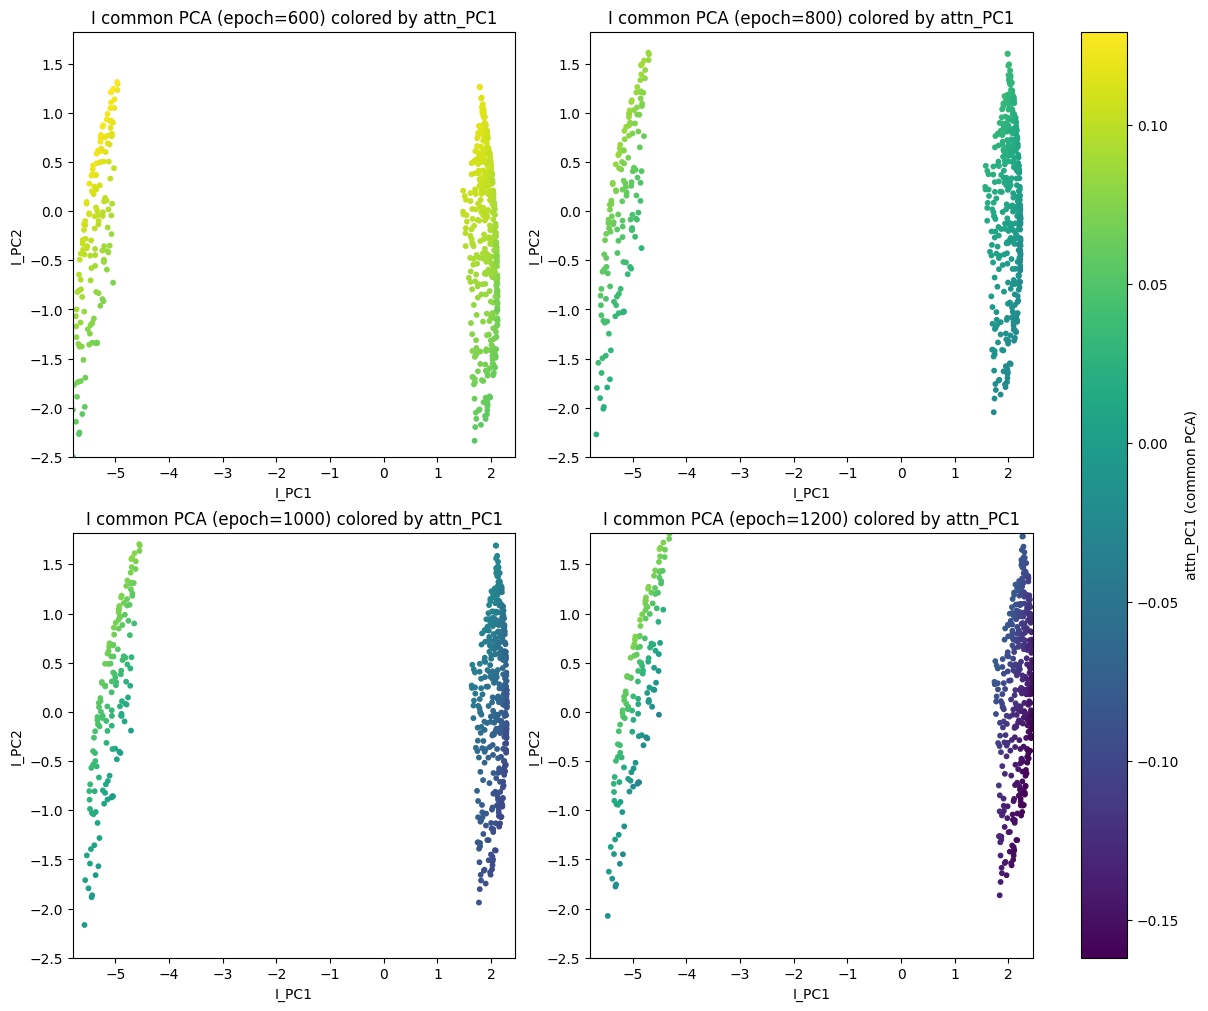

In [22]:
# step1_I_commonPCA_scatter_colored_by_attnPC1.py
from pathlib import Path
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

RUN_DIR = Path("runs/test1")
ISLAND_DIR = RUN_DIR / "islands"

# ゼロクロス前後（例）
EPOCHS = [600, 800, 1000, 1200]

# model.py で確定した token順（attn列の意味）
ATTN_LABELS = ["plant","sun","water","I1","I2","I3","self(growth)"]
IDX = {k:i for i,k in enumerate(ATTN_LABELS)}

def list_island_pts(island_dir: Path):
    pts = {}
    for p in island_dir.glob("island_epoch*.pt"):
        m = re.search(r"epoch(\d+)\.pt$", p.name)
        if m:
            pts[int(m.group(1))] = p
    return pts

def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std() * b0.std()) + 1e-12
    return float((a0 * b0).mean() / denom)

def load_I_env_attn(pt_path: Path, attn_key="attn"):
    d = torch.load(pt_path, map_location="cpu")

    I = d["I"]                          # (n,3,32)
    env = d["env"]                      # (n,3)  plant/sun/water
    A = d[attn_key]                     # (n,7) 共に growth行（head平均）想定

    I = to_np(I)
    env = to_np(env)
    A = to_np(A)

    # I を flatten -> (n, 3*32)
    if I.ndim != 3:
        raise ValueError(f"Unexpected I shape: {I.shape}")
    n, k, D = I.shape
    X = I.reshape(n, k * D)

    return X, env, A, d

def anchor_pca_by_feature_loading(pca: PCA, feature_index: int, pc_index: int = 0):
    """指定特徴の loading が + になるようにPC符号を固定（components_ を反転）"""
    if pca.components_[pc_index, feature_index] < 0:
        pca.components_[pc_index, :] *= -1
    return pca


pt_map = list_island_pts(ISLAND_DIR)
for ep in EPOCHS:
    if ep not in pt_map:
        raise FileNotFoundError(f"island for epoch={ep} not found in {ISLAND_DIR}")

# ---- 1) まとめてロード（I / env / attn）----
X_by_ep, env_by_ep, A_by_ep = {}, {}, {}
for ep in EPOCHS:
    X, env, A, _ = load_I_env_attn(pt_map[ep], attn_key="attn")
    X_by_ep[ep] = X
    env_by_ep[ep] = env
    A_by_ep[ep] = A

# ---- 2) 共通PCA（I） concat-fit ----
X_all = np.concatenate([X_by_ep[ep] for ep in EPOCHS], axis=0)
pca_I = PCA(n_components=2, random_state=0)
ZI_all = pca_I.fit_transform(X_all)
# I-PC符号アンカー：PC1が plant(env[:,0]) と正相関になるように固定
# （envと相関を見て、必要なら components_ を反転）
# ※ pca_I.components_ を反転しても transform の結果は自動では反転しないので、Zも反転する
#    最小なので、ここは「相関で判定してZを反転」方式にする
# まず代表として全体のenvも結合
env_all = np.concatenate([env_by_ep[ep] for ep in EPOCHS], axis=0)
plant_all = env_all[:, 0]
if corr(ZI_all[:, 0], plant_all) < 0:
    pca_I.components_[0, :] *= -1
    ZI_all[:, 0] *= -1
if corr(ZI_all[:, 1], plant_all) < 0:
    # PC2まで plant 正に寄せたい場合（好み）。不要ならコメントアウトOK
    pass

print("I common PCA explained_variance_ratio:", pca_I.explained_variance_ratio_)
print("I: corr(PC1, plant)=", f"{corr(ZI_all[:,0], plant_all):+.3f}")

# ---- 3) 共通PCA（attn） concat-fit ----
A_all = np.concatenate([A_by_ep[ep] for ep in EPOCHS], axis=0)
pca_A = PCA(n_components=2, random_state=0)
ZA_all = pca_A.fit_transform(A_all)

# attn-PC符号アンカー：PC1は I1 loading が + になるように固定（あなたの方針）
if pca_A.components_[0, IDX["I1"]] < 0:
    pca_A.components_[0, :] *= -1
    ZA_all[:, 0] *= -1
if pca_A.components_[1, IDX["I3"]] < 0:
    pca_A.components_[1, :] *= -1
    ZA_all[:, 1] *= -1

print("A common PCA explained_variance_ratio:", pca_A.explained_variance_ratio_)
print("A: PC1 loadings:", {ATTN_LABELS[i]: float(pca_A.components_[0,i]) for i in range(7)})

# ---- 4) epochごとに I座標 & attn_PC1 を作って可視化 ----
# 共通軸レンジで描く（比較しやすい）
# まず epochごとの ZI と attn_PC1 を作る
ZI_by_ep, attnPC1_by_ep = {}, {}
for ep in EPOCHS:
    ZI = pca_I.transform(X_by_ep[ep])
    if corr(ZI[:, 0], env_by_ep[ep][:, 0]) < 0:
        # 念のためepoch単位でも符号ズレが出たら反転（基本は起きない想定）
        ZI[:, 0] *= -1

    ZA = pca_A.transform(A_by_ep[ep])
    if pca_A.components_[0, IDX["I1"]] < 0:
        ZA[:, 0] *= -1

    ZI_by_ep[ep] = ZI
    attnPC1_by_ep[ep] = ZA[:, 0]  # 色

x_min = min(ZI_by_ep[ep][:,0].min() for ep in EPOCHS)
x_max = max(ZI_by_ep[ep][:,0].max() for ep in EPOCHS)
y_min = min(ZI_by_ep[ep][:,1].min() for ep in EPOCHS)
y_max = max(ZI_by_ep[ep][:,1].max() for ep in EPOCHS)
# 2x2想定（epochが4つのとき）。数が違う場合は自動で並べる
n = len(EPOCHS)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5*nrows), constrained_layout=True)
axes = np.array(axes).reshape(-1)

# 色レンジを揃える（比較しやすい）
c_min = min(attnPC1_by_ep[ep].min() for ep in EPOCHS)
c_max = max(attnPC1_by_ep[ep].max() for ep in EPOCHS)

last_sc = None
for i, ep in enumerate(EPOCHS):
    ax = axes[i]
    ZI = ZI_by_ep[ep]
    c = attnPC1_by_ep[ep]

    last_sc = ax.scatter(
        ZI[:,0], ZI[:,1],
        c=c,
        s=10,
        vmin=c_min, vmax=c_max
    )
    ax.set_title(f"I common PCA (epoch={ep}) colored by attn_PC1")
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("I_PC1"); ax.set_ylabel("I_PC2")

# 余ったaxesを消す
for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.colorbar(last_sc, ax=axes[:n].tolist(), label="attn_PC1 (common PCA)")
plt.show()


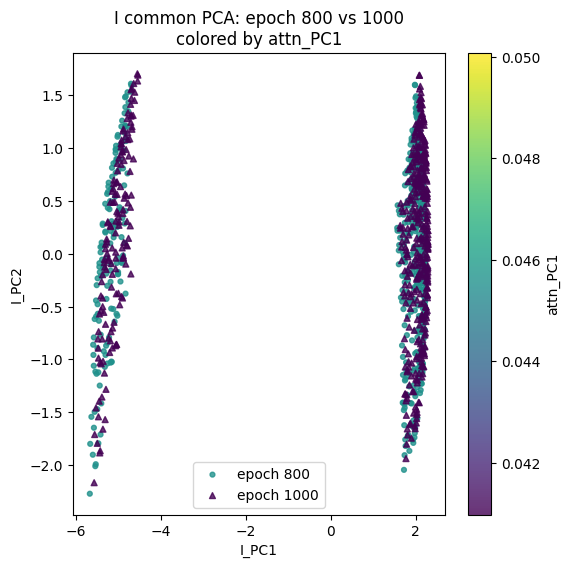

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 前提：
# pca_I : 共通PCA (fit済み)
# I_by_ep[800], I_by_ep[1000] : (N, 3, 32)
# attn_PC1_by_ep[ep] : (N,) or scalar → broadcast
I_by_ep = {}

for ep, path in pts:   # すでに使っている island list
    d = torch.load(path, map_location="cpu")
    I = d["I"]                     # (N,3,32)
    if isinstance(I, torch.Tensor):
        I = I.detach().cpu().numpy()
    I_by_ep[ep] = I

attn_PC1_by_ep = df_attn["attn_PC1_mean"].to_dict()

def flatten_I(I):
    return I.reshape(I.shape[0], -1)

ep_a, ep_b = 800, 1000

# --- I を共通PCAへ ---
Xa = flatten_I(I_by_ep[ep_a])
Xb = flatten_I(I_by_ep[ep_b])

Za = pca_I.transform(Xa)
Zb = pca_I.transform(Xb)

# attn_PC1（点ごと or epoch平均をbroadcast）
ca = attn_PC1_by_ep[ep_a]
cb = attn_PC1_by_ep[ep_b]

if np.isscalar(ca):
    ca = np.full(len(Za), ca)
if np.isscalar(cb):
    cb = np.full(len(Zb), cb)

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

sc1 = ax.scatter(
    Za[:,0], Za[:,1],
    c=ca, cmap="viridis",
    s=12, marker="o", alpha=0.8,
    label="epoch 800"
)

sc2 = ax.scatter(
    Zb[:,0], Zb[:,1],
    c=cb, cmap="viridis",
    s=18, marker="^", alpha=0.8,
    label="epoch 1000"
)

ax.set_title("I common PCA: epoch 800 vs 1000\ncolored by attn_PC1")
ax.set_xlabel("I_PC1")
ax.set_ylabel("I_PC2")
ax.legend()
plt.colorbar(sc1, ax=ax, label="attn_PC1")

plt.show()


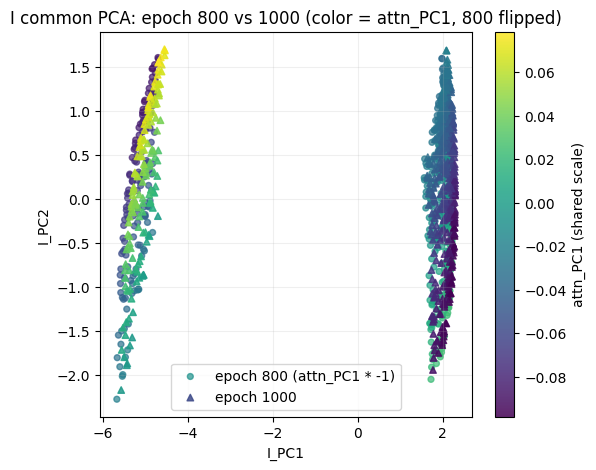

[check] corr(attn_PC1_800, attn_PC1_1000)       = 0.9835029244422913
[check] corr((-attn_PC1_800), attn_PC1_1000)    = -0.9835029244422913


In [24]:
import numpy as np
import matplotlib.pyplot as plt

ep_a, ep_b = 800, 1000

Za = ZI_by_ep[ep_a]          # (N,2) I common PCA coords
Zb = ZI_by_ep[ep_b]          # (N,2)

ca = attnPC1_by_ep[ep_a].copy().reshape(-1)  # (N,)
cb = attnPC1_by_ep[ep_b].copy().reshape(-1)

# ★ここが今回のポイント：800側だけ符号反転
ca_flip = -ca

# 共通のカラースケール（比較の信頼度UP）
vmin = float(min(ca_flip.min(), cb.min()))
vmax = float(max(ca_flip.max(), cb.max()))

plt.figure(figsize=(6,5))
sc1 = plt.scatter(Za[:,0], Za[:,1], c=ca_flip, vmin=vmin, vmax=vmax,
                  s=18, marker="o", alpha=0.70, label=f"epoch {ep_a} (attn_PC1 * -1)")
sc2 = plt.scatter(Zb[:,0], Zb[:,1], c=cb, vmin=vmin, vmax=vmax,
                  s=22, marker="^", alpha=0.85, label=f"epoch {ep_b}")

plt.title(f"I common PCA: epoch {ep_a} vs {ep_b} (color = attn_PC1, {ep_a} flipped)")
plt.xlabel("I_PC1"); plt.ylabel("I_PC2")
plt.legend(loc="best")
plt.colorbar(sc2, label="attn_PC1 (shared scale)")
plt.grid(True, alpha=0.2)
plt.show()

# ついでに「反転したらどれだけ一致度が上がるか」を数値でも見る（任意）
def corr(a,b):
    a = np.asarray(a).reshape(-1); b = np.asarray(b).reshape(-1)
    a0 = a - a.mean(); b0 = b - b.mean()
    return float((a0*b0).mean() / ((a0.std()*b0.std()) + 1e-12))

print("[check] corr(attn_PC1_800, attn_PC1_1000)       =", corr(ca, cb))
print("[check] corr((-attn_PC1_800), attn_PC1_1000)    =", corr(ca_flip, cb))


In [25]:
import numpy as np

a800 = attnPC1_by_ep[800]   # shape (N,)
a1000 = attnPC1_by_ep[1000] # shape (N,)

print("mean800, std800 :", float(a800.mean()), float(a800.std()))
print("mean1000,std1000:", float(a1000.mean()), float(a1000.std()))

# 線形回帰 a1000 ≈ k*a800 + b
k = np.cov(a800, a1000, bias=True)[0,1] / (np.var(a800) + 1e-12)
b = a1000.mean() - k*a800.mean()
print("fit: a1000 ≈ k*a800 + b")
print("k=", float(k), " b=", float(b))

# 残差の大きさ（どれくらい“同じ”か）
res = a1000 - (k*a800 + b)
print("residual std:", float(res.std()))


mean800, std800 : 0.02052593231201172 0.03032364882528782
mean1000,std1000: -0.03412773460149765 0.05181807652115822
fit: a1000 ≈ k*a800 + b
k= 1.680642934007982  b= -0.06862449770560627
residual std: 0.009373483442066352


In [26]:
amin = min(a800.min(), a1000.min())
amax = max(a800.max(), a1000.max())
# scatter の c= に入れる前に、同じ範囲で正規化
c800  = (a800  - amin) / (amax - amin + 1e-12)
c1000 = (a1000 - amin) / (amax - amin + 1e-12)


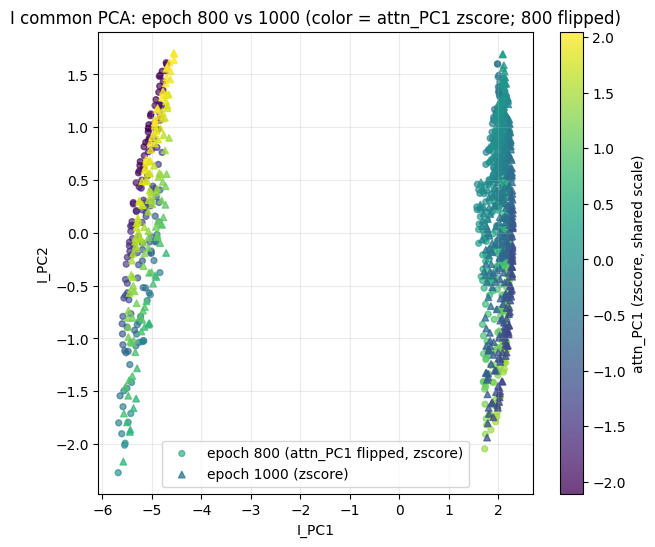

[check] corr(z(a800_flip), z(a1000)) = -0.9835029351544363
[check] mean/std c800: -3.3527613e-08 1.0  | c1000: 3.0733645e-08 0.99999994


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 前提：すでに下が揃っている想定
# ZI_by_ep[800]  -> shape (N,2)  Iの共通PCA座標 (I_PC1,I_PC2)
# ZI_by_ep[1000] -> shape (N,2)
# attnPC1_by_ep[800]  -> shape (N,)  attn_PC1（アンカー済みのPC1）
# attnPC1_by_ep[1000] -> shape (N,)

ep_a, ep_b = 800, 1000

Za = ZI_by_ep[ep_a]
Zb = ZI_by_ep[ep_b]

a800 = attnPC1_by_ep[ep_a].reshape(-1)
a1000 = attnPC1_by_ep[ep_b].reshape(-1)

# 1) 800だけ符号反転（今回の前提）
a800f = -a800

# 2) z-score 正規化（各epoch内で平均0・分散1）
def zscore(x):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + 1e-12)

c800 = zscore(a800f)
c1000 = zscore(a1000)

# 3) 共通カラースケール（結合して分位で切るのがおすすめ）
c_all = np.concatenate([c800, c1000])
vmin, vmax = np.quantile(c_all, [0.01, 0.99])  # 外れ値で潰れないように

plt.figure(figsize=(7,6))
sc1 = plt.scatter(Za[:,0], Za[:,1], c=c800, s=18, marker='o', alpha=0.65,
                  vmin=vmin, vmax=vmax, label="epoch 800 (attn_PC1 flipped, zscore)")
sc2 = plt.scatter(Zb[:,0], Zb[:,1], c=c1000, s=22, marker='^', alpha=0.75,
                  vmin=vmin, vmax=vmax, label="epoch 1000 (zscore)")

plt.title("I common PCA: epoch 800 vs 1000 (color = attn_PC1 zscore; 800 flipped)")
plt.xlabel("I_PC1"); plt.ylabel("I_PC2")
plt.legend(loc="best")
plt.colorbar(sc2, label="attn_PC1 (zscore, shared scale)")
plt.grid(True, alpha=0.25)
plt.show()

# 4) ついでに「同一性」を数値でも確認（zscore同士）
print("[check] corr(z(a800_flip), z(a1000)) =", np.corrcoef(c800, c1000)[0,1])
print("[check] mean/std c800:", c800.mean(), c800.std(), " | c1000:", c1000.mean(), c1000.std())


In [28]:
from scipy.stats import spearmanr
rho, p = spearmanr(a800f, a1000)
print("Spearman rho (800 flipped vs 1000) =", rho, "p=", p)


Spearman rho (800 flipped vs 1000) = -0.9975927082260446 p= 0.0


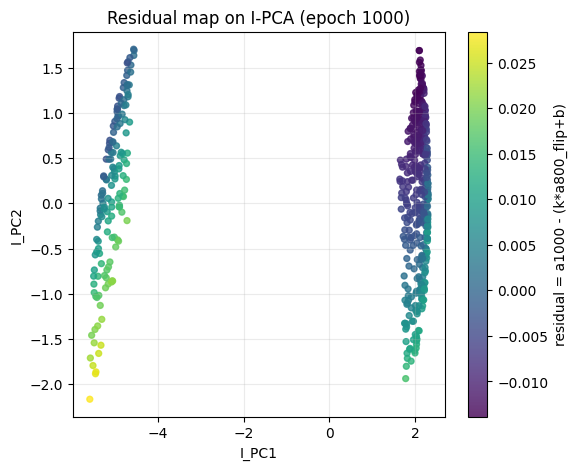

residual std: 0.009373483442066212 mean: -2.5831116759467143e-17


In [29]:
# さっきの回帰をもう一回
k, b = np.polyfit(a800f, a1000, 1)
res = a1000 - (k*a800f + b)

plt.figure(figsize=(6,5))
sc = plt.scatter(Zb[:,0], Zb[:,1], c=res, s=18, alpha=0.8)
plt.title("Residual map on I-PCA (epoch 1000)")
plt.xlabel("I_PC1"); plt.ylabel("I_PC2")
plt.colorbar(sc, label="residual = a1000 - (k*a800_flip+b)")
plt.grid(True, alpha=0.25)
plt.show()

print("residual std:", res.std(), "mean:", res.mean())


[check] corr(a800_aligned, a1000) = -0.9835028648376465
fit: attn_PC1 ≈ w1*I_PC1 + w2*I_PC2 + c
w1, w2, c = -0.000624604568235935 -0.002249291580920937 -0.06850300172966181
resid std = 0.06183376022118954


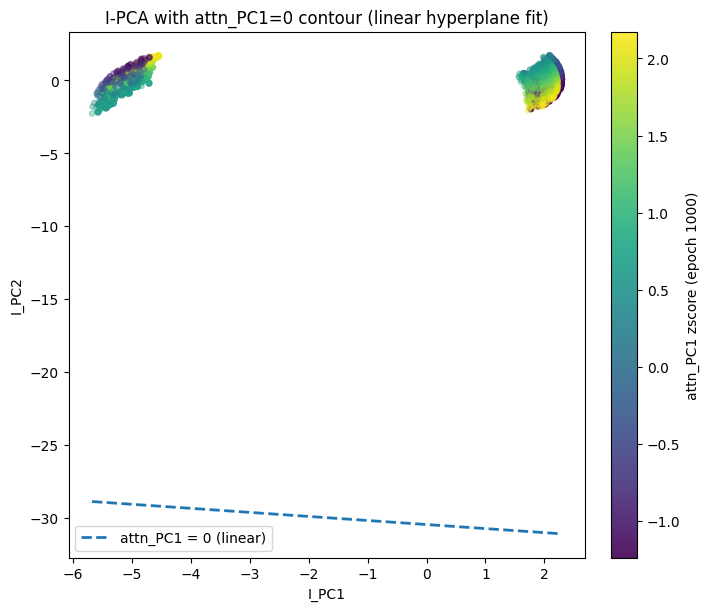

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def corr(a, b):
    a = np.asarray(a).reshape(-1); b = np.asarray(b).reshape(-1)
    a0 = a - a.mean(); b0 = b - b.mean()
    return float((a0*b0).mean() / (a0.std()*b0.std() + 1e-12))

# --- 必要epoch ---
EP_A, EP_B = 800, 1000

# --- 取り出し（ここはあなたの変数名に合わせて） ---
Za = ZI_by_ep[EP_A]          # (N,2) I-PCA座標
Zb = ZI_by_ep[EP_B]          # (N,2)
a800 = attnPC1_by_ep[EP_A]   # (N,)
a1000 = attnPC1_by_ep[EP_B]  # (N,)

Za = np.asarray(Za); Zb = np.asarray(Zb)
a800 = np.asarray(a800).reshape(-1)
a1000 = np.asarray(a1000).reshape(-1)

assert Za.shape[1] == 2 and Zb.shape[1] == 2, f"ZI must be (N,2). got {Za.shape}, {Zb.shape}"
assert Za.shape[0] == a800.shape[0], f"len mismatch: {Za.shape[0]} vs {a800.shape[0]}"
assert Zb.shape[0] == a1000.shape[0], f"len mismatch: {Zb.shape[0]} vs {a1000.shape[0]}"

# --- 800 を「反転 + 線形補正」で 1000スケールへ寄せる ---
# ここはあなたが出した値をそのまま入れてOK
k = 1.680642934007982
b = -0.06862449770560627
a800_aligned = k * (-a800) + b

print("[check] corr(a800_aligned, a1000) =", corr(a800_aligned, a1000))

# --- 回帰用データを結合 ---
X = np.vstack([Za, Zb])                      # (N_total,2)
y = np.concatenate([a800_aligned, a1000])    # (N_total,)

# --- 線形回帰: y ≈ w1*x + w2*y + c ---
A = np.column_stack([X[:,0], X[:,1], np.ones(len(X))])  # (N,3)
w1, w2, c = np.linalg.lstsq(A, y, rcond=None)[0]
y_hat = A @ np.array([w1, w2, c])
resid = y - y_hat
print("fit: attn_PC1 ≈ w1*I_PC1 + w2*I_PC2 + c")
print("w1, w2, c =", w1, w2, c)
print("resid std =", resid.std())

# --- 0等値線: w1*x + w2*y + c = 0 ---
def y_on_line(x):
    # w2 が極端に小さいと縦線になるので分岐
    if abs(w2) < 1e-9:
        return None
    return -(w1 * x + c) / w2

# --- 描画（I-PCA上に 0等値線を重ねる） ---
fig, ax = plt.subplots(1, 1, figsize=(7, 6), constrained_layout=True)

# epoch 1000 を基準に色（必要なら zscore にしてもOK）
cvals = (a1000 - a1000.mean()) / (a1000.std() + 1e-12)
sc = ax.scatter(Zb[:,0], Zb[:,1], c=cvals, s=18, alpha=0.9)
plt.colorbar(sc, ax=ax, label="attn_PC1 zscore (epoch 1000)")

# epoch 800（aligned）も薄く重ねたいなら（任意）
cvals800 = (a800_aligned - a800_aligned.mean()) / (a800_aligned.std() + 1e-12)
ax.scatter(Za[:,0], Za[:,1], c=cvals800, s=14, alpha=0.35)

# 0 等値線を引く
x_min = min(Za[:,0].min(), Zb[:,0].min())
x_max = max(Za[:,0].max(), Zb[:,0].max())
xs = np.linspace(x_min, x_max, 300)

ys = y_on_line(xs)
if ys is None:
    # 縦線: w1*x + c = 0
    x0 = -c / (w1 + 1e-12)
    ax.axvline(x0, linestyle="--", linewidth=2)
else:
    ax.plot(xs, ys, linestyle="--", linewidth=2, label="attn_PC1 = 0 (linear)")

ax.set_title("I-PCA with attn_PC1=0 contour (linear hyperplane fit)")
ax.set_xlabel("I_PC1"); ax.set_ylabel("I_PC2")
ax.legend()
plt.show()


I common PCA explained_variance_ratio: [0.9138022  0.06403468]
[sign auto] chosen sign for epoch800: +1, corr(after align)=+0.996966
[check] corr(attn_pc1_800, attn_pc1_1000)    =+0.996966
[check] corr(-attn_pc1_800, attn_pc1_1000)   =-0.996966

=== linear fit params (z(attn_PC1) ~ I_PC1,I_PC2) ===
epoch 800:  w1=-0.273389 w2=-0.420042 c=-0.000346  R²=0.9224
epoch 1000: w1=-0.284420 w2=-0.376085 c=+0.001914 R²=0.9428


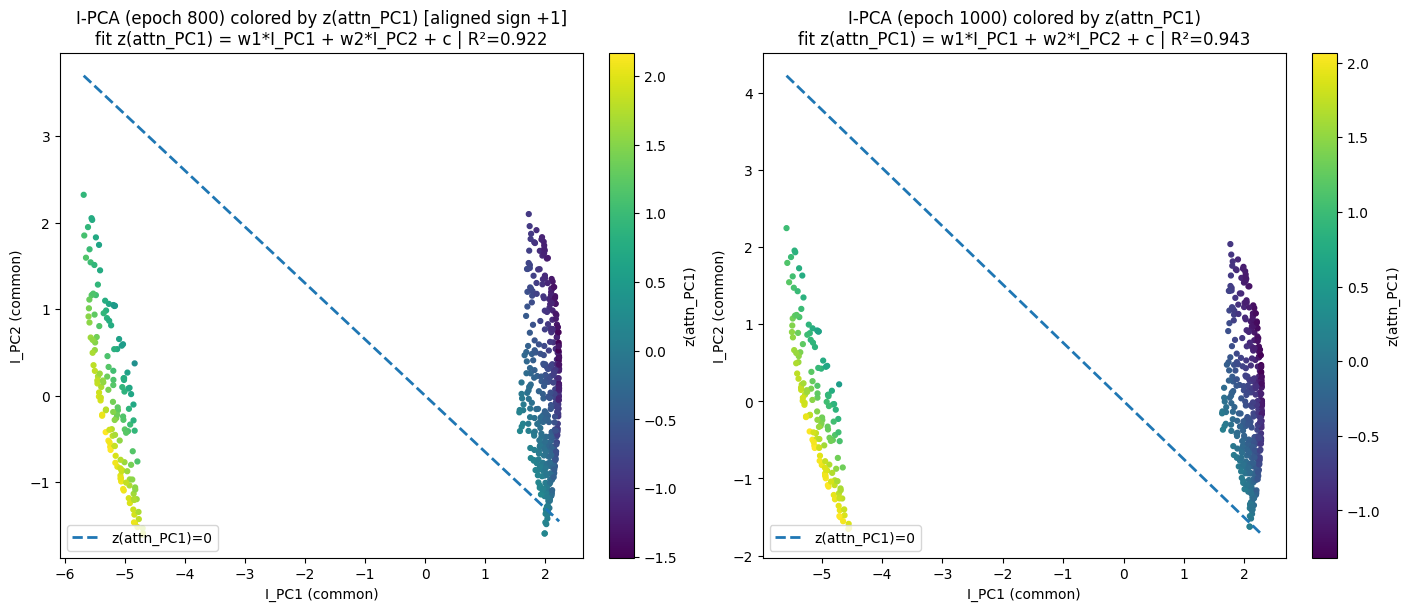

In [35]:
# attn_pc1_zero_contour_fixed.py
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

RUN_DIR = Path("runs/test1")
ISLAND_DIR = RUN_DIR / "islands"

E800 = 800
E1000 = 1000

# model.py より token順は確定：
# [plant, sun, water, I1, I2, I3, growth]
ATTN_LABELS = ["plant","sun","water","I1","I2","I3","self(growth)"]
IDX = {k:i for i,k in enumerate(ATTN_LABELS)}

def load_pt(epoch: int):
    p = ISLAND_DIR / f"island_epoch{epoch:05d}.pt"
    if not p.exists():
        raise FileNotFoundError(p)
    d = torch.load(p, map_location="cpu")
    I = d["I"]  # (N,3,32)
    A = d["attn"]  # (N,7) growth行のattention（平均済み）
    if isinstance(I, torch.Tensor):
        I = I.detach().cpu().numpy()
    else:
        I = np.asarray(I)
    if isinstance(A, torch.Tensor):
        A = A.detach().cpu().numpy()
    else:
        A = np.asarray(A)

    # flatten I -> (N,96)
    N = I.shape[0]
    X = I.reshape(N, -1)
    return X, A, d

def corr(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    return float((a0 * b0).mean() / ((a0.std() * b0.std()) + 1e-12))

def zscore(x):
    x = np.asarray(x).reshape(-1)
    return (x - x.mean()) / (x.std() + 1e-12)

def align_sign_to_ref(a_ref, a_other):
    """
    a_other の符号を、a_ref と相関が最大(正方向)になる向きに揃える
    """
    c1 = corr(a_other, a_ref)
    c2 = corr(-a_other, a_ref)
    if c2 > c1:
        return -a_other, -1, c2
    return a_other, +1, c1

def fit_and_plot_contour(Z, target_z, title, ax):
    """
    Z: (N,2) I-PCA座標
    target_z: (N,) 回帰ターゲット（zscore(attn_PC1)）
    """
    reg = LinearRegression()
    reg.fit(Z, target_z)
    r2 = reg.score(Z, target_z)

    w1, w2 = reg.coef_
    c0 = reg.intercept_

    # 散布図：色は target_z（= zscore(attn_PC1)）
    sc = ax.scatter(Z[:,0], Z[:,1], c=target_z, s=12)
    ax.set_title(f"{title}\nfit z(attn_PC1) = w1*I_PC1 + w2*I_PC2 + c | R²={r2:.3f}")
    ax.set_xlabel("I_PC1 (common)")
    ax.set_ylabel("I_PC2 (common)")
    plt.colorbar(sc, ax=ax, label="z(attn_PC1)")

    # 等値線 z=0（線形なので直線）
    x_min, x_max = Z[:,0].min(), Z[:,0].max()
    xs = np.linspace(x_min, x_max, 200)

    # w1*x + w2*y + c0 = 0 -> y = -(w1*x + c0)/w2
    # w2 がほぼ0の場合は縦線 x = -c0/w1
    eps = 1e-12
    if abs(w2) > 1e-8:
        ys = -(w1 * xs + c0) / (w2 + eps)
        ax.plot(xs, ys, "--", linewidth=2, label="z(attn_PC1)=0")
    elif abs(w1) > 1e-8:
        x0 = -c0 / (w1 + eps)
        ax.axvline(x0, linestyle="--", linewidth=2, label="z(attn_PC1)=0")
    else:
        # ほぼ定数：線が定義できない
        ax.text(0.02, 0.02, "degenerate fit (w1≈w2≈0)", transform=ax.transAxes)

    ax.legend(loc="lower left")

    # 追加で係数も返す
    return {"w1": float(w1), "w2": float(w2), "c": float(c0), "r2": float(r2)}

def main():
    # ---- load ----
    X800, A800, d800 = load_pt(E800)
    X1000, A1000, d1000 = load_pt(E1000)

    # ---- common I PCA (fit on both epochs) ----
    X_all = np.concatenate([X800, X1000], axis=0)
    pca_I = PCA(n_components=2, random_state=0)
    Z_all = pca_I.fit_transform(X_all)
    Z800 = pca_I.transform(X800)
    Z1000 = pca_I.transform(X1000)
    print("I common PCA explained_variance_ratio:", pca_I.explained_variance_ratio_)

    # ---- define attn_PC1 (use the SAME pca_attn used in your pipeline) ----
    # ここでは「attnそのものからPC1を作る」のではなく、
    # すでにあなたが作っている attn_PC1（共通attn PCAのPC1）を使うのが理想。
    # しかし最小コードとして、ここでは attn(7次元)の共通PCAからPC1を作ります。
    # ※あなたの "anchor" 基準(I1+)も再現します。
    A_all = np.concatenate([A800, A1000], axis=0)
    pca_A = PCA(n_components=2, random_state=0)
    ZA_all = pca_A.fit_transform(A_all)

    # アンカー：PC1のI1 loading を + にする（model順の I1 は index=3）
    if pca_A.components_[0, IDX["I1"]] < 0:
        pca_A.components_[0,:] *= -1
        ZA_all[:,0] *= -1

    ZA800 = pca_A.transform(A800)
    ZA1000 = pca_A.transform(A1000)
    if pca_A.components_[0, IDX["I1"]] < 0:  # 念のため
        ZA800[:,0] *= -1
        ZA1000[:,0] *= -1

    attn_pc1_800 = ZA800[:,0].copy()
    attn_pc1_1000 = ZA1000[:,0].copy()

    # ---- sign auto alignment: make 800 aligned to 1000 ----
    attn_pc1_800_aligned, sgn, cc = align_sign_to_ref(attn_pc1_1000, attn_pc1_800)
    print(f"[sign auto] chosen sign for epoch800: {sgn:+d}, corr(after align)={cc:+.6f}")
    print(f"[check] corr(attn_pc1_800, attn_pc1_1000)    ={corr(attn_pc1_800, attn_pc1_1000):+.6f}")
    print(f"[check] corr(-attn_pc1_800, attn_pc1_1000)   ={corr(-attn_pc1_800, attn_pc1_1000):+.6f}")

    # ---- zscore target (each epoch individually) ----
    # 「z=0 を平均境界」にしたいので、各epochでzscore
    z800 = zscore(attn_pc1_800_aligned)
    z1000 = zscore(attn_pc1_1000)

    # ---- plot: two panels (800 / 1000) with each z=0 line ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    info800 = fit_and_plot_contour(
        Z800, z800,
        title=f"I-PCA (epoch {E800}) colored by z(attn_PC1) [aligned sign {sgn:+d}]",
        ax=axes[0]
    )
    info1000 = fit_and_plot_contour(
        Z1000, z1000,
        title=f"I-PCA (epoch {E1000}) colored by z(attn_PC1)",
        ax=axes[1]
    )

    print("\n=== linear fit params (z(attn_PC1) ~ I_PC1,I_PC2) ===")
    print(f"epoch {E800}:  w1={info800['w1']:+.6f} w2={info800['w2']:+.6f} c={info800['c']:+.6f}  R²={info800['r2']:.4f}")
    print(f"epoch {E1000}: w1={info1000['w1']:+.6f} w2={info1000['w2']:+.6f} c={info1000['c']:+.6f} R²={info1000['r2']:.4f}")

    plt.show()

if __name__ == "__main__":
    main()


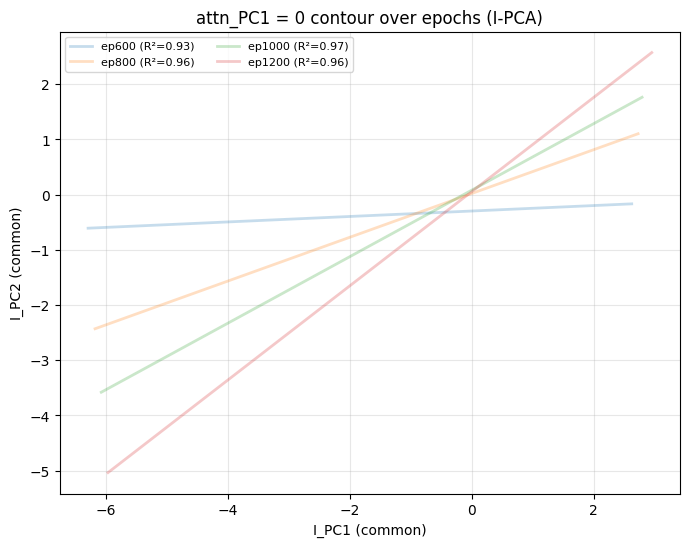

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ========= 前提 =========
# ZI_by_ep : (n,2) I の共通 PCA 座標
# attnPC1_by_ep : (n,) attn_PC1（未正規化）
# epochs : epoch のリスト（例: [200,400,...,2000]）

# NOTE: Ensure 'epochs' variable is consistent with keys in 'attnPC1_by_ep'
# The 'attnPC1_by_ep' was populated with specific epochs. Let's use those keys.
epochs = sorted(list(attnPC1_by_ep.keys()))

# ---------- ユーティリティ ----------
def zscore(x):
    return (x - x.mean()) / x.std()

def auto_align_sign(a_ref, a):
    if np.corrcoef(a_ref, a)[0,1] < 0:
        return -a
    return a

# ---------- 基準 epoch（向き固定用） ----------
ref_ep = epochs[-1]   # 例：最後の epoch
a_ref = zscore(attnPC1_by_ep[ref_ep])

# ---------- 描画 ----------
plt.figure(figsize=(8,6))

for ep in epochs:
    ZI = ZI_by_ep[ep]
    a = zscore(attnPC1_by_ep[ep])
    a = auto_align_sign(a_ref, a)

    # 線形 fit
    reg = LinearRegression().fit(ZI, a)
    w1, w2 = reg.coef_
    c = reg.intercept_
    r2 = r2_score(a, reg.predict(ZI))

    # 等値線 attn_PC1 = 0
    x = np.linspace(ZI[:,0].min()-0.5, ZI[:,0].max()+0.5, 200)
    y = -(w1*x + c)/w2

    plt.plot(x, y, alpha=0.25, lw=2,
             label=f"ep{ep} (R²={r2:.2f})")

plt.xlabel("I_PC1 (common)")
plt.ylabel("I_PC2 (common)")
plt.title("attn_PC1 = 0 contour over epochs (I-PCA)")
plt.legend(ncol=2, fontsize=8)
plt.grid(alpha=0.3)
plt.show()

[ref_epoch] 1000

=== (1) angle time-series table ===


,sign_align,R2_epochfit,resid_std,w1,w2,c,angle_deg(normal),cos_sim_to_ref,angle_diff_to_ref_deg
epoch,,,,,,,,,
600,1,0.930203,0.264190,-0.054234,1.096780,0.327564,92.830879,0.881057,28.229855
800,1,0.955717,0.210436,-0.250122,0.630713,-0.012226,111.631812,0.986490,9.428923
1000,1,0.970725,0.171098,-0.280999,0.466539,-0.037188,121.060735,1.000000,0.000155
1200,1,0.959554,0.201112,-0.293003,0.343477,-0.018425,130.465859,0.986558,9.405124



=== (2) single-boundary test (per-epoch R² drop) ===
[global] w1=-0.147465 w2=+0.064657 c=-0.000000


,R2_epochfit,R2_global_line,delta
epoch,,,
600,0.930203,0.077508,0.852696
800,0.955717,0.607875,0.347841
1000,0.970725,0.672354,0.298372
1200,0.959554,0.688602,0.270952


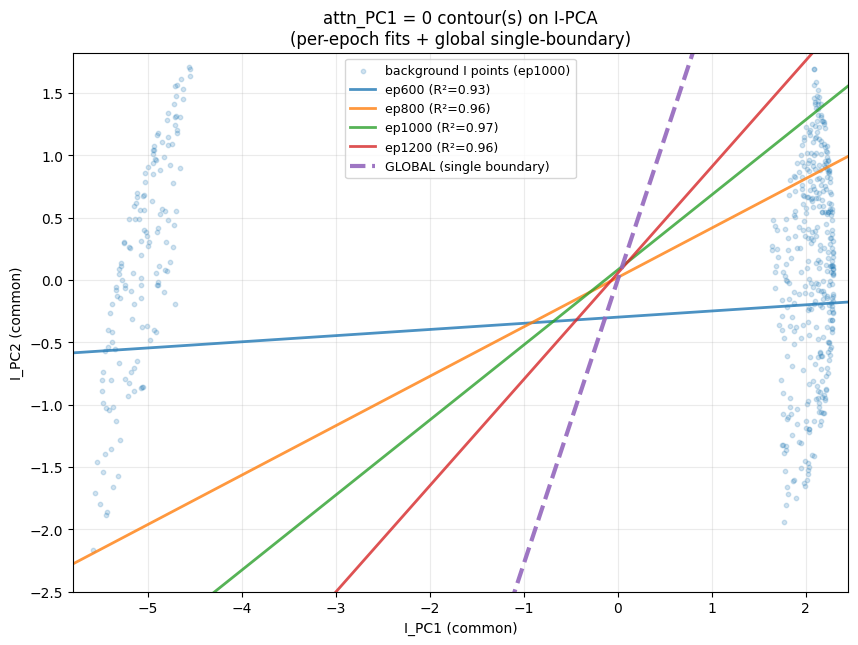

In [42]:
# --- One-cell minimal: (1) angle time-series + (2) single-boundary test + (3) background scatter + contours ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Expected to exist in your notebook:
#   ZI_by_ep: dict[epoch] -> np.ndarray shape (N,2)   # I common-PCA coords (I_PC1,I_PC2)
#   attnPC1_by_ep: dict[epoch] -> np.ndarray shape (N,) or (N,1)  # attn_PC1 (raw; sign may vary)
# Optional:
#   epochs = sorted(ZI_by_ep.keys())

def _to_1d(a):
    a = np.asarray(a)
    return a.reshape(-1)

def zscore(a, eps=1e-12):
    a = _to_1d(a)
    return (a - a.mean()) / (a.std() + eps)

def corr(a, b, eps=1e-12):
    a = _to_1d(a); b = _to_1d(b)
    a0 = a - a.mean(); b0 = b - b.mean()
    return float((a0*b0).mean() / ((a0.std()+eps)*(b0.std()+eps)))

def fit_plane(ZI, a, zscore_target=True):
    """fit: target ~ w1*I_PC1 + w2*I_PC2 + c ; return w1,w2,c,R2,resid_std"""
    X = np.asarray(ZI)
    assert X.ndim == 2 and X.shape[1] == 2, f"ZI must be (N,2), got {X.shape}"
    y = zscore(a) if zscore_target else _to_1d(a)

    lr = LinearRegression()
    lr.fit(X, y)
    pred = lr.predict(X)

    ss_res = float(np.sum((y - pred)**2))
    ss_tot = float(np.sum((y - y.mean())**2) + 1e-12)
    r2 = 1.0 - ss_res/ss_tot
    resid_std = float(np.std(y - pred))

    w1, w2 = map(float, lr.coef_)
    c = float(lr.intercept_)
    return w1, w2, c, r2, resid_std, y, pred

def unit(v, eps=1e-12):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v) + eps
    return v / n

def angle_deg_from_w(w):
    # normal vector angle in I-PC plane (atan2)
    w = np.asarray(w, dtype=float)
    return float(np.degrees(np.arctan2(w[1], w[0])))

def draw_line(ax, w1, w2, c, xlim, label=None, **kw):
    # w1*x + w2*y + c = 0  => y = -(w1*x + c)/w2
    xs = np.linspace(xlim[0], xlim[1], 200)
    if abs(w2) < 1e-10:
        # vertical line: x = -c/w1
        if abs(w1) < 1e-10:
            return
        x0 = -c / w1
        ax.plot([x0, x0], [ax.get_ylim()[0], ax.get_ylim()[1]], label=label, **kw)
    else:
        ys = -(w1*xs + c) / w2
        ax.plot(xs, ys, label=label, **kw)

# -------------------------
# 0) epochs & reference
# -------------------------
epochs = sorted(set(ZI_by_ep.keys()) & set(attnPC1_by_ep.keys()))
if len(epochs) == 0:
    raise RuntimeError("No overlapping epochs between ZI_by_ep and attnPC1_by_ep.")

# pick reference epoch for sign alignment + angle reference
ref_epoch = 1000 if 1000 in epochs else epochs[len(epochs)//2]

ZI_ref = np.asarray(ZI_by_ep[ref_epoch])
a_ref_raw = _to_1d(attnPC1_by_ep[ref_epoch])
a_ref = zscore(a_ref_raw)  # reference in zscore space

# -------------------------
# 1) per-epoch: sign auto-align to ref + fit planes + angle table
# -------------------------
rows = []
fits = {}  # ep -> dict with w,c,r2,...
for ep in epochs:
    ZI = np.asarray(ZI_by_ep[ep])
    a_raw = _to_1d(attnPC1_by_ep[ep])

    # sign auto: pick sign that maximizes corr with ref (assumes same sample order)
    a_z = zscore(a_raw)
    cpos = corr(a_z, a_ref)
    cneg = corr(-a_z, a_ref)
    sign = +1 if cpos >= cneg else -1
    a_aligned = sign * a_raw

    w1, w2, c0, r2, resid_std, y_z, yhat = fit_plane(ZI, a_aligned, zscore_target=True)
    w = np.array([w1, w2], dtype=float)
    w_u = unit(w)

    fits[ep] = dict(
        sign=sign, w1=w1, w2=w2, c=c0, r2=r2, resid_std=resid_std,
        w_unit=w_u, angle_deg=angle_deg_from_w(w_u),
        y_z=y_z, yhat=yhat
    )

# reference direction for angle similarity (use ref_epoch's w_unit)
w_ref_u = fits[ref_epoch]["w_unit"]
for ep in epochs:
    w_u = fits[ep]["w_unit"]
    cos_sim = float(np.clip(np.dot(w_u, w_ref_u), -1.0, 1.0))
    ang_diff = float(np.degrees(np.arccos(cos_sim)))  # 0..180
    rows.append({
        "epoch": ep,
        "sign_align": fits[ep]["sign"],
        "R2_epochfit": fits[ep]["r2"],
        "resid_std": fits[ep]["resid_std"],
        "w1": fits[ep]["w1"],
        "w2": fits[ep]["w2"],
        "c": fits[ep]["c"],
        "angle_deg(normal)": fits[ep]["angle_deg"],
        "cos_sim_to_ref": cos_sim,
        "angle_diff_to_ref_deg": ang_diff,
    })

df_angle = pd.DataFrame(rows).set_index("epoch").sort_index()
print(f"[ref_epoch] {ref_epoch}")
print("\n=== (1) angle time-series table ===")
display(df_angle.round(6))

# -------------------------
# 2) single-boundary test: fit ONE plane on all epochs combined, then score per-epoch R²
# -------------------------
X_all = []
y_all = []
for ep in epochs:
    X_all.append(np.asarray(ZI_by_ep[ep]))
    # use aligned sign per epoch, zscore target globally? -> keep raw aligned then global zscore after concat
    y_all.append(_to_1d(fits[ep]["sign"] * _to_1d(attnPC1_by_ep[ep])))

X_all = np.concatenate(X_all, axis=0)
y_all_raw = np.concatenate(y_all, axis=0)
y_all_z = zscore(y_all_raw)

lr_global = LinearRegression()
lr_global.fit(X_all, y_all_z)
w1g, w2g = map(float, lr_global.coef_)
cg = float(lr_global.intercept_)

def r2_on_epoch(ep):
    X = np.asarray(ZI_by_ep[ep])
    y = zscore(fits[ep]["sign"] * _to_1d(attnPC1_by_ep[ep]))
    pred = lr_global.predict(X)
    ss_res = float(np.sum((y - pred)**2))
    ss_tot = float(np.sum((y - y.mean())**2) + 1e-12)
    return 1.0 - ss_res/ss_tot

df_global = pd.DataFrame({
    "R2_epochfit": df_angle["R2_epochfit"],
    "R2_global_line": [r2_on_epoch(ep) for ep in df_angle.index],
}).assign(delta=lambda d: d["R2_epochfit"] - d["R2_global_line"])
print("\n=== (2) single-boundary test (per-epoch R² drop) ===")
print(f"[global] w1={w1g:+.6f} w2={w2g:+.6f} c={cg:+.6f}")
display(df_global.round(6))

# -------------------------
# 3) plot: background scatter + per-epoch contours + global contour
# -------------------------
# choose background epoch to show point cloud (defaults to ref)
bg_epoch = ref_epoch
Z_bg = np.asarray(ZI_by_ep[bg_epoch])

# axis limits from background (or from all)
xs = np.concatenate([np.asarray(ZI_by_ep[e])[:,0] for e in epochs])
ys = np.concatenate([np.asarray(ZI_by_ep[e])[:,1] for e in epochs])
xlim = (float(xs.min()), float(xs.max()))
ylim = (float(ys.min()), float(ys.max()))

plt.figure(figsize=(10, 7))
plt.scatter(Z_bg[:,0], Z_bg[:,1], s=10, alpha=0.20, label=f"background I points (ep{bg_epoch})")

# draw per-epoch attn_PC1=0 lines (zscore target => contour at 0)
# Pick a few evenly spaced epochs if too many (avoid clutter)
max_lines = 12
draw_epochs = epochs if len(epochs) <= max_lines else list(np.linspace(0, len(epochs)-1, max_lines).round().astype(int))

for ep in draw_epochs:
    f = fits[ep]
    draw_line(
        plt.gca(), f["w1"], f["w2"], f["c"], xlim,
        label=f"ep{ep} (R²={f['r2']:.2f})",
        linewidth=2, alpha=0.8
    )

# global line
draw_line(
    plt.gca(), w1g, w2g, cg, xlim,
    label="GLOBAL (single boundary)",
    linewidth=3, linestyle="--", alpha=0.9
)

plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("I_PC1 (common)"); plt.ylabel("I_PC2 (common)")
plt.title("attn_PC1 = 0 contour(s) on I-PCA\n(per-epoch fits + global single-boundary)")
plt.legend(loc="best", fontsize=9)
plt.grid(True, alpha=0.25)
plt.show()